In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 6 blocks pruned model vs oringinal

In [ ]:
# -6-blocks
# ============================================================
# ViT (timm) — Stability + Monitoring + Pruning + LIGHT VALIDATION
# - 70/15/15 stratified split from all images (ignores folder splits)
# - Temperature-scaled attention (T=1.5)
# - Post-attention LayerNorm (safe wrapper)
# - Label smoothing, AMP, gradient clipping
# - Attention entropy monitoring
# - ✅ LIGHT VALIDATION: quick val passes (few batches) every N epochs
# - ✅ EARLY STOPPING: patience/min_delta, restore best checkpoint
# - ✅ LIGHT HYPERPARAM TUNING: 5 epochs per candidate (tiny subset)
# - ✂️ Prune 6 blocks (keep 6), brief fine-tune
# - 📊 Prints: train/test acc, precision/recall/F1, params, FLOPs, memory, times
# ============================================================

!pip install -q timm scikit-learn ptflops

import os, random, time, gc, math, copy
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit
from timm.scheduler import CosineLRScheduler
from torch.amp import GradScaler, autocast

# -----------------------------
# 🔧 Reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# ⚙️ Validation / Tuning knobs
# -----------------------------
VAL_EVERY_N_EPOCHS = 1         # run lightweight val every N epochs
VAL_MAX_BATCHES     = 6        # validate on at most this many batches (keep small)
PATIENCE            = 3        # early stopping patience (epochs)
MIN_DELTA           = 1e-3     # minimum improvement in val loss to reset patience

ENABLE_TUNING       = True     # pilot sweep to pick LR/WD quickly
TUNE_EPOCHS         = 5        # 5 epochs per candidate
TUNE_TRAIN_FRAC     = 0.08     # use 8% of train for quick tuning
TUNE_VAL_MAX_BATCH  = 3        # validate only a handful of batches in tuning

# -------------------------------------------------------
# 📁 Data root — your Kaggle dataset
# -------------------------------------------------------
data_root = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

# -------------------------------------------------------
# 🖼️ Transforms
# -------------------------------------------------------
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# -------------------------------------------------------
# 📦 Build unified sample list then 70/15/15 split (stratified)
# -------------------------------------------------------
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
def list_class_dirs(parent): return sorted([d for d in os.listdir(parent) if os.path.isdir(os.path.join(parent, d))])

if os.path.exists(train_dir) and len(list_class_dirs(train_dir)) > 0:
    classes = list_class_dirs(train_dir)
elif os.path.exists(val_dir) and len(list_class_dirs(val_dir)) > 0:
    classes = list_class_dirs(val_dir)
else:
    classes = list_class_dirs(test_dir)
class_to_idx = {c: i for i, c in enumerate(classes)}

def gather_samples(split_dir):
    samples = []
    for cls in classes:
        cdir = os.path.join(split_dir, cls)
        if not os.path.isdir(cdir): continue
        for root, _, files in os.walk(cdir):
            for f in files:
                if f.lower().endswith(IMG_EXTS):
                    samples.append((os.path.join(root, f), class_to_idx[cls]))
    return samples

all_samples = []
for d in [train_dir, val_dir, test_dir]:
    all_samples.extend(gather_samples(d))
assert len(all_samples) > 0, "No images found. Check dataset paths."

labels  = np.array([lbl for _, lbl in all_samples])
indices = np.arange(len(all_samples))

sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.70, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(indices, labels))
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.50, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(sss2.split(temp_idx, temp_labels))
val_idx, test_idx = temp_idx[val_rel_idx], temp_idx[test_rel_idx]

def take(idxs): return [all_samples[i] for i in idxs]
train_samples, val_samples, test_samples = take(train_idx), take(val_idx), take(test_idx)

print(f"✅ Split sizes — Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")
print(f"    Classes ({len(classes)}): {classes}")

# -------------------------------------------------------
# 🧰 Dataset from file paths
# -------------------------------------------------------
class PathImageDataset(Dataset):
    def __init__(self, samples, classes, transform=None):
        self.samples = samples; self.classes = classes; self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform: img = self.transform(img)
        return img, target

train_dataset = PathImageDataset(train_samples, classes, transform=train_transforms)
val_dataset   = PathImageDataset(val_samples,   classes, transform=val_test_transforms)
test_dataset  = PathImageDataset(test_samples,  classes, transform=val_test_transforms)

def make_loader(dataset, batch_size=32, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

train_loader = make_loader(train_dataset, batch_size=32, shuffle=True)
val_loader   = make_loader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = make_loader(test_dataset,  batch_size=32, shuffle=False)

# -------------------------------------------------------
# 🔥 Attention wrapper (temperature scaling)
# -------------------------------------------------------
from timm.models.vision_transformer import Attention
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv        = base_attn.qkv
        self.proj       = base_attn.proj
        self.proj_drop  = base_attn.proj_drop
        self.attn_drop  = base_attn.attn_drop
        self.num_heads  = base_attn.num_heads
        self.q_norm     = getattr(base_attn, 'q_norm', None)
        self.k_norm     = getattr(base_attn, 'k_norm', None)
        self.scale      = base_attn.scale
        self.temperature= float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)
        attn_logits = (q @ k.transpose(-2,-1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad(): self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()
        attn = attn_logits.softmax(dim=-1); attn = self.attn_drop(attn)
        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

def apply_temperature_to_vit(model, T=1.5):
    for _, blk in enumerate(model.blocks):
        blk.attn = TempScaledAttention(blk.attn, temperature=T)

# -------------------------------------------------------
# ✅ Post-attention LayerNorm (safe block wrapper)
# -------------------------------------------------------
class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1, self.ls2 = getattr(blk,"ls1",None), getattr(blk,"ls2",None)
        self.gamma_1, self.gamma_2 = getattr(blk,"gamma_1",None), getattr(blk,"gamma_2",None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)
    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, gamma): return ls(x) if ls is not None else (gamma*x if gamma is not None else x)
    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1)
        x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2)
        x = x + self._dp(y, self.dp2)
        return x

def add_post_attn_layernorm_safe(model, eps=1e-6):
    device = next(model.parameters()).device
    new_blocks = [PostAttnLNBlock(blk, eps=eps).to(device) for blk in model.blocks]
    model.blocks = nn.Sequential(*new_blocks)

# -------------------------------------------------------
# 🧠 Build model + patches
# -------------------------------------------------------
num_classes = len(classes)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes).to(device)
ATTN_T = 1.5
apply_temperature_to_vit(model, T=ATTN_T)
add_post_attn_layernorm_safe(model, eps=1e-6)

LOGIT_CLIP = 0.0

# -------------------------------------------------------
# 📏 FLOPs / Params helper (with safe fallback)
# -------------------------------------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def flops_and_params(model, input_res=(3,224,224)):
    # Try ptflops, fall back to "N/A" FLOPs if it fails
    try:
        from ptflops import get_model_complexity_info
        model_eval = copy.deepcopy(model).to('cpu').eval()
        with torch.no_grad():
            macs, params = get_model_complexity_info(model_eval, input_res, as_strings=False, verbose=False)
        # ptflops returns MACs (multiply-adds). FLOPs ≈ 2*MACs for convs; for transformers it's common to report MACs.
        return macs, count_params(model)
    except Exception as e:
        return None, count_params(model)

# -------------------------------------------------------
# 🧪 Training / Eval helpers (with LIGHT validation)
# -------------------------------------------------------
def forward_with_optional_logit_clip(model, images):
    logits = model(images)
    if LOGIT_CLIP and LOGIT_CLIP > 0:
        logits = torch.clamp(logits, min=-LOGIT_CLIP, max=LOGIT_CLIP)
    return logits

def print_memory(label=""):
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated()/1024**2
        reserv = torch.cuda.memory_reserved()/1024**2
        print(f"\U0001f9e0 {label} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

@torch.no_grad()
def report_attention_stats(model, loader, max_batches=1, tag=""):
    model.eval()
    batches, entropies, max_abs_logits = 0, [], []
    for images, _ in loader:
        images = images.to(device)
        with autocast('cuda'): _ = model(images)
        blk_ents, blk_max = [], []
        for blk in model.blocks:
            attn = blk.attn
            if isinstance(attn, TempScaledAttention) and attn.last_entropy is not None:
                blk_ents.append(attn.last_entropy.numpy()); blk_max.append(attn.last_max_abs_pre_softmax)
            else:
                blk_ents.append(None); blk_max.append(None)
        entropies.append(blk_ents); max_abs_logits.append(blk_max)
        batches += 1
        if batches >= max_batches: break
    print(f"\n🔎 Attention saturation ({tag}) — T={ATTN_T}")
    for i, _ in enumerate(model.blocks):
        head_arrays = [e[i] for e in entropies if e[i] is not None]
        max_vals    = [m[i] for m in max_abs_logits if m[i] is not None]
        if head_arrays:
            H = np.stack(head_arrays, axis=0)
            mean_ent, p10, p90 = H.mean(), np.percentile(H,10), np.percentile(H,90)
            mx = np.mean(max_vals) if len(max_vals)>0 else float('nan')
            print(f"  Block {i:02d}: entropy mean={mean_ent:.3f}, p10={p10:.3f}, p90={p90:.3f} | max|pre-softmax|≈{mx:.3f}")
        else:
            print(f"  Block {i:02d}: (no stats)")

def make_optimizer(model, lr=3e-4, weight_decay=0.01):
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def make_scheduler(optimizer, t_initial=10):
    return CosineLRScheduler(optimizer, t_initial=t_initial, lr_min=1e-6, warmup_lr_init=1e-5, warmup_t=3)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def eval_light(model, loader, max_batches=VAL_MAX_BATCHES):
    model.eval()
    total_loss, correct, total, batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
                loss   = criterion(logits, labels)
            total_loss += loss.item()
            correct    += (logits.argmax(1) == labels).sum().item()
            total      += labels.size(0)
            batches    += 1
            if batches >= max_batches: break
    avg_loss = total_loss / max(1, batches)
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc

def evaluate_full(model, loader, class_names):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            y_true += labels.cpu().tolist(); y_pred += preds.cpu().tolist()
    acc = 100.0 * correct / max(1,total)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, report, (pr, rc, f1)

# -----------------------------
# 🛑 Early stopping helper
# -----------------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience; self.min_delta = min_delta
        self.best = float('inf'); self.count = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0; return False
        else:
            self.count += 1; return self.count > self.patience

# -----------------------------
# 🔍 Tiny pilot hyperparam tuning (LR/WD)
# -----------------------------
def make_subset(dataset, frac):
    n = len(dataset); k = max(1, int(n*frac))
    idx = np.random.RandomState(42).choice(n, size=k, replace=False)
    return Subset(dataset, idx.tolist())

def pilot_tune(base_model, train_ds, val_loader, candidates, epochs=TUNE_EPOCHS):
    print("\n🧪 Tiny pilot tuning (subset) ...")
    best_cfg, best_score, best_loss = None, -1, float('inf')
    for (lr, wd) in candidates:
        model = copy.deepcopy(base_model).to(device)
        opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        scaler = GradScaler('cuda')
        loader = make_loader(make_subset(train_ds, TUNE_TRAIN_FRAC), batch_size=32, shuffle=True)
        for ep in range(epochs):
            model.train()
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                opt.zero_grad(set_to_none=True)
                with autocast('cuda'):
                    logits = forward_with_optional_logit_clip(model, images)
                    loss   = criterion(logits, labels)
                scaler.scale(loss).backward()
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
        val_loss, val_acc = eval_light(model, val_loader, max_batches=TUNE_VAL_MAX_BATCH)
        print(f"  LR={lr:.1e}, WD={wd:.3f} -> light ValAcc={val_acc:.2f}%, ValLoss={val_loss:.4f}")
        if (val_acc > best_score) or (abs(val_acc - best_score) < 1e-6 and val_loss < best_loss):
            best_score, best_loss = val_acc, val_loss
            best_cfg = (lr, wd)
    print(f"✅ Chosen hyperparams: LR={best_cfg[0]:.1e}, WD={best_cfg[1]:.3f} (best light ValAcc={best_score:.2f}%)")
    return best_cfg

# -------------------------------------------------------
# 🚀 Train with LIGHT validation + Early Stopping
# -------------------------------------------------------
candidates = [
    (5e-5, 0.005), (5e-5, 0.01), (1e-4, 0.005), (1e-4, 0.01),
    (2e-4, 0.005), (2e-4, 0.01), (3e-4, 0.01), (3e-4, 0.02),
    (1e-4, 0.02), (3e-4, 0.05)
]

if ENABLE_TUNING:
    chosen_lr, chosen_wd = pilot_tune(model, train_dataset, val_loader, candidates)
else:
    chosen_lr, chosen_wd = 3e-4, 0.01
print(f"\n⚙️ Using LR={chosen_lr:.1e}, WD={chosen_wd:.3f}")

optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=10)
scaler    = GradScaler('cuda')

# --- FLOPs/Params BEFORE pruning
macs_before, params_before = flops_and_params(model, input_res=(3,224,224))
if macs_before is not None:
    print(f"📐 BEFORE pruning — MACs: {macs_before/1e9:.2f} G, Params: {params_before/1e6:.2f} M")
else:
    print(f"📐 BEFORE pruning — MACs: N/A, Params: {params_before/1e6:.2f} M")

print_memory("Before Training")
EPOCHS = 10
early = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)
best_state, best_val_acc = None, -1

# Track training time and peak memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
train_t0 = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)

    train_loss = total_loss / max(1,len(train_loader))
    train_acc_epoch  = 100.0 * correct / max(1,total)
    scheduler.step(epoch)

    if (epoch+1) % VAL_EVERY_N_EPOCHS == 0:
        val_loss, val_acc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}% | "
              f"Light Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")
        report_attention_stats(model, val_loader, max_batches=1, tag=f"epoch {epoch+1}")

        improve = (val_acc > best_val_acc + 1e-6) or (abs(val_acc - best_val_acc) < 1e-6 and (early.best - val_loss) > MIN_DELTA)
        if improve:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if early.step(val_loss):
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best light ValAcc={best_val_acc:.2f}%")
            break
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}%")

train_elapsed = time.time() - train_t0
train_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Training")

# Restore best model (model selection)
if best_state is not None:
    model.load_state_dict(best_state)
    print("📌 Restored best checkpoint by validation performance (light).")

# -------------------------------------------------------
# ✅ Full evaluation on TRAIN and TEST before pruning
# -------------------------------------------------------
def measure_inference_performance(model, loader, tag=""):
    model.eval()
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
    t0 = time.time()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    elapsed = time.time() - t0
    peak = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
    acc = 100.0 * correct / max(1,total)
    print(f"\U0001f9e0 {tag} Inference - Acc: {acc:.2f}%, Time: {elapsed:.2f}s, Peak Memory: {peak:.2f} MB")
    return acc, elapsed, peak

# Training set metrics (accuracy only quick), plus full metrics
train_acc_full, _, _ = evaluate_full(model, train_loader, class_names=classes)

test_acc_before, test_report_before, test_prf_before = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ BEFORE Pruning: Test Acc: {test_acc_before:.2f}%")
print(test_report_before)
_, test_time_before, test_peak_mem_before = measure_inference_performance(model, test_loader, tag="Before Pruning")

# --- Print consolidated BEFORE metrics
print("\n📊 BEFORE Pruning — Summary")
print(f"  Train Accuracy: {train_acc_full:.2f}%")
print(f"  Test  Accuracy: {test_acc_before:.2f}%")
print(f"  Test  Macro Precision: {test_prf_before[0]*100:.2f}% | Recall: {test_prf_before[1]*100:.2f}% | F1: {test_prf_before[2]*100:.2f}%")
print(f"  Training Time: {train_elapsed:.2f}s | Training Peak Memory: {train_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_before:.2f}s | Testing  Peak Memory: {test_peak_mem_before:.2f} MB")
if macs_before is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_before/1e9:.2f} G | Params: {params_before/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_before/1e6:.2f} M")

# -------------------------------------------------------
# ✂️ Block-importance pruning + brief fine-tune
#   🔁 PRUNE 6 LOW-IMPORTANCE BLOCKS (keep 6)
# -------------------------------------------------------
def compute_block_importance(model, loader):
    model.train()
    scores = torch.zeros(len(model.blocks), device=device)
    # single-batch approximation
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    with autocast('cuda'):
        logits = forward_with_optional_logit_clip(model, images)
        loss   = criterion(logits, labels)
    loss.backward()
    for i, blk in enumerate(model.blocks):
        s, c = 0.0, 0
        for p in blk.parameters():
            if p.grad is not None:
                s += p.grad.abs().mean(); c += 1
        if c>0: scores[i] = s/c
    model.zero_grad(set_to_none=True)
    return scores

def prune_transformer_blocks(model, indices_to_remove):
    model.blocks = nn.Sequential(*[blk for i, blk in enumerate(model.blocks) if i not in indices_to_remove])

scores = compute_block_importance(model, val_loader)
# ⬇️ Select 6 least-important blocks
prune_indices = torch.argsort(scores)[:6].tolist()
print(f"\n✂️ Pruned Blocks (6): {prune_indices}")
prune_transformer_blocks(model, prune_indices)

# FLOPs/params AFTER pruning
macs_after, params_after = flops_and_params(model, input_res=(3,224,224))
if macs_after is not None:
    print(f"📐 AFTER pruning — MACs: {macs_after/1e9:.2f} G, Params: {params_after/1e6:.2f} M")
else:
    print(f"📐 AFTER pruning — MACs: N/A, Params: {params_after/1e6:.2f} M")

print("\n🔧 Fine-tuning for 2 epochs after pruning (with light val checks)...")
print_memory("Before Fine-tuning")
optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=2)
scaler    = GradScaler('cuda')

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
ft_t0 = time.time()

for epoch in range(2):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)
    scheduler.step(epoch)
    vloss, vacc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
    print(f"[Fine-tune] Epoch {epoch+1}/2 - TrainLoss {total_loss/len(train_loader):.4f}, "
          f"TrainAcc {100.0*correct/max(1,total):.2f}% | Light ValLoss {vloss:.4f}, ValAcc {vacc:.2f}%")

ft_elapsed = time.time() - ft_t0
ft_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Fine-tuning")

# -------------------------------------------------------
# ✅ Final TRAIN/TEST after pruning
# -------------------------------------------------------
train_acc_after, _, _ = evaluate_full(model, train_loader, class_names=classes)

pruned_test_acc, pruned_report, pruned_prf = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ AFTER Pruning: Test Acc: {pruned_test_acc:.2f}%")
print(pruned_report)
_, test_time_after, test_peak_mem_after = measure_inference_performance(model, test_loader, tag="After Pruning")

print("\n📊 AFTER Pruning — Summary")
print(f"  Train Accuracy: {train_acc_after:.2f}%")
print(f"  Test  Accuracy: {pruned_test_acc:.2f}%")
print(f"  Test  Macro Precision: {pruned_prf[0]*100:.2f}% | Recall: {pruned_prf[1]*100:.2f}% | F1: {pruned_prf[2]*100:.2f}%")
print(f"  Fine-tune Time: {ft_elapsed:.2f}s | Fine-tune Peak Memory: {ft_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_after:.2f}s | Testing  Peak Memory: {test_peak_mem_after:.2f} MB")
if macs_after is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_after/1e9:.2f} G | Params: {params_after/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_after/1e6:.2f} M")

# -------------------------------------------------------
# 💾 Save
# -------------------------------------------------------
print("\n💾 Saving pruned model ...")
save_path = "/kaggle/working/pruned_vit_6blocks.pth"
torch.save(model.state_dict(), save_path)
print(f"   -> {save_path}")

# -------------------------------------------------------
# 🧾 Final Overall Summary
# -------------------------------------------------------
print("\n================ FINAL SUMMARY ================")
print(f"Blocks pruned: 6 (kept {len(model.blocks)} blocks)")
if (macs_before is not None) and (macs_after is not None):
    macs_delta = (macs_before - macs_after)/1e9
    print(f"MACs change: {macs_before/1e9:.2f} G -> {macs_after/1e9:.2f} G (Δ {macs_delta:.2f} G)")
else:
    print("MACs change: N/A")
print(f"Params change: {params_before/1e6:.2f} M -> {params_after/1e6:.2f} M (Δ {(params_before-params_after)/1e6:.2f} M)")
print(f"Train time: {train_elapsed:.2f}s | Train peak mem: {train_peak_mem_mb:.2f} MB")
print(f"Fine-tune time: {ft_elapsed:.2f}s | Fine-tune peak mem: {ft_peak_mem_mb:.2f} MB")
print(f"Test(before) acc: {test_acc_before:.2f}% | Test(after) acc: {pruned_test_acc:.2f}%")
print("===============================================")

 FLOPS =2*MAcs

# 8-blocks pruned model vs original 

In [ ]:
# 8-blocks vs orignial 
# ============================================================
# ViT (timm) — Stability + Monitoring + Pruning + LIGHT VALIDATION
# - 70/15/15 stratified split from all images (ignores folder splits)
# - Temperature-scaled attention (T=1.5)
# - Post-attention LayerNorm (safe wrapper)
# - Label smoothing, AMP, gradient clipping
# - Attention entropy monitoring
# - ✅ LIGHT VALIDATION: quick val passes (few batches) every N epochs
# - ✅ EARLY STOPPING: patience/min_delta, restore best checkpoint
# - ✅ LIGHT HYPERPARAM TUNING: 5 epochs per candidate (tiny subset)
# - ✂️ Prune 4 blocks (keep 8), brief fine-tune
# - 📊 Prints: train/test acc, precision/recall/F1, params, FLOPs, memory, times
# ============================================================

!pip install -q timm scikit-learn ptflops

import os, random, time, gc, math, copy
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit
from timm.scheduler import CosineLRScheduler
from torch.amp import GradScaler, autocast

# -----------------------------
# 🔧 Reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# ⚙️ Validation / Tuning knobs
# -----------------------------
VAL_EVERY_N_EPOCHS = 1         # run lightweight val every N epochs
VAL_MAX_BATCHES     = 6        # validate on at most this many batches (keep small)
PATIENCE            = 3        # early stopping patience (epochs)
MIN_DELTA           = 1e-3     # minimum improvement in val loss to reset patience

ENABLE_TUNING       = True     # pilot sweep to pick LR/WD quickly
TUNE_EPOCHS         = 5        # 5 epochs per candidate
TUNE_TRAIN_FRAC     = 0.08     # use 8% of train for quick tuning
TUNE_VAL_MAX_BATCH  = 3        # validate only a handful of batches in tuning

# -------------------------------------------------------
# ✂️ Pruning target
# -------------------------------------------------------
NUM_PRUNE = 4  # ✅ remove 4 blocks -> keep 8 blocks (ViT-Base has 12)

# -------------------------------------------------------
# 📁 Data root — your Kaggle dataset
# -------------------------------------------------------
data_root = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

# -------------------------------------------------------
# 🖼️ Transforms
# -------------------------------------------------------
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# -------------------------------------------------------
# 📦 Build unified sample list then 70/15/15 split (stratified)
# -------------------------------------------------------
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
def list_class_dirs(parent):
    return sorted([d for d in os.listdir(parent) if os.path.isdir(os.path.join(parent, d))])

if os.path.exists(train_dir) and len(list_class_dirs(train_dir)) > 0:
    classes = list_class_dirs(train_dir)
elif os.path.exists(val_dir) and len(list_class_dirs(val_dir)) > 0:
    classes = list_class_dirs(val_dir)
else:
    classes = list_class_dirs(test_dir)
class_to_idx = {c: i for i, c in enumerate(classes)}

def gather_samples(split_dir):
    samples = []
    for cls in classes:
        cdir = os.path.join(split_dir, cls)
        if not os.path.isdir(cdir): 
            continue
        for root, _, files in os.walk(cdir):
            for f in files:
                if f.lower().endswith(IMG_EXTS):
                    samples.append((os.path.join(root, f), class_to_idx[cls]))
    return samples

all_samples = []
for d in [train_dir, val_dir, test_dir]:
    all_samples.extend(gather_samples(d))
assert len(all_samples) > 0, "No images found. Check dataset paths."

labels  = np.array([lbl for _, lbl in all_samples])
indices = np.arange(len(all_samples))

# 70% train, 30% temp
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.70, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(indices, labels))

# temp -> 15% val, 15% test (split temp 50/50)
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.50, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(sss2.split(temp_idx, temp_labels))
val_idx, test_idx = temp_idx[val_rel_idx], temp_idx[test_rel_idx]

def take(idxs): 
    return [all_samples[i] for i in idxs]

train_samples, val_samples, test_samples = take(train_idx), take(val_idx), take(test_idx)

print(f"✅ Split sizes — Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")
print(f"    Classes ({len(classes)}): {classes}")

# -------------------------------------------------------
# 🧰 Dataset from file paths
# -------------------------------------------------------
class PathImageDataset(Dataset):
    def __init__(self, samples, classes, transform=None):
        self.samples = samples
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, target

train_dataset = PathImageDataset(train_samples, classes, transform=train_transforms)
val_dataset   = PathImageDataset(val_samples,   classes, transform=val_test_transforms)
test_dataset  = PathImageDataset(test_samples,  classes, transform=val_test_transforms)

def make_loader(dataset, batch_size=32, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

train_loader = make_loader(train_dataset, batch_size=32, shuffle=True)
val_loader   = make_loader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = make_loader(test_dataset,  batch_size=32, shuffle=False)

# -------------------------------------------------------
# 🔥 Attention wrapper (temperature scaling)
# -------------------------------------------------------
from timm.models.vision_transformer import Attention

class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv        = base_attn.qkv
        self.proj       = base_attn.proj
        self.proj_drop  = base_attn.proj_drop
        self.attn_drop  = base_attn.attn_drop
        self.num_heads  = base_attn.num_heads
        self.q_norm     = getattr(base_attn, 'q_norm', None)
        self.k_norm     = getattr(base_attn, 'k_norm', None)
        self.scale      = base_attn.scale
        self.temperature= float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)

        attn_logits = (q @ k.transpose(-2,-1)) * self.scale
        attn_logits = attn_logits / self.temperature

        with torch.no_grad():
            self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()

        attn = attn_logits.softmax(dim=-1)
        attn = self.attn_drop(attn)

        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)   # (B, heads)
            self.last_entropy = ent.mean(dim=0).detach().cpu()

        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

def apply_temperature_to_vit(model, T=1.5):
    for _, blk in enumerate(model.blocks):
        blk.attn = TempScaledAttention(blk.attn, temperature=T)

# -------------------------------------------------------
# ✅ Post-attention LayerNorm (safe block wrapper)
# -------------------------------------------------------
class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp = blk.attn, blk.mlp

        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None)
            self.dp1, self.dp2 = dp, dp

        self.ls1, self.ls2 = getattr(blk,"ls1",None), getattr(blk,"ls2",None)
        self.gamma_1, self.gamma_2 = getattr(blk,"gamma_1",None), getattr(blk,"gamma_2",None)

        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)

    def _dp(self, x, dp):
        return dp(x) if dp is not None else x

    def _ls(self, x, ls, gamma):
        return ls(x) if ls is not None else (gamma*x if gamma is not None else x)

    def forward(self, x):
        y = self.attn(self.norm1(x))
        y = self._ls(y, self.ls1, self.gamma_1)
        x = x + self._dp(y, self.dp1)

        x = self.post_ln(x)

        y = self.mlp(self.norm2(x))
        y = self._ls(y, self.ls2, self.gamma_2)
        x = x + self._dp(y, self.dp2)
        return x

def add_post_attn_layernorm_safe(model, eps=1e-6):
    dev = next(model.parameters()).device
    new_blocks = [PostAttnLNBlock(blk, eps=eps).to(dev) for blk in model.blocks]
    model.blocks = nn.Sequential(*new_blocks)

# -------------------------------------------------------
# 🧠 Build model + patches
# -------------------------------------------------------
num_classes = len(classes)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes).to(device)

ATTN_T = 1.5
apply_temperature_to_vit(model, T=ATTN_T)
add_post_attn_layernorm_safe(model, eps=1e-6)

LOGIT_CLIP = 0.0

# -------------------------------------------------------
# 📏 FLOPs / Params helper (with safe fallback)
# -------------------------------------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def flops_and_params(model, input_res=(3,224,224)):
    try:
        from ptflops import get_model_complexity_info
        model_eval = copy.deepcopy(model).to('cpu').eval()
        with torch.no_grad():
            macs, _ = get_model_complexity_info(model_eval, input_res, as_strings=False, verbose=False)
        return macs, count_params(model)
    except Exception:
        return None, count_params(model)

# -------------------------------------------------------
# 🧪 Training / Eval helpers (with LIGHT validation)
# -------------------------------------------------------
def forward_with_optional_logit_clip(model, images):
    logits = model(images)
    if LOGIT_CLIP and LOGIT_CLIP > 0:
        logits = torch.clamp(logits, min=-LOGIT_CLIP, max=LOGIT_CLIP)
    return logits

def print_memory(label=""):
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated()/1024**2
        reserv = torch.cuda.memory_reserved()/1024**2
        print(f"\U0001f9e0 {label} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

@torch.no_grad()
def report_attention_stats(model, loader, max_batches=1, tag=""):
    model.eval()
    batches, entropies, max_abs_logits = 0, [], []
    for images, _ in loader:
        images = images.to(device)
        with autocast('cuda'):
            _ = model(images)

        blk_ents, blk_max = [], []
        for blk in model.blocks:
            attn = blk.attn
            if isinstance(attn, TempScaledAttention) and attn.last_entropy is not None:
                blk_ents.append(attn.last_entropy.numpy())
                blk_max.append(attn.last_max_abs_pre_softmax)
            else:
                blk_ents.append(None)
                blk_max.append(None)

        entropies.append(blk_ents)
        max_abs_logits.append(blk_max)
        batches += 1
        if batches >= max_batches:
            break

    print(f"\n🔎 Attention saturation ({tag}) — T={ATTN_T}")
    for i, _ in enumerate(model.blocks):
        head_arrays = [e[i] for e in entropies if e[i] is not None]
        max_vals    = [m[i] for m in max_abs_logits if m[i] is not None]
        if head_arrays:
            H = np.stack(head_arrays, axis=0)
            mean_ent, p10, p90 = H.mean(), np.percentile(H,10), np.percentile(H,90)
            mx = np.mean(max_vals) if len(max_vals)>0 else float('nan')
            print(f"  Block {i:02d}: entropy mean={mean_ent:.3f}, p10={p10:.3f}, p90={p90:.3f} | max|pre-softmax|≈{mx:.3f}")
        else:
            print(f"  Block {i:02d}: (no stats)")

def make_optimizer(model, lr=3e-4, weight_decay=0.01):
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def make_scheduler(optimizer, t_initial=10):
    return CosineLRScheduler(optimizer, t_initial=t_initial, lr_min=1e-6, warmup_lr_init=1e-5, warmup_t=3)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def eval_light(model, loader, max_batches=VAL_MAX_BATCHES):
    model.eval()
    total_loss, correct, total, batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
                loss   = criterion(logits, labels)
            total_loss += loss.item()
            correct    += (logits.argmax(1) == labels).sum().item()
            total      += labels.size(0)
            batches    += 1
            if batches >= max_batches:
                break
    avg_loss = total_loss / max(1, batches)
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc

def evaluate_full(model, loader, class_names):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            y_true += labels.cpu().tolist()
            y_pred += preds.cpu().tolist()

    acc = 100.0 * correct / max(1, total)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, report, (pr, rc, f1)

# -----------------------------
# 🛑 Early stopping helper
# -----------------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.count = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.count = 0
            return False
        else:
            self.count += 1
            return self.count > self.patience

# -----------------------------
# 🔍 Tiny pilot hyperparam tuning (LR/WD)
# -----------------------------
def make_subset(dataset, frac):
    n = len(dataset)
    k = max(1, int(n * frac))
    idx = np.random.RandomState(42).choice(n, size=k, replace=False)
    return Subset(dataset, idx.tolist())

def pilot_tune(base_model, train_ds, val_loader, candidates, epochs=TUNE_EPOCHS):
    print("\n🧪 Tiny pilot tuning (subset) ...")
    best_cfg, best_score, best_loss = None, -1, float('inf')

    for (lr, wd) in candidates:
        m = copy.deepcopy(base_model).to(device)
        opt = optim.AdamW(m.parameters(), lr=lr, weight_decay=wd)
        sc  = GradScaler('cuda')
        loader = make_loader(make_subset(train_ds, TUNE_TRAIN_FRAC), batch_size=32, shuffle=True)

        for _ in range(epochs):
            m.train()
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                opt.zero_grad(set_to_none=True)
                with autocast('cuda'):
                    logits = forward_with_optional_logit_clip(m, images)
                    loss   = criterion(logits, labels)
                sc.scale(loss).backward()
                sc.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
                sc.step(opt); sc.update()

        val_loss, val_acc = eval_light(m, val_loader, max_batches=TUNE_VAL_MAX_BATCH)
        print(f"  LR={lr:.1e}, WD={wd:.3f} -> light ValAcc={val_acc:.2f}%, ValLoss={val_loss:.4f}")

        if (val_acc > best_score) or (abs(val_acc - best_score) < 1e-6 and val_loss < best_loss):
            best_score, best_loss = val_acc, val_loss
            best_cfg = (lr, wd)

    print(f"✅ Chosen hyperparams: LR={best_cfg[0]:.1e}, WD={best_cfg[1]:.3f} (best light ValAcc={best_score:.2f}%)")
    return best_cfg

# -------------------------------------------------------
# 🚀 Train with LIGHT validation + Early Stopping
# -------------------------------------------------------
candidates = [
    (5e-5, 0.005), (5e-5, 0.01), (1e-4, 0.005), (1e-4, 0.01),
    (2e-4, 0.005), (2e-4, 0.01), (3e-4, 0.01), (3e-4, 0.02),
    (1e-4, 0.02), (3e-4, 0.05)
]

if ENABLE_TUNING:
    chosen_lr, chosen_wd = pilot_tune(model, train_dataset, val_loader, candidates)
else:
    chosen_lr, chosen_wd = 3e-4, 0.01

print(f"\n⚙️ Using LR={chosen_lr:.1e}, WD={chosen_wd:.3f}")

optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=10)
scaler    = GradScaler('cuda')

# --- FLOPs/Params BEFORE pruning
macs_before, params_before = flops_and_params(model, input_res=(3,224,224))
if macs_before is not None:
    print(f"📐 BEFORE pruning — MACs: {macs_before/1e9:.2f} G, Params: {params_before/1e6:.2f} M")
else:
    print(f"📐 BEFORE pruning — MACs: N/A, Params: {params_before/1e6:.2f} M")

print_memory("Before Training")
EPOCHS = 10
early = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)
best_state, best_val_acc = None, -1

# Track training time and peak memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

train_t0 = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)

    train_loss = total_loss / max(1, len(train_loader))
    train_acc_epoch = 100.0 * correct / max(1, total)
    scheduler.step(epoch)

    if (epoch + 1) % VAL_EVERY_N_EPOCHS == 0:
        val_loss, val_acc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}% | "
              f"Light Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")

        report_attention_stats(model, val_loader, max_batches=1, tag=f"epoch {epoch+1}")

        improve = (val_acc > best_val_acc + 1e-6) or (abs(val_acc - best_val_acc) < 1e-6 and (early.best - val_loss) > MIN_DELTA)
        if improve:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if early.step(val_loss):
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best light ValAcc={best_val_acc:.2f}%")
            break
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}%")

train_elapsed = time.time() - train_t0
train_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Training")

# Restore best model (model selection)
if best_state is not None:
    model.load_state_dict(best_state)
    print("📌 Restored best checkpoint by validation performance (light).")

# -------------------------------------------------------
# ✅ Full evaluation on TRAIN and TEST before pruning
# -------------------------------------------------------
def measure_inference_performance(model, loader, tag=""):
    model.eval()
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    t0 = time.time()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    elapsed = time.time() - t0
    peak = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
    acc = 100.0 * correct / max(1, total)
    print(f"\U0001f9e0 {tag} Inference - Acc: {acc:.2f}%, Time: {elapsed:.2f}s, Peak Memory: {peak:.2f} MB")
    return acc, elapsed, peak

train_acc_full, _, _ = evaluate_full(model, train_loader, class_names=classes)

test_acc_before, test_report_before, test_prf_before = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ BEFORE Pruning: Test Acc: {test_acc_before:.2f}%")
print(test_report_before)
_, test_time_before, test_peak_mem_before = measure_inference_performance(model, test_loader, tag="Before Pruning")

print("\n📊 BEFORE Pruning — Summary")
print(f"  Train Accuracy: {train_acc_full:.2f}%")
print(f"  Test  Accuracy: {test_acc_before:.2f}%")
print(f"  Test  Macro Precision: {test_prf_before[0]*100:.2f}% | Recall: {test_prf_before[1]*100:.2f}% | F1: {test_prf_before[2]*100:.2f}%")
print(f"  Training Time: {train_elapsed:.2f}s | Training Peak Memory: {train_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_before:.2f}s | Testing  Peak Memory: {test_peak_mem_before:.2f} MB")
if macs_before is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_before/1e9:.2f} G | Params: {params_before/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_before/1e6:.2f} M")

# -------------------------------------------------------
# ✂️ Block-importance pruning + brief fine-tune
#   ✅ PRUNE 4 LOW-IMPORTANCE BLOCKS (keep 8)
# -------------------------------------------------------
def compute_block_importance(model, loader):
    model.train()
    scores = torch.zeros(len(model.blocks), device=device)

    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with autocast('cuda'):
        logits = forward_with_optional_logit_clip(model, images)
        loss   = criterion(logits, labels)

    loss.backward()

    for i, blk in enumerate(model.blocks):
        s, c = 0.0, 0
        for p in blk.parameters():
            if p.grad is not None:
                s += p.grad.abs().mean()
                c += 1
        if c > 0:
            scores[i] = s / c

    model.zero_grad(set_to_none=True)
    return scores

def prune_transformer_blocks(model, indices_to_remove):
    model.blocks = nn.Sequential(*[
        blk for i, blk in enumerate(model.blocks) if i not in indices_to_remove
    ])

scores = compute_block_importance(model, val_loader)

# ✅ Remove 4 blocks (keep 8)
prune_indices = torch.argsort(scores)[:NUM_PRUNE].tolist()
print(f"\n✂️ Pruned Blocks ({NUM_PRUNE}) -> keeping {12-NUM_PRUNE}: {prune_indices}")
prune_transformer_blocks(model, prune_indices)

# FLOPs/params AFTER pruning
macs_after, params_after = flops_and_params(model, input_res=(3,224,224))
if macs_after is not None:
    print(f"📐 AFTER pruning — MACs: {macs_after/1e9:.2f} G, Params: {params_after/1e6:.2f} M")
else:
    print(f"📐 AFTER pruning — MACs: N/A, Params: {params_after/1e6:.2f} M")

print("\n🔧 Fine-tuning for 2 epochs after pruning (with light val checks)...")
print_memory("Before Fine-tuning")

optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=2)
scaler    = GradScaler('cuda')

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

ft_t0 = time.time()

for epoch in range(2):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)

    scheduler.step(epoch)
    vloss, vacc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
    print(f"[Fine-tune] Epoch {epoch+1}/2 - TrainLoss {total_loss/max(1,len(train_loader)):.4f}, "
          f"TrainAcc {100.0*correct/max(1,total):.2f}% | Light ValLoss {vloss:.4f}, ValAcc {vacc:.2f}%")

ft_elapsed = time.time() - ft_t0
ft_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Fine-tuning")

# -------------------------------------------------------
# ✅ Final TRAIN/TEST after pruning
# -------------------------------------------------------
train_acc_after, _, _ = evaluate_full(model, train_loader, class_names=classes)

pruned_test_acc, pruned_report, pruned_prf = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ AFTER Pruning: Test Acc: {pruned_test_acc:.2f}%")
print(pruned_report)
_, test_time_after, test_peak_mem_after = measure_inference_performance(model, test_loader, tag="After Pruning")

print("\n📊 AFTER Pruning — Summary")
print(f"  Train Accuracy: {train_acc_after:.2f}%")
print(f"  Test  Accuracy: {pruned_test_acc:.2f}%")
print(f"  Test  Macro Precision: {pruned_prf[0]*100:.2f}% | Recall: {pruned_prf[1]*100:.2f}% | F1: {pruned_prf[2]*100:.2f}%")
print(f"  Fine-tune Time: {ft_elapsed:.2f}s | Fine-tune Peak Memory: {ft_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_after:.2f}s | Testing  Peak Memory: {test_peak_mem_after:.2f} MB")
if macs_after is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_after/1e9:.2f} G | Params: {params_after/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_after/1e6:.2f} M")

# -------------------------------------------------------
# 💾 Save
# -------------------------------------------------------
print("\n💾 Saving pruned model ...")
save_path = "/kaggle/working/pruned_vit_8blocks.pth"
torch.save(model.state_dict(), save_path)
print(f"   -> {save_path}")

# -------------------------------------------------------
# 🧾 Final Overall Summary
# -------------------------------------------------------
print("\n================ FINAL SUMMARY ================")
print(f"Blocks pruned: {NUM_PRUNE} (kept {len(model.blocks)} blocks)")
if (macs_before is not None) and (macs_after is not None):
    macs_delta = (macs_before - macs_after)/1e9
    print(f"MACs change: {macs_before/1e9:.2f} G -> {macs_after/1e9:.2f} G (Δ {macs_delta:.2f} G)")
else:
    print("MACs change: N/A")
print(f"Params change: {params_before/1e6:.2f} M -> {params_after/1e6:.2f} M (Δ {(params_before-params_after)/1e6:.2f} M)")
print(f"Train time: {train_elapsed:.2f}s | Train peak mem: {train_peak_mem_mb:.2f} MB")
print(f"Fine-tune time: {ft_elapsed:.2f}s | Fine-tune peak mem: {ft_peak_mem_mb:.2f} MB")
print(f"Test(before) acc: {test_acc_before:.2f}% | Test(after) acc: {pruned_test_acc:.2f}%")
print("===============================================")


# 4-blocks pruned

In [ ]:
# ============================================================
# ViT (timm) — Stability + Monitoring + Pruning + LIGHT VALIDATION
# - 70/15/15 stratified split from all images (ignores folder splits)
# - Temperature-scaled attention (T=1.5)
# - Post-attention LayerNorm (safe wrapper)
# - Label smoothing, AMP, gradient clipping
# - Attention entropy monitoring
# - ✅ LIGHT VALIDATION: quick val passes (few batches) every N epochs
# - ✅ EARLY STOPPING: patience/min_delta, restore best checkpoint
# - ✅ LIGHT HYPERPARAM TUNING: 5 epochs per candidate (tiny subset)
# - ✂️ Prune 8 blocks (keep 4), brief fine-tune
# - 📊 Prints: train/test acc, precision/recall/F1, params, FLOPs, memory, times
# ============================================================

!pip install -q timm scikit-learn ptflops

import os, random, time, gc, math, copy
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit
from timm.scheduler import CosineLRScheduler
from torch.amp import GradScaler, autocast

# -----------------------------
# 🔧 Reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# ⚙️ Validation / Tuning knobs
# -----------------------------
VAL_EVERY_N_EPOCHS = 1         # run lightweight val every N epochs
VAL_MAX_BATCHES     = 6        # validate on at most this many batches (keep small)
PATIENCE            = 3        # early stopping patience (epochs)
MIN_DELTA           = 1e-3     # minimum improvement in val loss to reset patience

ENABLE_TUNING       = True     # pilot sweep to pick LR/WD quickly
TUNE_EPOCHS         = 5        # 5 epochs per candidate
TUNE_TRAIN_FRAC     = 0.08     # use 8% of train for quick tuning
TUNE_VAL_MAX_BATCH  = 3        # validate only a handful of batches in tuning

# -------------------------------------------------------
# 📁 Data root — your Kaggle dataset
# -------------------------------------------------------
data_root = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

# -------------------------------------------------------
# 🖼️ Transforms
# -------------------------------------------------------
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# -------------------------------------------------------
# 📦 Build unified sample list then 70/15/15 split (stratified)
# -------------------------------------------------------
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
def list_class_dirs(parent): return sorted([d for d in os.listdir(parent) if os.path.isdir(os.path.join(parent, d))])

if os.path.exists(train_dir) and len(list_class_dirs(train_dir)) > 0:
    classes = list_class_dirs(train_dir)
elif os.path.exists(val_dir) and len(list_class_dirs(val_dir)) > 0:
    classes = list_class_dirs(val_dir)
else:
    classes = list_class_dirs(test_dir)
class_to_idx = {c: i for i, c in enumerate(classes)}

def gather_samples(split_dir):
    samples = []
    for cls in classes:
        cdir = os.path.join(split_dir, cls)
        if not os.path.isdir(cdir): continue
        for root, _, files in os.walk(cdir):
            for f in files:
                if f.lower().endswith(IMG_EXTS):
                    samples.append((os.path.join(root, f), class_to_idx[cls]))
    return samples

all_samples = []
for d in [train_dir, val_dir, test_dir]:
    all_samples.extend(gather_samples(d))
assert len(all_samples) > 0, "No images found. Check dataset paths."

labels  = np.array([lbl for _, lbl in all_samples])
indices = np.arange(len(all_samples))

sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.70, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(indices, labels))
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.50, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(sss2.split(temp_idx, temp_labels))
val_idx, test_idx = temp_idx[val_rel_idx], temp_idx[test_rel_idx]

def take(idxs): return [all_samples[i] for i in idxs]
train_samples, val_samples, test_samples = take(train_idx), take(val_idx), take(test_idx)

print(f"✅ Split sizes — Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")
print(f"    Classes ({len(classes)}): {classes}")

# -------------------------------------------------------
# 🧰 Dataset from file paths
# -------------------------------------------------------
class PathImageDataset(Dataset):
    def __init__(self, samples, classes, transform=None):
        self.samples = samples; self.classes = classes; self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform: img = self.transform(img)
        return img, target

train_dataset = PathImageDataset(train_samples, classes, transform=train_transforms)
val_dataset   = PathImageDataset(val_samples,   classes, transform=val_test_transforms)
test_dataset  = PathImageDataset(test_samples,  classes, transform=val_test_transforms)

def make_loader(dataset, batch_size=32, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

train_loader = make_loader(train_dataset, batch_size=32, shuffle=True)
val_loader   = make_loader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = make_loader(test_dataset,  batch_size=32, shuffle=False)

# -------------------------------------------------------
# 🔥 Attention wrapper (temperature scaling)
# -------------------------------------------------------
from timm.models.vision_transformer import Attention
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv        = base_attn.qkv
        self.proj       = base_attn.proj
        self.proj_drop  = base_attn.proj_drop
        self.attn_drop  = base_attn.attn_drop
        self.num_heads  = base_attn.num_heads
        self.q_norm     = getattr(base_attn, 'q_norm', None)
        self.k_norm     = getattr(base_attn, 'k_norm', None)
        self.scale      = base_attn.scale
        self.temperature= float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)
        attn_logits = (q @ k.transpose(-2,-1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad(): self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()
        attn = attn_logits.softmax(dim=-1); attn = self.attn_drop(attn)
        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

def apply_temperature_to_vit(model, T=1.5):
    for _, blk in enumerate(model.blocks):
        blk.attn = TempScaledAttention(blk.attn, temperature=T)

# -------------------------------------------------------
# ✅ Post-attention LayerNorm (safe block wrapper)
# -------------------------------------------------------
class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1, self.ls2 = getattr(blk,"ls1",None), getattr(blk,"ls2",None)
        self.gamma_1, self.gamma_2 = getattr(blk,"gamma_1",None), getattr(blk,"gamma_2",None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)
    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, gamma): return ls(x) if ls is not None else (gamma*x if gamma is not None else x)
    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1)
        x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2)
        x = x + self._dp(y, self.dp2)
        return x

def add_post_attn_layernorm_safe(model, eps=1e-6):
    device = next(model.parameters()).device
    new_blocks = [PostAttnLNBlock(blk, eps=eps).to(device) for blk in model.blocks]
    model.blocks = nn.Sequential(*new_blocks)

# -------------------------------------------------------
# 🧠 Build model + patches
# -------------------------------------------------------
num_classes = len(classes)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes).to(device)
ATTN_T = 1.5
apply_temperature_to_vit(model, T=ATTN_T)
add_post_attn_layernorm_safe(model, eps=1e-6)

LOGIT_CLIP = 0.0

# -------------------------------------------------------
# 📏 FLOPs / Params helper (with safe fallback)
# -------------------------------------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def flops_and_params(model, input_res=(3,224,224)):
    # Try ptflops, fall back to "N/A" FLOPs if it fails
    try:
        from ptflops import get_model_complexity_info
        model_eval = copy.deepcopy(model).to('cpu').eval()
        with torch.no_grad():
            macs, params = get_model_complexity_info(model_eval, input_res, as_strings=False, verbose=False)
        # ptflops returns MACs (multiply-adds). FLOPs ≈ 2*MACs for convs; for transformers it's common to report MACs.
        return macs, count_params(model)
    except Exception as e:
        return None, count_params(model)

# -------------------------------------------------------
# 🧪 Training / Eval helpers (with LIGHT validation)
# -------------------------------------------------------
def forward_with_optional_logit_clip(model, images):
    logits = model(images)
    if LOGIT_CLIP and LOGIT_CLIP > 0:
        logits = torch.clamp(logits, min=-LOGIT_CLIP, max=LOGIT_CLIP)
    return logits

def print_memory(label=""):
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated()/1024**2
        reserv = torch.cuda.memory_reserved()/1024**2
        print(f"\U0001f9e0 {label} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

@torch.no_grad()
def report_attention_stats(model, loader, max_batches=1, tag=""):
    model.eval()
    batches, entropies, max_abs_logits = 0, [], []
    for images, _ in loader:
        images = images.to(device)
        with autocast('cuda'): _ = model(images)
        blk_ents, blk_max = [], []
        for blk in model.blocks:
            attn = blk.attn
            if isinstance(attn, TempScaledAttention) and attn.last_entropy is not None:
                blk_ents.append(attn.last_entropy.numpy()); blk_max.append(attn.last_max_abs_pre_softmax)
            else:
                blk_ents.append(None); blk_max.append(None)
        entropies.append(blk_ents); max_abs_logits.append(blk_max)
        batches += 1
        if batches >= max_batches: break
    print(f"\n🔎 Attention saturation ({tag}) — T={ATTN_T}")
    for i, _ in enumerate(model.blocks):
        head_arrays = [e[i] for e in entropies if e[i] is not None]
        max_vals    = [m[i] for m in max_abs_logits if m[i] is not None]
        if head_arrays:
            H = np.stack(head_arrays, axis=0)
            mean_ent, p10, p90 = H.mean(), np.percentile(H,10), np.percentile(H,90)
            mx = np.mean(max_vals) if len(max_vals)>0 else float('nan')
            print(f"  Block {i:02d}: entropy mean={mean_ent:.3f}, p10={p10:.3f}, p90={p90:.3f} | max|pre-softmax|≈{mx:.3f}")
        else:
            print(f"  Block {i:02d}: (no stats)")

def make_optimizer(model, lr=3e-4, weight_decay=0.01):
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def make_scheduler(optimizer, t_initial=10):
    return CosineLRScheduler(optimizer, t_initial=t_initial, lr_min=1e-6, warmup_lr_init=1e-5, warmup_t=3)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def eval_light(model, loader, max_batches=VAL_MAX_BATCHES):
    model.eval()
    total_loss, correct, total, batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
                loss   = criterion(logits, labels)
            total_loss += loss.item()
            correct    += (logits.argmax(1) == labels).sum().item()
            total      += labels.size(0)
            batches    += 1
            if batches >= max_batches: break
    avg_loss = total_loss / max(1, batches)
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc

def evaluate_full(model, loader, class_names):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            y_true += labels.cpu().tolist(); y_pred += preds.cpu().tolist()
    acc = 100.0 * correct / max(1,total)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, report, (pr, rc, f1)

# -----------------------------
# 🛑 Early stopping helper
# -----------------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience; self.min_delta = min_delta
        self.best = float('inf'); self.count = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0; return False
        else:
            self.count += 1; return self.count > self.patience

# -----------------------------
# 🔍 Tiny pilot hyperparam tuning (LR/WD)
# -----------------------------
def make_subset(dataset, frac):
    n = len(dataset); k = max(1, int(n*frac))
    idx = np.random.RandomState(42).choice(n, size=k, replace=False)
    return Subset(dataset, idx.tolist())

def pilot_tune(base_model, train_ds, val_loader, candidates, epochs=TUNE_EPOCHS):
    print("\n🧪 Tiny pilot tuning (subset) ...")
    best_cfg, best_score, best_loss = None, -1, float('inf')
    for (lr, wd) in candidates:
        model = copy.deepcopy(base_model).to(device)
        opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        scaler = GradScaler('cuda')
        loader = make_loader(make_subset(train_ds, TUNE_TRAIN_FRAC), batch_size=32, shuffle=True)
        for ep in range(epochs):
            model.train()
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                opt.zero_grad(set_to_none=True)
                with autocast('cuda'):
                    logits = forward_with_optional_logit_clip(model, images)
                    loss   = criterion(logits, labels)
                scaler.scale(loss).backward()
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
        val_loss, val_acc = eval_light(model, val_loader, max_batches=TUNE_VAL_MAX_BATCH)
        print(f"  LR={lr:.1e}, WD={wd:.3f} -> light ValAcc={val_acc:.2f}%, ValLoss={val_loss:.4f}")
        if (val_acc > best_score) or (abs(val_acc - best_score) < 1e-6 and val_loss < best_loss):
            best_score, best_loss = val_acc, val_loss
            best_cfg = (lr, wd)
    print(f"✅ Chosen hyperparams: LR={best_cfg[0]:.1e}, WD={best_cfg[1]:.3f} (best light ValAcc={best_score:.2f}%)")
    return best_cfg

# -------------------------------------------------------
# 🚀 Train with LIGHT validation + Early Stopping
# -------------------------------------------------------
candidates = [
    (5e-5, 0.005), (5e-5, 0.01), (1e-4, 0.005), (1e-4, 0.01),
    (2e-4, 0.005), (2e-4, 0.01), (3e-4, 0.01), (3e-4, 0.02),
    (1e-4, 0.02), (3e-4, 0.05)
]

if ENABLE_TUNING:
    chosen_lr, chosen_wd = pilot_tune(model, train_dataset, val_loader, candidates)
else:
    chosen_lr, chosen_wd = 3e-4, 0.01
print(f"\n⚙️ Using LR={chosen_lr:.1e}, WD={chosen_wd:.3f}")

optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=10)
scaler    = GradScaler('cuda')

# --- FLOPs/Params BEFORE pruning
macs_before, params_before = flops_and_params(model, input_res=(3,224,224))
if macs_before is not None:
    print(f"📐 BEFORE pruning — MACs: {macs_before/1e9:.2f} G, Params: {params_before/1e6:.2f} M")
else:
    print(f"📐 BEFORE pruning — MACs: N/A, Params: {params_before/1e6:.2f} M")

def print_memory(label=""):
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated()/1024**2
        reserv = torch.cuda.memory_reserved()/1024**2
        print(f"\U0001f9e0 {label} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

print_memory("Before Training")
EPOCHS = 10
early = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)
best_state, best_val_acc = None, -1

# Track training time and peak memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
train_t0 = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)

    train_loss = total_loss / max(1,len(train_loader))
    train_acc_epoch  = 100.0 * correct / max(1,total)
    scheduler.step(epoch)

    if (epoch+1) % VAL_EVERY_N_EPOCHS == 0:
        val_loss, val_acc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}% | "
              f"Light Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")
        report_attention_stats(model, val_loader, max_batches=1, tag=f"epoch {epoch+1}")

        improve = (val_acc > best_val_acc + 1e-6) or (abs(val_acc - best_val_acc) < 1e-6 and (early.best - val_loss) > MIN_DELTA)
        if improve:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if early.step(val_loss):
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best light ValAcc={best_val_acc:.2f}%")
            break
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}%")

train_elapsed = time.time() - train_t0
train_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Training")

# Restore best model (model selection)
if best_state is not None:
    model.load_state_dict(best_state)
    print("📌 Restored best checkpoint by validation performance (light).")

# -------------------------------------------------------
# ✅ Full evaluation on TRAIN and TEST before pruning
# -------------------------------------------------------
def measure_inference_performance(model, loader, tag=""):
    model.eval()
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
    t0 = time.time()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    elapsed = time.time() - t0
    peak = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
    acc = 100.0 * correct / max(1,total)
    print(f"\U0001f9e0 {tag} Inference - Acc: {acc:.2f}%, Time: {elapsed:.2f}s, Peak Memory: {peak:.2f} MB")
    return acc, elapsed, peak

# Training set metrics (accuracy only quick), plus full metrics
train_acc_full, _, _ = evaluate_full(model, train_loader, class_names=classes)

test_acc_before, test_report_before, test_prf_before = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ BEFORE Pruning: Test Acc: {test_acc_before:.2f}%")
print(test_report_before)
_, test_time_before, test_peak_mem_before = measure_inference_performance(model, test_loader, tag="Before Pruning")

# --- Print consolidated BEFORE metrics
print("\n📊 BEFORE Pruning — Summary")
print(f"  Train Accuracy: {train_acc_full:.2f}%")
print(f"  Test  Accuracy: {test_acc_before:.2f}%")
print(f"  Test  Macro Precision: {test_prf_before[0]*100:.2f}% | Recall: {test_prf_before[1]*100:.2f}% | F1: {test_prf_before[2]*100:.2f}%")
print(f"  Training Time: {train_elapsed:.2f}s | Training Peak Memory: {train_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_before:.2f}s | Testing  Peak Memory: {test_peak_mem_before:.2f} MB")
if macs_before is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_before/1e9:.2f} G | Params: {params_before/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_before/1e6:.2f} M")

# -------------------------------------------------------
# ✂️ Block-importance pruning + brief fine-tune
#   🔁 PRUNE 8 LOW-IMPORTANCE BLOCKS (keep 4)
# -------------------------------------------------------
def compute_block_importance(model, loader):
    model.train()
    scores = torch.zeros(len(model.blocks), device=device)
    # single-batch approximation
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    with autocast('cuda'):
        logits = forward_with_optional_logit_clip(model, images)
        loss   = criterion(logits, labels)
    loss.backward()
    for i, blk in enumerate(model.blocks):
        s, c = 0.0, 0
        for p in blk.parameters():
            if p.grad is not None:
                s += p.grad.abs().mean(); c += 1
        if c>0: scores[i] = s/c
    model.zero_grad(set_to_none=True)
    return scores

def prune_transformer_blocks(model, indices_to_remove):
    model.blocks = nn.Sequential(*[blk for i, blk in enumerate(model.blocks) if i not in indices_to_remove])

scores = compute_block_importance(model, val_loader)
# ⬇️ Select 8 least-important blocks
PRUNE_REMOVE = 8
prune_indices = torch.argsort(scores)[:PRUNE_REMOVE].tolist()
print(f"\n✂️ Pruned Blocks ({PRUNE_REMOVE}): {prune_indices}")
prune_transformer_blocks(model, prune_indices)

# FLOPs/params AFTER pruning
macs_after, params_after = flops_and_params(model, input_res=(3,224,224))
if macs_after is not None:
    print(f"📐 AFTER pruning — MACs: {macs_after/1e9:.2f} G, Params: {params_after/1e6:.2f} M")
else:
    print(f"📐 AFTER pruning — MACs: N/A, Params: {params_after/1e6:.2f} M")

print("\n🔧 Fine-tuning for 2 epochs after pruning (with light val checks)...")
print_memory("Before Fine-tuning")
optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=2)
scaler    = GradScaler('cuda')

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
ft_t0 = time.time()

for epoch in range(2):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)
    scheduler.step(epoch)
    vloss, vacc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
    print(f"[Fine-tune] Epoch {epoch+1}/2 - TrainLoss {total_loss/len(train_loader):.4f}, "
          f"TrainAcc {100.0*correct/max(1,total):.2f}% | Light ValLoss {vloss:.4f}, ValAcc {vacc:.2f}%")

ft_elapsed = time.time() - ft_t0
ft_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Fine-tuning")

# -------------------------------------------------------
# ✅ Final TRAIN/TEST after pruning
# -------------------------------------------------------
train_acc_after, _, _ = evaluate_full(model, train_loader, class_names=classes)

pruned_test_acc, pruned_report, pruned_prf = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ AFTER Pruning: Test Acc: {pruned_test_acc:.2f}%")
print(pruned_report)
_, test_time_after, test_peak_mem_after = measure_inference_performance(model, test_loader, tag="After Pruning")

print("\n📊 AFTER Pruning — Summary")
print(f"  Train Accuracy: {train_acc_after:.2f}%")
print(f"  Test  Accuracy: {pruned_test_acc:.2f}%")
print(f"  Test  Macro Precision: {pruned_prf[0]*100:.2f}% | Recall: {pruned_prf[1]*100:.2f}% | F1: {pruned_prf[2]*100:.2f}%")
print(f"  Fine-tune Time: {ft_elapsed:.2f}s | Fine-tune Peak Memory: {ft_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_after:.2f}s | Testing  Peak Memory: {test_peak_mem_after:.2f} MB")
if macs_after is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_after/1e9:.2f} G | Params: {params_after/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_after/1e6:.2f} M")

# -------------------------------------------------------
# 💾 Save (both architecture and weights)
# -------------------------------------------------------
print("\n💾 Saving model architecture and weights ...")
arch_path = "/kaggle/working/model_architecture.pth"
weights_path = "/kaggle/working/weights.pth"
torch.save(model, arch_path)                 # full model object (architecture)
torch.save(model.state_dict(), weights_path) # weights only
print(f"   -> Architecture: {arch_path}")
print(f"   -> Weights:      {weights_path}")

# -------------------------------------------------------
# 🧾 Final Overall Summary
# -------------------------------------------------------
print("\n================ FINAL SUMMARY ================")
kept_blocks = len(model.blocks)
print(f"Blocks pruned: {PRUNE_REMOVE} (kept {kept_blocks} blocks)")
if (macs_before is not None) and (macs_after is not None):
    macs_delta = (macs_before - macs_after)/1e9
    print(f"MACs change: {macs_before/1e9:.2f} G -> {macs_after/1e9:.2f} G (Δ {macs_delta:.2f} G)")
else:
    print("MACs change: N/A")
print(f"Params change: {params_before/1e6:.2f} M -> {params_after/1e6:.2f} M (Δ {(params_before-params_after)/1e6:.2f} M)")
print(f"Train time: {train_elapsed:.2f}s | Train peak mem: {train_peak_mem_mb:.2f} MB")
print(f"Fine-tune time: {ft_elapsed:.2f}s | Fine-tune peak mem: {ft_peak_mem_mb:.2f} MB")
print(f"Test(before) acc: {test_acc_before:.2f}% | Test(after) acc: {pruned_test_acc:.2f}%")
print(f"Saved: {arch_path} and {weights_path}")
print("===============================================")


# 6-block adversarial training pipeline Vs adversarial training attacks all hyperparameters for experiement 2 and 4 + calibration 

In [ ]:
# ============================================================
# ViT (pruned to N blocks auto-detected from weights) — PGD+BIM Mixed Adv Training
# + 1,000-img VAL from 'val/' + Early Stopping + Full Metrics
# Paths are customized for your 6-block model & dataset
# ============================================================

!pip install -q timm fvcore ptflops

import os, time, gc, random, json, math, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score

from timm import create_model
from timm.models.vision_transformer import VisionTransformer, Attention
from timm.layers.patch_embed import PatchEmbed
from timm.layers.format import Format
from torch.nn import Identity, Conv2d
from torch.serialization import add_safe_globals

from fvcore.nn import FlopCountAnalysis
from ptflops import get_model_complexity_info

# --------------------- Config ---------------------
NUM_CLASSES   = 8
IMG_SIZE      = 224
ATTN_T        = 1.5
POST_LN_EPS   = 1e-6
BATCH_SIZE    = 32
NUM_WORKERS   = min(8, os.cpu_count())
MAX_GRAD_NORM = 1.0

DATA_DIR      = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
VAL_DIR_NAME  = "val"  # your folder is 'val', not 'validation'

TS_MODEL_PATH = "/kaggle/input/6blocksprunednoadv/pytorch/default/1/after_pruning_model_ts.pt"
WEIGHTS_PATH  = "/kaggle/input/6blocksweights/pytorch/default/1/after_pruning_weights.pth"

# Adversarial params
EPSILON    = 8/255
ALPHA      = 2/255
PGD_STEPS  = 7
BIM_STEPS  = 10

# --- epsilon list for evaluation sweeps ---
EPS_LIST = [
    2.0/255.0,   # light noise
    4.0/255.0,   # moderate
    8.0/255.0,   # strong
    16.0/255.0,  # extreme
]

# Train config
EPOCHS      = 6
LR          = 1e-4
PATIENCE    = 2
MIN_DELTA   = 0.0

# --------------------- Utils ---------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

def print_memory(tag=""):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        alloc = torch.cuda.memory_allocated() / 1024**2
        reserv = torch.cuda.memory_reserved() / 1024**2
        print(f"🧠 {tag} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

def _sync():
    if torch.cuda.is_available(): torch.cuda.synchronize()

add_safe_globals([VisionTransformer, PatchEmbed, Conv2d, Identity, Format, nn.Dropout])

# --------------------- Anti-saturation blocks ---------------------
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv = base_attn.qkv
        self.proj = base_attn.proj
        self.proj_drop = base_attn.proj_drop
        self.attn_drop = base_attn.attn_drop
        self.num_heads = base_attn.num_heads
        self.q_norm = getattr(base_attn, 'q_norm', None)
        self.k_norm = getattr(base_attn, 'k_norm', None)
        self.scale = base_attn.scale
        self.temperature = float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)

        attn_logits = (q @ k.transpose(-2, -1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad():
            self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()

        attn = attn_logits.softmax(dim=-1)
        attn = self.attn_drop(attn)

        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp   = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1 = getattr(blk, "ls1", None); self.ls2 = getattr(blk, "ls2", None)
        self.gamma_1 = getattr(blk, "gamma_1", None); self.gamma_2 = getattr(blk, "gamma_2", None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)

    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, g): return ls(x) if ls is not None else (g * x if g is not None else x)

    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1); x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2); x = x + self._dp(y, self.dp2)
        return x

def apply_temperature_to_vit(v: VisionTransformer, T=1.5):
    for blk in v.blocks: blk.attn = TempScaledAttention(blk.attn, temperature=T)

def add_post_attn_layernorm_safe(v: VisionTransformer, eps=1e-6):
    dev = next(v.parameters()).device
    v.blocks = nn.Sequential(*[PostAttnLNBlock(blk, eps=eps).to(dev) for blk in v.blocks])

def prune_vit_to_n_blocks(v: VisionTransformer, n_keep: int):
    v.blocks = nn.Sequential(*[blk for i, blk in enumerate(v.blocks) if i < n_keep])

# --------------------- Model loading ---------------------
def detect_num_blocks_from_state(state_dict):
    # Find largest "blocks.X." index in state_dict
    max_idx = -1
    for k in state_dict.keys():
        if k.startswith("blocks.") and k[7:].split('.',1)[0].isdigit():
            idx = int(k[7:].split('.',1)[0]); max_idx = max(max_idx, idx)
    return max_idx + 1 if max_idx >= 0 else None  # count (0..max_idx)

def build_model_from_weights(weights_path, num_classes=NUM_CLASSES):
    print(f"📦 Loading weights from: {weights_path}")
    sd = torch.load(weights_path, map_location="cpu")
    if "state_dict" in sd and isinstance(sd["state_dict"], dict): sd = sd["state_dict"]

    n_blocks = detect_num_blocks_from_state(sd)
    if n_blocks is None:
        raise RuntimeError("Could not detect number of blocks from state_dict keys.")

    print(f"🔧 Detected pruned block count in weights: {n_blocks}")

    m = create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
    apply_temperature_to_vit(m, T=ATTN_T)
    add_post_attn_layernorm_safe(m, eps=POST_LN_EPS)

    # TIMM ViT has 12 blocks by default → prune to n_blocks
    prune_vit_to_n_blocks(m, n_blocks)

    missing, unexpected = m.load_state_dict(sd, strict=False)
    print(f"✅ Weights loaded with {len(missing)} missing and {len(unexpected)} unexpected keys")
    if missing[:5]: print("⚠️ Missing (first 5):", missing[:5])

    return m, n_blocks

def try_load_full_model():
    # Prefer reconstruct-from-weights (patchable & trainable), else TorchScript fallback
    try:
        m, n = build_model_from_weights(WEIGHTS_PATH, num_classes=NUM_CLASSES)
        print(f"✅ Reconstructed TIMM model with {n} blocks")
        return m, n, True  # (model, n_blocks, patchable=True)
    except Exception as e:
        print(f"❌ Reconstruct-from-weights failed: {e}\n🔄 Falling back to TorchScript: {TS_MODEL_PATH}")
        ts = torch.jit.load(TS_MODEL_PATH, map_location="cpu")
        # Best-effort probe
        n = None
        try:
            n = len(list(ts.blocks))  # may work for scripted timm
        except Exception:
            pass
        if n is not None:
            print(f"✅ TorchScript model loaded; reported blocks: {n}")
        else:
            print("✅ TorchScript model loaded; blocks count not introspectable.")
        return ts, n, False  # patchable=False

# --------------------- Normalization wrapper ---------------------
class NormalizeLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1,3,1,1))
        self.register_buffer("std", torch.tensor(std).view(1,3,1,1))
    def forward(self, x): return (x - self.mean) / self.std

class ModelWithNorm(nn.Module):
    def __init__(self, base_model, mean, std, logit_clip=0.0):
        super().__init__()
        self.norm = NormalizeLayer(mean, std)
        self.base = base_model
        self.logit_clip = float(logit_clip)
    def forward(self, x):
        x = self.norm(x); logits = self.base(x)
        if self.logit_clip > 0.0:
            logits = torch.clamp(logits, min=-self.logit_clip, max=self.logit_clip)
        return logits

# --------------------- Data ---------------------
tfm = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=tfm)
val_full      = datasets.ImageFolder(os.path.join(DATA_DIR, VAL_DIR_NAME), transform=tfm)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=tfm)

def stratified_subset_indices(dataset, num_classes=NUM_CLASSES, total=1000, seed=42):
    per_class = total // num_classes
    cls2idxs = {c: [] for c in range(num_classes)}
    for i, (_, c) in enumerate(dataset.samples): cls2idxs[c].append(i)
    rng = np.random.default_rng(seed)
    chosen = []
    for c in range(num_classes):
        idxs = cls2idxs[c]; rng.shuffle(idxs); chosen.extend(idxs[:per_class])
    return chosen

VAL_COUNT = 1000
val_indices = stratified_subset_indices(val_full, total=VAL_COUNT)
val_dataset = Subset(val_full, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)

print(f"📦 Datasets → train:{len(train_dataset)} | val(full):{len(val_full)} | val(subset used):{len(val_dataset)} | test:{len(test_dataset)}")

# --------------------- Attacks ---------------------
def fgsm_attack(images, labels, model, epsilon=EPSILON):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
    grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
    return (images + epsilon * grad.sign()).clamp(0,1).detach()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=PGD_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); ori = images.clone()
    delta = torch.empty_like(images).uniform_(-epsilon, epsilon)
    images = (ori + delta).clamp(0,1).detach()
    for _ in range(steps):
        images.requires_grad_(True)
        with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
        images = images.detach() + alpha * grad.sign()
        images = torch.max(torch.min(images, ori + epsilon), ori - epsilon).clamp(0,1).detach()
    model.train(was_training); return images

def bim_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=BIM_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); adv = images.clone()
    for _ in range(steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, images + epsilon), images - epsilon).clamp(0,1)
    model.train(was_training); return adv.detach()

def hybrid_fgsm_pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, refinement_steps=5):
    was_training = model.training; model.eval()
    base = images.detach().clone().to(device); labels = labels.to(device)
    adv = fgsm_attack(base, labels, model, epsilon)
    for _ in range(refinement_steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, base + epsilon), base - epsilon).clamp(0,1).detach()
    model.train(was_training); return adv

# --------------------- Eval / Bench ---------------------
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

@torch.no_grad()
def evaluate(model, loader, attack=None, return_loss=False):
    model.eval(); correct=0; total=0; run_loss=0.0
    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
        data = ims
        if   attack=="FGSM":  torch.set_grad_enabled(True); data = fgsm_attack(ims, lbs, model); torch.set_grad_enabled(False)
        elif attack=="PGD":   torch.set_grad_enabled(True); data = pgd_attack(model, ims, lbs); torch.set_grad_enabled(False)
        elif attack=="BIM":   torch.set_grad_enabled(True); data = bim_attack(model, ims, lbs); torch.set_grad_enabled(False)
        elif attack=="Hybrid_FGSM_PGD":
            torch.set_grad_enabled(True); data = hybrid_fgsm_pgd_attack(model, ims, lbs); torch.set_grad_enabled(False)
        with autocast('cuda'):
            logits = model(data); loss = F.cross_entropy(logits, lbs); preds = logits.argmax(1)
        correct += (preds==lbs).sum().item(); total += lbs.size(0); run_loss += loss.item()
    acc = correct / max(total,1)
    return (acc, run_loss / max(len(loader),1)) if return_loss else acc

def get_model_complexity(vit_or_ts, img_size=IMG_SIZE):
    # FLOPs/params for patchable (timm) models only; best-effort for TS if possible
    try:
        m = vit_or_ts.eval().to(device)
        dummy = torch.randn(1,3,img_size,img_size, device=device)
        _sync()
        try:
            flops = FlopCountAnalysis(m, dummy).total()
        except Exception:
            m_cpu = m.to("cpu")
            with torch.no_grad():
                macs, _ = get_model_complexity_info(m_cpu, (3,img_size,img_size), as_strings=False, print_per_layer_stat=False)
            flops = macs * 2
            m = m.to(device)
        params = sum(p.numel() for p in m.parameters())
        return flops, params
    except Exception as e:
        print(f"⚠️ Complexity analysis failed: {e}")
        return None, None

@torch.no_grad()
def benchmark_inference(model, loader, max_batches=20, warmup_batches=3):
    model.eval(); total_imgs=0; total_time=0.0
    # warmup
    w=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        with autocast('cuda'): _ = model(ims)
        w+=1
        if w>=warmup_batches: break
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    _sync(); measured=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        _sync(); t0=time.time()
        with autocast('cuda'): _ = model(ims)
        _sync(); dt=time.time()-t0
        total_time += dt; total_imgs += ims.size(0); measured+=1
        if measured>=max_batches: break
    lat_ms = (total_time/max(1,measured))*1000.0
    thr    = total_imgs / max(total_time,1e-9)
    peak   = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"batches":measured,"images":total_imgs,"avg_batch_latency_ms":lat_ms,"throughput_img_per_s":thr,"peak_infer_mem_mb":peak}

# ---------- helper to compute Avg Max Softmax Probability (clean/adversarial) ----------
def avg_maxp_over_loader(model, loader, attack=None, max_batches=None):
    model.eval()
    total_sum, total_cnt, seen = 0.0, 0, 0
    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        lbs = lbs.to(device)
        data = ims
        # enable grad only while CRAFTING adversarial examples
        if attack == "FGSM":
            with torch.enable_grad():
                data = fgsm_attack(ims, lbs, model)
        elif attack == "PGD":
            with torch.enable_grad():
                data = pgd_attack(model, ims, lbs)
        elif attack == "BIM":
            with torch.enable_grad():
                data = bim_attack(model, ims, lbs)
        elif attack == "Hybrid_FGSM_PGD":
            with torch.enable_grad():
                data = hybrid_fgsm_pgd_attack(model, ims, lbs)
        # forward WITHOUT grad to measure probs
        with torch.no_grad():
            with autocast('cuda'):
                logits = model(data)
            probs = logits.softmax(dim=1).max(dim=1).values
        total_sum += probs.sum().item()
        total_cnt += probs.numel()
        seen += 1
        if max_batches is not None and seen >= max_batches:
            break
    return (total_sum / max(total_cnt, 1)) if total_cnt > 0 else float("nan")

# --- evaluation helper for arbitrary epsilons ---
def evaluate_with_eps(model, loader, attack, epsilon, alpha_scale=True):
    """
    Evaluate accuracy on `loader` using a given attack and epsilon.
    Keeps your original attacks; only passes custom eps (and scaled alpha).
    """
    model.eval()
    correct, total = 0, 0
    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        lbs = lbs.to(device)
        data = ims

        if attack is not None:
            with torch.enable_grad():
                if attack == "FGSM":
                    data = fgsm_attack(ims, lbs, model, epsilon=epsilon)
                elif attack == "PGD":
                    alpha = ALPHA * (epsilon / EPSILON) if alpha_scale else ALPHA
                    data  = pgd_attack(model, ims, lbs, epsilon=epsilon, alpha=alpha, steps=PGD_STEPS)
                elif attack == "BIM":
                    alpha = ALPHA * (epsilon / EPSILON) if alpha_scale else ALPHA
                    data  = bim_attack(model, ims, lbs, epsilon=epsilon, alpha=alpha, steps=BIM_STEPS)
                elif attack == "Hybrid_FGSM_PGD":
                    alpha = ALPHA * (epsilon / EPSILON) if alpha_scale else ALPHA
                    data  = hybrid_fgsm_pgd_attack(model, ims, lbs, epsilon=epsilon, alpha=alpha, refinement_steps=5)

        with torch.no_grad():
            with autocast('cuda'):
                logits = model(data)
            preds = logits.argmax(1)
        correct += (preds == lbs).sum().item()
        total   += lbs.size(0)
    return correct / max(total, 1)

# --- NEW: calibration metrics (ECE, MCE, Brier) ---
def calibration_metrics_over_loader(model, loader, attack=None, n_bins=15, max_batches=None):
    """
    Compute ECE, MCE, and Brier score over a loader (clean or adversarial).
    """
    model.eval()
    all_confs = []
    all_correct = []
    all_probs = []
    all_labels = []

    seen = 0
    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        lbs = lbs.to(device)
        data = ims

        # craft adversarial examples if needed
        if attack == "FGSM":
            with torch.enable_grad():
                data = fgsm_attack(ims, lbs, model)
        elif attack == "PGD":
            with torch.enable_grad():
                data = pgd_attack(model, ims, lbs)
        elif attack == "BIM":
            with torch.enable_grad():
                data = bim_attack(model, ims, lbs)
        elif attack == "Hybrid_FGSM_PGD":
            with torch.enable_grad():
                data = hybrid_fgsm_pgd_attack(model, ims, lbs)

        with torch.no_grad():
            with autocast('cuda'):
                logits = model(data)
            probs = F.softmax(logits, dim=1)
            confs, preds = probs.max(dim=1)
            correct = (preds == lbs).float()

        all_confs.append(confs.cpu())
        all_correct.append(correct.cpu())
        all_probs.append(probs.cpu())
        all_labels.append(lbs.cpu())

        seen += 1
        if max_batches is not None and seen >= max_batches:
            break

    if len(all_confs) == 0:
        return {"ece": float("nan"), "mce": float("nan"), "brier": float("nan"),
                "avg_conf": float("nan"), "acc": float("nan")}

    confs = torch.cat(all_confs)
    correct = torch.cat(all_correct)
    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    N = confs.numel()
    acc = correct.mean().item()
    avg_conf = confs.mean().item()

    # Brier score (multi-class)
    num_classes = probs.size(1)
    one_hot = F.one_hot(labels, num_classes=num_classes).float()
    brier = ((probs - one_hot) ** 2).sum(dim=1).mean().item()

    # ECE & MCE
    bin_boundaries = torch.linspace(0.0, 1.0, steps=n_bins + 1)
    ece = 0.0
    mce = 0.0
    for i in range(n_bins):
        start = bin_boundaries[i].item()
        end = bin_boundaries[i+1].item()
        mask = (confs >= start) & (confs < end if i < n_bins-1 else confs <= end)
        if mask.sum() == 0:
            continue
        bin_conf = confs[mask].mean().item()
        bin_acc = correct[mask].mean().item()
        gap = abs(bin_acc - bin_conf)
        ece += (mask.float().mean().item()) * gap
        mce = max(mce, gap)

    return {
        "ece": ece,
        "mce": mce,
        "brier": brier,
        "avg_conf": avg_conf,
        "acc": acc,
    }

# --------------------- Early stopping ---------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best = math.inf
        self.bad = 0
        self.best_state = None
    def step(self, val_loss, model):
        if (self.best - val_loss) > self.min_delta:
            self.best = val_loss; self.bad=0
            if self.restore_best:
                self.best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            return False
        else:
            self.bad+=1; return self.bad>self.patience
    def restore(self, model):
        if self.restore_best and self.best_state is not None: model.load_state_dict(self.best_state)

# --------------------- Train loop ---------------------
def train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    model.train(); opt = torch.optim.AdamW(model.parameters(), lr=lr); scaler = GradScaler('cuda'); stopper = EarlyStopper()
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    hist=[]
    for ep in range(1,epochs+1):
        model.train(); run_loss=0.0; correct=0; total=0

        # accumulators for Avg MaxP during TRAIN
        sum_clean = 0.0; sum_pgd = 0.0; sum_bim = 0.0; sum_fgsm = 0.0
        cnt_clean = 0;   cnt_pgd = 0;   cnt_bim = 0;   cnt_fgsm = 0

        for bi,(ims,lbs) in enumerate(train_loader):
            ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
            adv_pgd = pgd_attack(model, ims, lbs); adv_bim = bim_attack(model, ims, lbs)
            mix_x = torch.cat([ims, adv_pgd, adv_bim], dim=0); mix_y = torch.cat([lbs, lbs, lbs], dim=0)
            opt.zero_grad(set_to_none=True)
            with autocast('cuda'): logits = model(mix_x); loss = loss_fn(logits, mix_y)
            preds = logits.argmax(1); correct += (preds==mix_y).sum().item(); total += mix_y.size(0)
            scaler.scale(loss).backward(); scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(opt); scaler.update()
            run_loss += loss.item()

            # Avg MaxP for Clean/PGD/BIM from current batch logits
            n = ims.size(0)
            with torch.no_grad():
                probs_clean = logits[:n].softmax(dim=1).max(dim=1).values
                probs_pgd   = logits[n:2*n].softmax(dim=1).max(dim=1).values
                probs_bim   = logits[2*n:3*n].softmax(dim=1).max(dim=1).values
                sum_clean  += probs_clean.sum().item(); cnt_clean += probs_clean.numel()
                sum_pgd    += probs_pgd.sum().item();   cnt_pgd   += probs_pgd.numel()
                sum_bim    += probs_bim.sum().item();   cnt_bim   += probs_bim.numel()

            # FGSM Avg MaxP metric (not used in loss; metric only)
            with torch.enable_grad():
                adv_fgsm   = fgsm_attack(ims, lbs, model)
            with torch.no_grad():
                logits_fgsm = model(adv_fgsm)
                probs_fgsm  = logits_fgsm.softmax(dim=1).max(dim=1).values
                sum_fgsm   += probs_fgsm.sum().item();  cnt_fgsm  += probs_fgsm.numel()

            if bi%50==0: print(f"Epoch {ep}/{epochs} | Batch {bi}/{len(train_loader)} | Loss {loss.item():.4f}")

        train_loss = run_loss/len(train_loader); train_acc = correct/max(total,1)
        val_acc, val_loss = evaluate(model, val_loader, attack=None, return_loss=True)
        print(f"✅ Epoch {ep}/{epochs} | TrainLoss {train_loss:.4f} | TrainAcc(mixed) {train_acc*100:.2f}% | ValLoss {val_loss:.4f} | ValAcc {val_acc*100:.2f}%")

        # Print TRAIN Avg MaxP for the epoch
        avg_clean = sum_clean/max(cnt_clean,1)
        avg_pgd   = sum_pgd  /max(cnt_pgd,1)
        avg_bim   = sum_bim  /max(cnt_bim,1)
        avg_fgsm  = sum_fgsm /max(cnt_fgsm,1)
        print(f"🔎 TrainAvgMaxP (epoch {ep}) — Clean {avg_clean:.3f} | FGSM {avg_fgsm:.3f} | PGD {avg_pgd:.3f} | BIM {avg_bim:.3f}")

        hist.append({"epoch":ep,"train_loss":train_loss,"train_acc_mixed":train_acc,"val_loss":val_loss,"val_acc":val_acc})
        if stopper.step(val_loss, model):
            print(f"⛔ Early stopping at epoch {ep}")
            break
    stopper.restore(model)
    peak_train_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"train_peak_mem_mb":peak_train_mb, "history":hist}

# --------------------- Load model ---------------------
print("🧩 Loading your pruned model...")
base_model, detected_blocks, patchable = try_load_full_model()
base_model = base_model.to(device).eval()
print(f"📊 Model ready on {device} | blocks: {detected_blocks if detected_blocks is not None else 'unknown (TS)'} | patchable={patchable}")

# Wrap with ImageNet normalization
model = ModelWithNorm(base_model, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], logit_clip=0.0).to(device)
model.to(memory_format=torch.channels_last).eval()

# --------------------- FLOPs / Params ---------------------
flops, params = get_model_complexity(base_model, IMG_SIZE)
if flops is not None: print(f"🧮 Complexity: {flops/1e9:.3f} GFLOPs | Params: {params/1e6:.2f} M")

print_memory("Before Training")

# --------------------- BEFORE training (TEST) ---------------------
print("\n🔍 BEFORE adversarial training (TEST set)...")
clean_b = evaluate(model, test_loader, attack=None)
fgsm_b  = evaluate(model, test_loader, attack="FGSM")
pgd_b   = evaluate(model, test_loader, attack="PGD")
bim_b   = evaluate(model, test_loader, attack="BIM")
hyb_b   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_b = benchmark_inference(model, test_loader, max_batches=20)

# Avg MaxP BEFORE (TEST)
avgp_clean_b = avg_maxp_over_loader(model, test_loader, attack=None)
avgp_fgsm_b  = avg_maxp_over_loader(model, test_loader, attack="FGSM")
avgp_pgd_b   = avg_maxp_over_loader(model, test_loader, attack="PGD")
avgp_bim_b   = avg_maxp_over_loader(model, test_loader, attack="BIM")
avgp_hyb_b   = avg_maxp_over_loader(model, test_loader, attack="Hybrid_FGSM_PGD")

print(f"📊 BEFORE (TEST): Clean {clean_b*100:.2f}% | FGSM {fgsm_b*100:.2f}% | PGD {pgd_b*100:.2f}% | BIM {bim_b*100:.2f}% | Hybrid {hyb_b*100:.2f}%")
print(f"🔎 BEFORE (AvgMaxP):  Clean {avgp_clean_b:.3f} | FGSM {avgp_fgsm_b:.3f} | PGD {avgp_pgd_b:.3f} | BIM {avgp_bim_b:.3f} | Hybrid {avgp_hyb_b:.3f}")
print(f"⚡ Inference BEFORE: latency {infer_b['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_b['throughput_img_per_s']:.2f} img/s | peak mem {infer_b['peak_infer_mem_mb']:.2f} MB")

# --- NEW: Calibration BEFORE (TEST) ---
print("\n📏 BEFORE calibration metrics (TEST set)...")
cal_clean_b = calibration_metrics_over_loader(model, test_loader, attack=None)
cal_fgsm_b  = calibration_metrics_over_loader(model, test_loader, attack="FGSM")
cal_pgd_b   = calibration_metrics_over_loader(model, test_loader, attack="PGD")
cal_bim_b   = calibration_metrics_over_loader(model, test_loader, attack="BIM")
cal_hyb_b   = calibration_metrics_over_loader(model, test_loader, attack="Hybrid_FGSM_PGD")

def _print_cal(tag, cal):
    print(f"{tag}: Acc={cal['acc']*100:.2f}% | AvgConf={cal['avg_conf']:.3f} | "
          f"ECE={cal['ece']:.4f} | MCE={cal['mce']:.4f} | Brier={cal['brier']:.4f}")

_print_cal("  Clean ", cal_clean_b)
_print_cal("  FGSM  ", cal_fgsm_b)
_print_cal("  PGD   ", cal_pgd_b)
_print_cal("  BIM   ", cal_bim_b)
_print_cal("  Hybrid", cal_hyb_b)

# --------------------- Train ---------------------
print("\n🚀 Training (PGD + BIM mixed) with validation & early stopping...")
t0 = time.time()
train_metrics = train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
train_time = time.time() - t0
print(f"⏱️ Training time: {train_time:.2f} s")
print(f"🧠 Peak training memory: {train_metrics['train_peak_mem_mb']:.2f} MB")
print_memory("After Training")

# --------------------- AFTER training ---------------------
train_acc_after = evaluate(model, train_loader, attack=None)
val_acc_after   = evaluate(model, val_loader,   attack=None)
print(f"\n🎯 AFTER Training → Train(clean): {train_acc_after*100:.2f}% | Val(clean,1000): {val_acc_after*100:.2f}%")

print("\n🔍 AFTER adversarial training (TEST set)...")
clean_a = evaluate(model, test_loader, attack=None)
fgsm_a  = evaluate(model, test_loader, attack="FGSM")
pgd_a   = evaluate(model, test_loader, attack="PGD")
bim_a   = evaluate(model, test_loader, attack="BIM")
hyb_a   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_a = benchmark_inference(model, test_loader, max_batches=20)

# Avg MaxP AFTER (TEST)
avgp_clean_a = avg_maxp_over_loader(model, test_loader, attack=None)
avgp_fgsm_a  = avg_maxp_over_loader(model, test_loader, attack="FGSM")
avgp_pgd_a   = avg_maxp_over_loader(model, test_loader, attack="PGD")
avgp_bim_a   = avg_maxp_over_loader(model, test_loader, attack="BIM")
avgp_hyb_a   = avg_maxp_over_loader(model, test_loader, attack="Hybrid_FGSM_PGD")

print(f"📊 AFTER (TEST): Clean {clean_a*100:.2f}% | FGSM {fgsm_a*100:.2f}% | PGD {pgd_a*100:.2f}% | BIM {bim_a*100:.2f}% | Hybrid {hyb_a*100:.2f}%")
print(f"🔎 AFTER  (AvgMaxP): Clean {avgp_clean_a:.3f} | FGSM {avgp_fgsm_a:.3f} | PGD {avgp_pgd_a:.3f} | BIM {avgp_bim_a:.3f} | Hybrid {avgp_hyb_a:.3f}")
print(f"⚡ Inference AFTER: latency {infer_a['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_a['throughput_img_per_s']:.2f} img/s | peak mem {infer_a['peak_infer_mem_mb']:.2f} MB")

# --- NEW: Calibration AFTER (TEST) ---
print("\n📏 AFTER calibration metrics (TEST set)...")
cal_clean_a = calibration_metrics_over_loader(model, test_loader, attack=None)
cal_fgsm_a  = calibration_metrics_over_loader(model, test_loader, attack="FGSM")
cal_pgd_a   = calibration_metrics_over_loader(model, test_loader, attack="PGD")
cal_bim_a   = calibration_metrics_over_loader(model, test_loader, attack="BIM")
cal_hyb_a   = calibration_metrics_over_loader(model, test_loader, attack="Hybrid_FGSM_PGD")

_print_cal("  Clean ", cal_clean_a)
_print_cal("  FGSM  ", cal_fgsm_a)
_print_cal("  PGD   ", cal_pgd_a)
_print_cal("  BIM   ", cal_bim_a)
_print_cal("  Hybrid", cal_hyb_a)

# --------- Epsilon sweep evaluation on TEST set ---------
print("\n📊 Epsilon sweep on TEST set (FGSM, PGD, BIM, Hybrid):")
for eps in EPS_LIST:
    fg = evaluate_with_eps(model, test_loader, "FGSM", eps)
    pg = evaluate_with_eps(model, test_loader, "PGD", eps)
    bm = evaluate_with_eps(model, test_loader, "BIM", eps)
    hy = evaluate_with_eps(model, test_loader, "Hybrid_FGSM_PGD", eps)
    print(f"  ε = {eps:.5f} → FGSM {fg*100:.2f}% | PGD {pg*100:.2f}% | BIM {bm*100:.2f}% | Hybrid {hy*100:.2f}%")

# --------------------- Save ---------------------
torch.save(model, "/kaggle/working/ViT_6blocks_adv_withVAL.pth")
torch.save(model.state_dict(), "/kaggle/working/ViT_6blocks_adv_withVAL_weights.pth")
print("\n💾 Saved models to /kaggle/working/")

# proposed model vs external dataset experiment 5

In [ ]:
# ============================================================
# ViT (pruned to N blocks auto-detected from weights) — PGD+BIM Mixed Adv Training
# + 1,000-img VAL from 'val/' + Early Stopping + Full Metrics
# Paths are customized for your 6-block model & dataset
# + Cross-dataset evaluation on UCSD 3-class test set
# ============================================================

!pip install -q timm fvcore ptflops

import os, time, gc, random, json, math, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score

from timm import create_model
from timm.models.vision_transformer import VisionTransformer, Attention
from timm.layers.patch_embed import PatchEmbed
from timm.layers.format import Format
from torch.nn import Identity, Conv2d
from torch.serialization import add_safe_globals

from fvcore.nn import FlopCountAnalysis
from ptflops import get_model_complexity_info

# --------------------- Config ---------------------
NUM_CLASSES   = 8
IMG_SIZE      = 224
ATTN_T        = 1.5
POST_LN_EPS   = 1e-6
BATCH_SIZE    = 32
NUM_WORKERS   = min(8, os.cpu_count())
MAX_GRAD_NORM = 1.0

DATA_DIR      = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
VAL_DIR_NAME  = "val"  # your folder is 'val', not 'validation'

TS_MODEL_PATH = "/kaggle/input/6blocksprunednoadv/pytorch/default/1/after_pruning_model_ts.pt"
WEIGHTS_PATH  = "/kaggle/input/6blocksweights/pytorch/default/1/after_pruning_weights.pth"

# Adversarial params
EPSILON    = 8/255
ALPHA      = 2/255
PGD_STEPS  = 7
BIM_STEPS  = 10

# Train config
EPOCHS      = 6
LR          = 1e-4
PATIENCE    = 2
MIN_DELTA   = 0.0

# --------------------- Utils ---------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

def print_memory(tag=""):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        alloc = torch.cuda.memory_allocated() / 1024**2
        reserv = torch.cuda.memory_reserved() / 1024**2
        print(f"🧠 {tag} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

def _sync():
    if torch.cuda.is_available(): torch.cuda.synchronize()

add_safe_globals([VisionTransformer, PatchEmbed, Conv2d, Identity, Format, nn.Dropout])

# --------------------- Anti-saturation blocks ---------------------
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv = base_attn.qkv
        self.proj = base_attn.proj
        self.proj_drop = base_attn.proj_drop
        self.attn_drop = base_attn.attn_drop
        self.num_heads = base_attn.num_heads
        self.q_norm = getattr(base_attn, 'q_norm', None)
        self.k_norm = getattr(base_attn, 'k_norm', None)
        self.scale = base_attn.scale
        self.temperature = float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)

        attn_logits = (q @ k.transpose(-2, -1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad():
            self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()

        attn = attn_logits.softmax(dim=-1)
        attn = self.attn_drop(attn)

        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp   = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1 = getattr(blk, "ls1", None); self.ls2 = getattr(blk, "ls2", None)
        self.gamma_1 = getattr(blk, "gamma_1", None); self.gamma_2 = getattr(blk, "gamma_2", None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)

    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, g): return ls(x) if ls is not None else (g * x if g is not None else x)

    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1); x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2); x = x + self._dp(y, self.dp2)
        return x

def apply_temperature_to_vit(v: VisionTransformer, T=1.5):
    for blk in v.blocks: blk.attn = TempScaledAttention(blk.attn, temperature=T)

def add_post_attn_layernorm_safe(v: VisionTransformer, eps=1e-6):
    dev = next(v.parameters()).device
    v.blocks = nn.Sequential(*[PostAttnLNBlock(blk, eps=eps).to(dev) for blk in v.blocks])

def prune_vit_to_n_blocks(v: VisionTransformer, n_keep: int):
    v.blocks = nn.Sequential(*[blk for i, blk in enumerate(v.blocks) if i < n_keep])

# --------------------- Model loading ---------------------
def detect_num_blocks_from_state(state_dict):
    # Find largest "blocks.X." index in state_dict
    max_idx = -1
    for k in state_dict.keys():
        if k.startswith("blocks.") and k[7:].split('.',1)[0].isdigit():
            idx = int(k[7:].split('.',1)[0]); max_idx = max(max_idx, idx)
    return max_idx + 1 if max_idx >= 0 else None  # count (0..max_idx)

def build_model_from_weights(weights_path, num_classes=NUM_CLASSES):
    print(f"📦 Loading weights from: {weights_path}")
    sd = torch.load(weights_path, map_location="cpu")
    if "state_dict" in sd and isinstance(sd["state_dict"], dict): sd = sd["state_dict"]

    n_blocks = detect_num_blocks_from_state(sd)
    if n_blocks is None:
        raise RuntimeError("Could not detect number of blocks from state_dict keys.")

    print(f"🔧 Detected pruned block count in weights: {n_blocks}")

    m = create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
    apply_temperature_to_vit(m, T=ATTN_T)
    add_post_attn_layernorm_safe(m, eps=POST_LN_EPS)

    # TIMM ViT has 12 blocks by default → prune to n_blocks
    prune_vit_to_n_blocks(m, n_blocks)

    missing, unexpected = m.load_state_dict(sd, strict=False)
    print(f"✅ Weights loaded with {len(missing)} missing and {len(unexpected)} unexpected keys")
    if missing[:5]: print("⚠️ Missing (first 5):", missing[:5])

    return m, n_blocks

def try_load_full_model():
    # Prefer reconstruct-from-weights (patchable & trainable), else TorchScript fallback
    try:
        m, n = build_model_from_weights(WEIGHTS_PATH, num_classes=NUM_CLASSES)
        print(f"✅ Reconstructed TIMM model with {n} blocks")
        return m, n, True  # (model, n_blocks, patchable=True)
    except Exception as e:
        print(f"❌ Reconstruct-from-weights failed: {e}\n🔄 Falling back to TorchScript: {TS_MODEL_PATH}")
        ts = torch.jit.load(TS_MODEL_PATH, map_location="cpu")
        # Best-effort probe
        n = None
        try:
            n = len(list(ts.blocks))  # may work for scripted timm
        except Exception:
            pass
        if n is not None:
            print(f"✅ TorchScript model loaded; reported blocks: {n}")
        else:
            print("✅ TorchScript model loaded; blocks count not introspectable.")
        return ts, n, False  # patchable=False

# --------------------- Normalization wrapper ---------------------
class NormalizeLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1,3,1,1))
        self.register_buffer("std", torch.tensor(std).view(1,3,1,1))
    def forward(self, x): return (x - self.mean) / self.std

class ModelWithNorm(nn.Module):
    def __init__(self, base_model, mean, std, logit_clip=0.0):
        super().__init__()
        self.norm = NormalizeLayer(mean, std)
        self.base = base_model
        self.logit_clip = float(logit_clip)
    def forward(self, x):
        x = self.norm(x); logits = self.base(x)
        if self.logit_clip > 0.0:
            logits = torch.clamp(logits, min=-self.logit_clip, max=self.logit_clip)
        return logits

# --------------------- Data ---------------------
tfm = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=tfm)
val_full      = datasets.ImageFolder(os.path.join(DATA_DIR, VAL_DIR_NAME), transform=tfm)

# UCSD 3-class labeled test set
test_dataset  = datasets.ImageFolder(
    "/kaggle/input/ucsd-3-class-labeled-retinal-oct-images/OCTUCSD-3class/OCTUCSD-3class/OCT/test",
    transform=tfm
)

def stratified_subset_indices(dataset, num_classes=NUM_CLASSES, total=1000, seed=42):
    per_class = total // num_classes
    cls2idxs = {c: [] for c in range(num_classes)}
    for i, (_, c) in enumerate(dataset.samples): cls2idxs[c].append(i)
    rng = np.random.default_rng(seed)
    chosen = []
    for c in range(num_classes):
        idxs = cls2idxs[c]; rng.shuffle(idxs); chosen.extend(idxs[:per_class])
    return chosen

VAL_COUNT = 1000
val_indices = stratified_subset_indices(val_full, total=VAL_COUNT)
val_dataset = Subset(val_full, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)

print(f"📦 Datasets → train:{len(train_dataset)} | val(full):{len(val_full)} | val(subset used):{len(val_dataset)} | test:{len(test_dataset)}")

# --------- CHECK: class_to_idx and build UCSD -> C8 label mapping ----------
print("🔤 C8 train class_to_idx:", train_dataset.class_to_idx)
print("🔤 UCSD test class_to_idx:", test_dataset.class_to_idx)

train_c2i = train_dataset.class_to_idx
test_c2i  = test_dataset.class_to_idx

# Build mapping from UCSD label index → C8 label index,
# ordered by UCSD label index (0,1,2,...)
ucsd_to_c8_list = []
for cls_name, uc_idx in sorted(test_c2i.items(), key=lambda x: x[1]):
    if cls_name not in train_c2i:
        raise ValueError(f"Class {cls_name} in UCSD test not found in C8 train classes.")
    ucsd_to_c8_list.append(train_c2i[cls_name])

ucsd_label_map = torch.tensor(ucsd_to_c8_list, dtype=torch.long, device=device)
print("🔁 UCSD label idx → C8 idx mapping:", {i: int(v) for i, v in enumerate(ucsd_label_map)})

# --------------------- Attacks ---------------------
def fgsm_attack(images, labels, model, epsilon=EPSILON):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
    grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
    return (images + epsilon * grad.sign()).clamp(0,1).detach()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=PGD_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); ori = images.clone()
    delta = torch.empty_like(images).uniform_(-epsilon, epsilon)
    images = (ori + delta).clamp(0,1).detach()
    for _ in range(steps):
        images.requires_grad_(True)
        with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
        images = images.detach() + alpha * grad.sign()
        images = torch.max(torch.min(images, ori + epsilon), ori - epsilon).clamp(0,1).detach()
    model.train(was_training); return images

def bim_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=BIM_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); adv = images.clone()
    for _ in range(steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, images + epsilon), images - epsilon).clamp(0,1)
    model.train(was_training); return adv.detach()

def hybrid_fgsm_pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, refinement_steps=5):
    was_training = model.training; model.eval()
    base = images.detach().clone().to(device); labels = labels.to(device)
    adv = fgsm_attack(base, labels, model, epsilon)
    for _ in range(refinement_steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, base + epsilon), base - epsilon).clamp(0,1).detach()
    model.train(was_training); return adv

# --------------------- Eval / Bench ---------------------
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

@torch.no_grad()
def evaluate(model, loader, attack=None, return_loss=False, label_map=None):
    """
    label_map: optional LongTensor where label_map[loader_label] = target_label_for_model
               used for UCSD test (3-class) to match C8 (8-class) indices.
    """
    model.eval(); correct=0; total=0; run_loss=0.0
    lm = label_map.to(device) if label_map is not None else None

    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        lbs = lbs.to(device)
        lbs_eval = lm[lbs] if lm is not None else lbs

        data = ims
        if   attack=="FGSM":
            torch.set_grad_enabled(True)
            data = fgsm_attack(ims, lbs_eval, model)
            torch.set_grad_enabled(False)
        elif attack=="PGD":
            torch.set_grad_enabled(True)
            data = pgd_attack(model, ims, lbs_eval)
            torch.set_grad_enabled(False)
        elif attack=="BIM":
            torch.set_grad_enabled(True)
            data = bim_attack(model, ims, lbs_eval)
            torch.set_grad_enabled(False)
        elif attack=="Hybrid_FGSM_PGD":
            torch.set_grad_enabled(True)
            data = hybrid_fgsm_pgd_attack(model, ims, lbs_eval)
            torch.set_grad_enabled(False)

        with autocast('cuda'):
            logits = model(data); loss = F.cross_entropy(logits, lbs_eval); preds = logits.argmax(1)
        correct += (preds==lbs_eval).sum().item(); total += lbs_eval.size(0); run_loss += loss.item()
    acc = correct / max(total,1)
    return (acc, run_loss / max(len(loader),1)) if return_loss else acc

def get_model_complexity(vit_or_ts, img_size=IMG_SIZE):
    # FLOPs/params for patchable (timm) models only; best-effort for TS if possible
    try:
        m = vit_or_ts.eval().to(device)
        dummy = torch.randn(1,3,img_size,img_size, device=device)
        _sync()
        try:
            flops = FlopCountAnalysis(m, dummy).total()
        except Exception:
            m_cpu = m.to("cpu")
            with torch.no_grad():
                macs, _ = get_model_complexity_info(m_cpu, (3,img_size,img_size), as_strings=False, print_per_layer_stat=False)
            flops = macs * 2
            m = m.to(device)
        params = sum(p.numel() for p in m.parameters())
        return flops, params
    except Exception as e:
        print(f"⚠️ Complexity analysis failed: {e}")
        return None, None

@torch.no_grad()
def benchmark_inference(model, loader, max_batches=20, warmup_batches=3):
    model.eval(); total_imgs=0; total_time=0.0
    # warmup
    w=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        with autocast('cuda'): _ = model(ims)
        w+=1
        if w>=warmup_batches: break
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    _sync(); measured=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        _sync(); t0=time.time()
        with autocast('cuda'): _ = model(ims)
        _sync(); dt=time.time()-t0
        total_time += dt; total_imgs += ims.size(0); measured+=1
        if measured>=max_batches: break
    lat_ms = (total_time/max(1,measured))*1000.0
    thr    = total_imgs / max(total_time,1e-9)
    peak   = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"batches":measured,"images":total_imgs,"avg_batch_latency_ms":lat_ms,"throughput_img_per_s":thr,"peak_infer_mem_mb":peak}

# ---------- helper to compute Avg Max Softmax Probability ----------
@torch.no_grad()
def avg_maxp_over_loader(model, loader, attack=None, max_batches=None, label_map=None):
    model.eval()
    total_sum, total_cnt, seen = 0.0, 0, 0
    lm = label_map.to(device) if label_map is not None else None

    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        lbs = lbs.to(device)
        lbs_eval = lm[lbs] if lm is not None else lbs

        data = ims
        # enable grad only while CRAFTING adversarial examples
        if attack == "FGSM":
            with torch.enable_grad():
                data = fgsm_attack(ims, lbs_eval, model)
        elif attack == "PGD":
            with torch.enable_grad():
                data = pgd_attack(model, ims, lbs_eval)
        elif attack == "BIM":
            with torch.enable_grad():
                data = bim_attack(model, ims, lbs_eval)
        elif attack == "Hybrid_FGSM_PGD":
            with torch.enable_grad():
                data = hybrid_fgsm_pgd_attack(model, ims, lbs_eval)

        # forward WITHOUT grad to measure probs
        with autocast('cuda'):
            logits = model(data)
        probs = logits.softmax(dim=1).max(dim=1).values
        total_sum += probs.sum().item()
        total_cnt += probs.numel()
        seen += 1
        if max_batches is not None and seen >= max_batches:
            break
    return (total_sum / max(total_cnt, 1)) if total_cnt > 0 else float("nan")

# --------------------- Early stopping ---------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA, restore_best=True):
        self.patience=patience; self.min_delta=min_delta; self.restore_best=restore_best
        self.best=math.inf; self.bad=0; self.best_state=None
    def step(self, val_loss, model):
        if (self.best - val_loss) > self.min_delta:
            self.best = val_loss; self.bad=0
            if self.restore_best:
                self.best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            return False
        else:
            self.bad+=1; return self.bad>self.patience
    def restore(self, model):
        if self.restore_best and self.best_state is not None: model.load_state_dict(self.best_state)

# --------------------- Train loop ---------------------
def train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    model.train(); opt = torch.optim.AdamW(model.parameters(), lr=lr); scaler = GradScaler('cuda'); stopper = EarlyStopper()
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    hist=[]
    for ep in range(1,epochs+1):
        model.train(); run_loss=0.0; correct=0; total=0

        # accumulators for Avg MaxP during TRAIN
        sum_clean = 0.0; sum_pgd = 0.0; sum_bim = 0.0; sum_fgsm = 0.0
        cnt_clean = 0;   cnt_pgd = 0;   cnt_bim = 0;   cnt_fgsm = 0

        for bi,(ims,lbs) in enumerate(train_loader):
            ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
            adv_pgd = pgd_attack(model, ims, lbs); adv_bim = bim_attack(model, ims, lbs)
            mix_x = torch.cat([ims, adv_pgd, adv_bim], dim=0); mix_y = torch.cat([lbs, lbs, lbs], dim=0)
            opt.zero_grad(set_to_none=True)
            with autocast('cuda'): logits = model(mix_x); loss = loss_fn(logits, mix_y)
            preds = logits.argmax(1); correct += (preds==mix_y).sum().item(); total += mix_y.size(0)
            scaler.scale(loss).backward(); scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(opt); scaler.update()
            run_loss += loss.item()

            # Avg MaxP for Clean/PGD/BIM from current batch logits
            n = ims.size(0)
            with torch.no_grad():
                probs_clean = logits[:n].softmax(dim=1).max(dim=1).values
                probs_pgd   = logits[n:2*n].softmax(dim=1).max(dim=1).values
                probs_bim   = logits[2*n:3*n].softmax(dim=1).max(dim=1).values
                sum_clean  += probs_clean.sum().item(); cnt_clean += probs_clean.numel()
                sum_pgd    += probs_pgd.sum().item();   cnt_pgd   += probs_pgd.numel()
                sum_bim    += probs_bim.sum().item();   cnt_bim   += probs_bim.numel()

            # FGSM Avg MaxP metric (not used in loss; metric only)
            with torch.enable_grad():
                adv_fgsm   = fgsm_attack(ims, lbs, model)
            with torch.no_grad():
                logits_fgsm = model(adv_fgsm)
                probs_fgsm  = logits_fgsm.softmax(dim=1).max(dim=1).values
                sum_fgsm   += probs_fgsm.sum().item();  cnt_fgsm  += probs_fgsm.numel()

            if bi%50==0: print(f"Epoch {ep}/{epochs} | Batch {bi}/{len(train_loader)} | Loss {loss.item():.4f}")

        train_loss = run_loss/len(train_loader); train_acc = correct/max(total,1)
        val_acc, val_loss = evaluate(model, val_loader, attack=None, return_loss=True)
        print(f"✅ Epoch {ep}/{epochs} | TrainLoss {train_loss:.4f} | TrainAcc(mixed) {train_acc*100:.2f}% | ValLoss {val_loss:.4f} | ValAcc {val_acc*100:.2f}%")

        # Print TRAIN Avg MaxP for the epoch
        avg_clean = sum_clean/max(cnt_clean,1)
        avg_pgd   = sum_pgd  /max(cnt_pgd,1)
        avg_bim   = sum_bim  /max(cnt_bim,1)
        avg_fgsm  = sum_fgsm /max(cnt_fgsm,1)
        print(f"🔎 TrainAvgMaxP (epoch {ep}) — Clean {avg_clean:.3f} | FGSM {avg_fgsm:.3f} | PGD {avg_pgd:.3f} | BIM {avg_bim:.3f}")

        hist.append({"epoch":ep,"train_loss":train_loss,"train_acc_mixed":train_acc,"val_loss":val_loss,"val_acc":val_acc})
        if stopper.step(val_loss, model):
            print(f"⛔ Early stopping at epoch {ep}")
            break
    stopper.restore(model)
    peak_train_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"train_peak_mem_mb":peak_train_mb, "history":hist}

# --------------------- Load model ---------------------
print("🧩 Loading your pruned model...")
base_model, detected_blocks, patchable = try_load_full_model()
base_model = base_model.to(device).eval()
print(f"📊 Model ready on {device} | blocks: {detected_blocks if detected_blocks is not None else 'unknown (TS)'} | patchable={patchable}")

# Wrap with ImageNet normalization
model = ModelWithNorm(base_model, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], logit_clip=0.0).to(device)
model.to(memory_format=torch.channels_last).eval()

# --------------------- FLOPs / Params ---------------------
flops, params = get_model_complexity(base_model, IMG_SIZE)
if flops is not None: print(f"🧮 Complexity: {flops/1e9:.3f} GFLOPs | Params: {params/1e6:.2f} M")

print_memory("Before Training")

# --------------------- BEFORE training (UCSD TEST) ---------------------
print("\n🔍 BEFORE adversarial training (UCSD TEST set)...")
clean_b = evaluate(model, test_loader, attack=None, label_map=ucsd_label_map)
fgsm_b  = evaluate(model, test_loader, attack="FGSM", label_map=ucsd_label_map)
pgd_b   = evaluate(model, test_loader, attack="PGD",  label_map=ucsd_label_map)
bim_b   = evaluate(model, test_loader, attack="BIM",  label_map=ucsd_label_map)
hyb_b   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD", label_map=ucsd_label_map)
infer_b = benchmark_inference(model, test_loader, max_batches=20)

# Avg MaxP BEFORE (TEST)
avgp_clean_b = avg_maxp_over_loader(model, test_loader, attack=None,                   label_map=ucsd_label_map)
avgp_fgsm_b  = avg_maxp_over_loader(model, test_loader, attack="FGSM",                label_map=ucsd_label_map)
avgp_pgd_b   = avg_maxp_over_loader(model, test_loader, attack="PGD",                 label_map=ucsd_label_map)
avgp_bim_b   = avg_maxp_over_loader(model, test_loader, attack="BIM",                 label_map=ucsd_label_map)
avgp_hyb_b   = avg_maxp_over_loader(model, test_loader, attack="Hybrid_FGSM_PGD",     label_map=ucsd_label_map)

print(f"📊 BEFORE (UCSD TEST): Clean {clean_b*100:.2f}% | FGSM {fgsm_b*100:.2f}% | PGD {pgd_b*100:.2f}% | BIM {bim_b*100:.2f}% | Hybrid {hyb_b*100:.2f}%")
print(f"🔎 BEFORE (AvgMaxP):  Clean {avgp_clean_b:.3f} | FGSM {avgp_fgsm_b:.3f} | PGD {avgp_pgd_b:.3f} | BIM {avgp_bim_b:.3f} | Hybrid {avgp_hyb_b:.3f}")
print(f"⚡ Inference BEFORE: latency {infer_b['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_b['throughput_img_per_s']:.2f} img/s | peak mem {infer_b['peak_infer_mem_mb']:.2f} MB")

# --------------------- Train ---------------------
print("\n🚀 Training (PGD + BIM mixed) with validation & early stopping...")
t0 = time.time()
train_metrics = train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
train_time = time.time() - t0
print(f"⏱️ Training time: {train_time:.2f} s")
print(f"🧠 Peak training memory: {train_metrics['train_peak_mem_mb']:.2f} MB")
print_memory("After Training")

# --------------------- AFTER training ---------------------
train_acc_after = evaluate(model, train_loader, attack=None)
val_acc_after   = evaluate(model, val_loader,   attack=None)
print(f"\n🎯 AFTER Training → Train(clean): {train_acc_after*100:.2f}% | Val(clean,1000): {val_acc_after*100:.2f}%")

print("\n🔍 AFTER adversarial training (UCSD TEST set)...")
clean_a = evaluate(model, test_loader, attack=None,               label_map=ucsd_label_map)
fgsm_a  = evaluate(model, test_loader, attack="FGSM",             label_map=ucsd_label_map)
pgd_a   = evaluate(model, test_loader, attack="PGD",              label_map=ucsd_label_map)
bim_a   = evaluate(model, test_loader, attack="BIM",              label_map=ucsd_label_map)
hyb_a   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD",  label_map=ucsd_label_map)
infer_a = benchmark_inference(model, test_loader, max_batches=20)

# Avg MaxP AFTER (TEST)
avgp_clean_a = avg_maxp_over_loader(model, test_loader, attack=None,               label_map=ucsd_label_map)
avgp_fgsm_a  = avg_maxp_over_loader(model, test_loader, attack="FGSM",            label_map=ucsd_label_map)
avgp_pgd_a   = avg_maxp_over_loader(model, test_loader, attack="PGD",             label_map=ucsd_label_map)
avgp_bim_a   = avg_maxp_over_loader(model, test_loader, attack="BIM",             label_map=ucsd_label_map)
avgp_hyb_a   = avg_maxp_over_loader(model, test_loader, attack="Hybrid_FGSM_PGD", label_map=ucsd_label_map)

print(f"📊 AFTER (UCSD TEST): Clean {clean_a*100:.2f}% | FGSM {fgsm_a*100:.2f}% | PGD {pgd_a*100:.2f}% | BIM {bim_a*100:.2f}% | Hybrid {hyb_a*100:.2f}%")
print(f"🔎 AFTER  (AvgMaxP): Clean {avgp_clean_a:.3f} | FGSM {avgp_fgsm_a:.3f} | PGD {avgp_pgd_a:.3f} | BIM {avgp_bim_a:.3f} | Hybrid {avgp_hyb_a:.3f}")
print(f"⚡ Inference AFTER: latency {infer_a['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_a['throughput_img_per_s']:.2f} img/s | peak mem {infer_a['peak_infer_mem_mb']:.2f} MB")

# --------------------- Save ---------------------
torch.save(model, "/kaggle/working/ViT_6blocks_adv_withVAL.pth")
torch.save(model.state_dict(), "/kaggle/working/ViT_6blocks_adv_withVAL_weights.pth")
print("\n💾 Saved models to /kaggle/working/")

In [ ]:
experiment three alll models baselines

# Tiny-VIT clean training pipeline

In [ ]:
# ============================================================
# ViT-TINY (timm) — Stability + Monitoring + Pruning + LIGHT VALIDATION
# - 70/15/15 stratified split from all images (ignores folder splits)
# - Temperature-scaled attention (T=1.5)
# - Post-attention LayerNorm (safe wrapper)
# - Label smoothing, AMP, gradient clipping
# - Attention entropy monitoring
# - ✅ LIGHT VALIDATION: quick val passes (few batches) every N epochs
# - ✅ EARLY STOPPING: patience/min_delta, restore best checkpoint
# - ✅ LIGHT HYPERPARAM TUNING: 5 epochs per candidate (tiny subset)
# - ✂️ Prune 6 blocks (keep 6), brief fine-tune
# - 📊 Prints: train/test acc, precision/recall/F1, params, FLOPs, memory, times
# ============================================================

!pip install -q timm scikit-learn ptflops

import os, random, time, gc, math, copy
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit
from timm.scheduler import CosineLRScheduler
from torch.amp import GradScaler, autocast

# -----------------------------
# 🔧 Reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# ⚙️ Validation / Tuning knobs
# -----------------------------
VAL_EVERY_N_EPOCHS = 1         # run lightweight val every N epochs
VAL_MAX_BATCHES     = 6        # validate on at most this many batches (keep small)
PATIENCE            = 3        # early stopping patience (epochs)
MIN_DELTA           = 1e-3     # minimum improvement in val loss to reset patience

ENABLE_TUNING       = True     # pilot sweep to pick LR/WD quickly
TUNE_EPOCHS         = 5        # 5 epochs per candidate
TUNE_TRAIN_FRAC     = 0.08     # use 8% of train for quick tuning
TUNE_VAL_MAX_BATCH  = 3        # validate only a handful of batches in tuning

# -------------------------------------------------------
# 📁 Data root — your Kaggle dataset
# -------------------------------------------------------
data_root = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

# -------------------------------------------------------
# 🖼️ Transforms
# -------------------------------------------------------
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# -------------------------------------------------------
# 📦 Build unified sample list then 70/15/15 split (stratified)
# -------------------------------------------------------
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
def list_class_dirs(parent): return sorted([d for d in os.listdir(parent) if os.path.isdir(os.path.join(parent, d))])

if os.path.exists(train_dir) and len(list_class_dirs(train_dir)) > 0:
    classes = list_class_dirs(train_dir)
elif os.path.exists(val_dir) and len(list_class_dirs(val_dir)) > 0:
    classes = list_class_dirs(val_dir)
else:
    classes = list_class_dirs(test_dir)
class_to_idx = {c: i for i, c in enumerate(classes)}

def gather_samples(split_dir):
    samples = []
    for cls in classes:
        cdir = os.path.join(split_dir, cls)
        if not os.path.isdir(cdir): continue
        for root, _, files in os.walk(cdir):
            for f in files:
                if f.lower().endswith(IMG_EXTS):
                    samples.append((os.path.join(root, f), class_to_idx[cls]))
    return samples

all_samples = []
for d in [train_dir, val_dir, test_dir]:
    all_samples.extend(gather_samples(d))
assert len(all_samples) > 0, "No images found. Check dataset paths."

labels  = np.array([lbl for _, lbl in all_samples])
indices = np.arange(len(all_samples))

sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.70, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(indices, labels))
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.50, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(sss2.split(temp_idx, temp_labels))
val_idx, test_idx = temp_idx[val_rel_idx], temp_idx[test_rel_idx]

def take(idxs): return [all_samples[i] for i in idxs]
train_samples, val_samples, test_samples = take(train_idx), take(val_idx), take(test_idx)

print(f"✅ Split sizes — Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")
print(f"    Classes ({len(classes)}): {classes}")

# -------------------------------------------------------
# 🧰 Dataset from file paths
# -------------------------------------------------------
class PathImageDataset(Dataset):
    def __init__(self, samples, classes, transform=None):
        self.samples = samples; self.classes = classes; self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform: img = self.transform(img)
        return img, target

train_dataset = PathImageDataset(train_samples, classes, transform=train_transforms)
val_dataset   = PathImageDataset(val_samples,   classes, transform=val_test_transforms)
test_dataset  = PathImageDataset(test_samples,  classes, transform=val_test_transforms)

def make_loader(dataset, batch_size=32, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

train_loader = make_loader(train_dataset, batch_size=32, shuffle=True)
val_loader   = make_loader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = make_loader(test_dataset,  batch_size=32, shuffle=False)

# -------------------------------------------------------
# 🔥 Attention wrapper (temperature scaling)
# -------------------------------------------------------
from timm.models.vision_transformer import Attention
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv        = base_attn.qkv
        self.proj       = base_attn.proj
        self.proj_drop  = base_attn.proj_drop
        self.attn_drop  = base_attn.attn_drop
        self.num_heads  = base_attn.num_heads
        self.q_norm     = getattr(base_attn, 'q_norm', None)
        self.k_norm     = getattr(base_attn, 'k_norm', None)
        self.scale      = base_attn.scale
        self.temperature= float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)
        attn_logits = (q @ k.transpose(-2,-1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad(): self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()
        attn = attn_logits.softmax(dim=-1); attn = self.attn_drop(attn)
        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

def apply_temperature_to_vit(model, T=1.5):
    for _, blk in enumerate(model.blocks):
        blk.attn = TempScaledAttention(blk.attn, temperature=T)

# -------------------------------------------------------
# ✅ Post-attention LayerNorm (safe block wrapper)
# -------------------------------------------------------
class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1, self.ls2 = getattr(blk,"ls1",None), getattr(blk,"ls2",None)
        self.gamma_1, self.gamma_2 = getattr(blk,"gamma_1",None), getattr(blk,"gamma_2",None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)
    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, gamma): return ls(x) if ls is not None else (gamma*x if gamma is not None else x)
    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1)
        x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2)
        x = x + self._dp(y, self.dp2)
        return x

def add_post_attn_layernorm_safe(model, eps=1e-6):
    device = next(model.parameters()).device
    new_blocks = [PostAttnLNBlock(blk, eps=eps).to(device) for blk in model.blocks]
    model.blocks = nn.Sequential(*new_blocks)

# -------------------------------------------------------
# 🧠 Build model + patches (➡️ ViT-TINY)
# -------------------------------------------------------
num_classes = len(classes)
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=num_classes).to(device)
ATTN_T = 1.5
apply_temperature_to_vit(model, T=ATTN_T)
add_post_attn_layernorm_safe(model, eps=1e-6)

LOGIT_CLIP = 0.0

# -------------------------------------------------------
# 📏 FLOPs / Params helper (with safe fallback)
# -------------------------------------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def flops_and_params(model, input_res=(3,224,224)):
    # Try ptflops, fall back to "N/A" FLOPs if it fails
    try:
        from ptflops import get_model_complexity_info
        model_eval = copy.deepcopy(model).to('cpu').eval()
        with torch.no_grad():
            macs, params = get_model_complexity_info(model_eval, input_res, as_strings=False, verbose=False)
        # ptflops returns MACs (multiply-adds). FLOPs ≈ 2*MACs for convs; for transformers it's common to report MACs.
        return macs, count_params(model)
    except Exception as e:
        return None, count_params(model)

# -------------------------------------------------------
# 🧪 Training / Eval helpers (with LIGHT validation)
# -------------------------------------------------------
def forward_with_optional_logit_clip(model, images):
    logits = model(images)
    if LOGIT_CLIP and LOGIT_CLIP > 0:
        logits = torch.clamp(logits, min=-LOGIT_CLIP, max=LOGIT_CLIP)
    return logits

def print_memory(label=""):
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated()/1024**2
        reserv = torch.cuda.memory_reserved()/1024**2
        print(f"\U0001f9e0 {label} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

@torch.no_grad()
def report_attention_stats(model, loader, max_batches=1, tag=""):
    model.eval()
    batches, entropies, max_abs_logits = 0, [], []
    for images, _ in loader:
        images = images.to(device)
        with autocast('cuda'): _ = model(images)
        blk_ents, blk_max = [], []
        for blk in model.blocks:
            attn = blk.attn
            if isinstance(attn, TempScaledAttention) and attn.last_entropy is not None:
                blk_ents.append(attn.last_entropy.numpy()); blk_max.append(attn.last_max_abs_pre_softmax)
            else:
                blk_ents.append(None); blk_max.append(None)
        entropies.append(blk_ents); max_abs_logits.append(blk_max)
        batches += 1
        if batches >= max_batches: break
    print(f"\n🔎 Attention saturation ({tag}) — T={ATTN_T}")
    for i, _ in enumerate(model.blocks):
        head_arrays = [e[i] for e in entropies if e[i] is not None]
        max_vals    = [m[i] for m in max_abs_logits if m[i] is not None]
        if head_arrays:
            H = np.stack(head_arrays, axis=0)
            mean_ent, p10, p90 = H.mean(), np.percentile(H,10), np.percentile(H,90)
            mx = np.mean(max_vals) if len(max_vals)>0 else float('nan')
            print(f"  Block {i:02d}: entropy mean={mean_ent:.3f}, p10={p10:.3f}, p90={p90:.3f} | max|pre-softmax|≈{mx:.3f}")
        else:
            print(f"  Block {i:02d}: (no stats)")

def make_optimizer(model, lr=3e-4, weight_decay=0.01):
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def make_scheduler(optimizer, t_initial=10):
    return CosineLRScheduler(optimizer, t_initial=t_initial, lr_min=1e-6, warmup_lr_init=1e-5, warmup_t=3)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def eval_light(model, loader, max_batches=VAL_MAX_BATCHES):
    model.eval()
    total_loss, correct, total, batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
                loss   = criterion(logits, labels)
            total_loss += loss.item()
            correct    += (logits.argmax(1) == labels).sum().item()
            total      += labels.size(0)
            batches    += 1
            if batches >= max_batches: break
    avg_loss = total_loss / max(1, batches)
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc

def evaluate_full(model, loader, class_names):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            y_true += labels.cpu().tolist(); y_pred += preds.cpu().tolist()
    acc = 100.0 * correct / max(1,total)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, report, (pr, rc, f1)

# -----------------------------
# 🛑 Early stopping helper
# -----------------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience; self.min_delta = min_delta
        self.best = float('inf'); self.count = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0; return False
        else:
            self.count += 1; return self.count > self.patience

# -----------------------------
# 🔍 Tiny pilot hyperparam tuning (LR/WD)
# -----------------------------
def make_subset(dataset, frac):
    n = len(dataset); k = max(1, int(n*frac))
    idx = np.random.RandomState(42).choice(n, size=k, replace=False)
    return Subset(dataset, idx.tolist())

def pilot_tune(base_model, train_ds, val_loader, candidates, epochs=TUNE_EPOCHS):
    print("\n🧪 Tiny pilot tuning (subset) ...")
    best_cfg, best_score, best_loss = None, -1, float('inf')
    for (lr, wd) in candidates:
        model = copy.deepcopy(base_model).to(device)
        opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        scaler = GradScaler('cuda')
        loader = make_loader(make_subset(train_ds, TUNE_TRAIN_FRAC), batch_size=32, shuffle=True)
        for ep in range(epochs):
            model.train()
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                opt.zero_grad(set_to_none=True)
                with autocast('cuda'):
                    logits = forward_with_optional_logit_clip(model, images)
                    loss   = criterion(logits, labels)
                scaler.scale(loss).backward()
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
        val_loss, val_acc = eval_light(model, val_loader, max_batches=TUNE_VAL_MAX_BATCH)
        print(f"  LR={lr:.1e}, WD={wd:.3f} -> light ValAcc={val_acc:.2f}%, ValLoss={val_loss:.4f}")
        if (val_acc > best_score) or (abs(val_acc - best_score) < 1e-6 and val_loss < best_loss):
            best_score, best_loss = val_acc, val_loss
            best_cfg = (lr, wd)
    print(f"✅ Chosen hyperparams: LR={best_cfg[0]:.1e}, WD={best_cfg[1]:.3f} (best light ValAcc={best_score:.2f}%)")
    return best_cfg

# -------------------------------------------------------
# 🚀 Train with LIGHT validation + Early Stopping
# -------------------------------------------------------
candidates = [
    (5e-5, 0.005), (5e-5, 0.01), (1e-4, 0.005), (1e-4, 0.01),
    (2e-4, 0.005), (2e-4, 0.01), (3e-4, 0.01), (3e-4, 0.02),
    (1e-4, 0.02), (3e-4, 0.05)
]

if ENABLE_TUNING:
    chosen_lr, chosen_wd = pilot_tune(model, train_dataset, val_loader, candidates)
else:
    chosen_lr, chosen_wd = 3e-4, 0.01
print(f"\n⚙️ Using LR={chosen_lr:.1e}, WD={chosen_wd:.3f}")

optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=10)
scaler    = GradScaler('cuda')

# --- FLOPs/Params BEFORE pruning
macs_before, params_before = flops_and_params(model, input_res=(3,224,224))
if macs_before is not None:
    print(f"📐 BEFORE pruning — MACs: {macs_before/1e9:.2f} G, Params: {params_before/1e6:.2f} M")
else:
    print(f"📐 BEFORE pruning — MACs: N/A, Params: {params_before/1e6:.2f} M")

def print_memory(label=""):
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated()/1024**2
        reserv = torch.cuda.memory_reserved()/1024**2
        print(f"\U0001f9e0 {label} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

print_memory("Before Training")
EPOCHS = 10
early = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)
best_state, best_val_acc = None, -1

# Track training time and peak memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
train_t0 = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)

    train_loss = total_loss / max(1,len(train_loader))
    train_acc_epoch  = 100.0 * correct / max(1,total)
    scheduler.step(epoch)

    if (epoch+1) % VAL_EVERY_N_EPOCHS == 0:
        val_loss, val_acc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}% | "
              f"Light Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")
        report_attention_stats(model, val_loader, max_batches=1, tag=f"epoch {epoch+1}")

        improve = (val_acc > best_val_acc + 1e-6) or (abs(val_acc - best_val_acc) < 1e-6 and (early.best - val_loss) > MIN_DELTA)
        if improve:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if early.step(val_loss):
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best light ValAcc={best_val_acc:.2f}%")
            break
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}%")

train_elapsed = time.time() - train_t0
train_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Training")

# Restore best model (model selection)
if best_state is not None:
    model.load_state_dict(best_state)
    print("📌 Restored best checkpoint by validation performance (light).")

# -------------------------------------------------------
# ✅ Full evaluation on TRAIN and TEST before pruning
# -------------------------------------------------------
def measure_inference_performance(model, loader, tag=""):
    model.eval()
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
    t0 = time.time()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    elapsed = time.time() - t0
    peak = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
    acc = 100.0 * correct / max(1,total)
    print(f"\U0001f9e0 {tag} Inference - Acc: {acc:.2f}%, Time: {elapsed:.2f}s, Peak Memory: {peak:.2f} MB")
    return acc, elapsed, peak

# Training set metrics (accuracy only quick), plus full metrics
train_acc_full, _, _ = evaluate_full(model, train_loader, class_names=classes)

test_acc_before, test_report_before, test_prf_before = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ BEFORE Pruning: Test Acc: {test_acc_before:.2f}%")
print(test_report_before)
_, test_time_before, test_peak_mem_before = measure_inference_performance(model, test_loader, tag="Before Pruning")

# --- Print consolidated BEFORE metrics
print("\n📊 BEFORE Pruning — Summary")
print(f"  Train Accuracy: {train_acc_full:.2f}%")
print(f"  Test  Accuracy: {test_acc_before:.2f}%")
print(f"  Test  Macro Precision: {test_prf_before[0]*100:.2f}% | Recall: {test_prf_before[1]*100:.2f}% | F1: {test_prf_before[2]*100:.2f}%")
print(f"  Training Time: {train_elapsed:.2f}s | Training Peak Memory: {train_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_before:.2f}s | Testing  Peak Memory: {test_peak_mem_before:.2f} MB")
if macs_before is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_before/1e9:.2f} G | Params: {params_before/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_before/1e6:.2f} M")

# ===== SILENT SAVE (BEFORE PRUNING) =====
torch.save(model.state_dict(), "/kaggle/working/before_weights.pth")
torch.save(model, "/kaggle/working/before_architecture.pth")
# ========================================

# -------------------------------------------------------
# ✂️ Block-importance pruning + brief fine-tune
#   🔁 PRUNE 6 LOW-IMPORTANCE BLOCKS (keep 6)
# -------------------------------------------------------
def compute_block_importance(model, loader):
    model.train()
    scores = torch.zeros(len(model.blocks), device=device)
    # single-batch approximation
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    with autocast('cuda'):
        logits = forward_with_optional_logit_clip(model, images)
        loss   = criterion(logits, labels)
    loss.backward()
    for i, blk in enumerate(model.blocks):
        s, c = 0.0, 0
        for p in blk.parameters():
            if p.grad is not None:
                s += p.grad.abs().mean(); c += 1
        if c>0: scores[i] = s/c
    model.zero_grad(set_to_none=True)
    return scores

def prune_transformer_blocks(model, indices_to_remove):
    model.blocks = nn.Sequential(*[blk for i, blk in enumerate(model.blocks) if i not in indices_to_remove])

scores = compute_block_importance(model, val_loader)
# ⬇️ Select 6 least-important blocks
prune_indices = torch.argsort(scores)[:6].tolist()
print(f"\n✂️ Pruned Blocks (6): {prune_indices}")
prune_transformer_blocks(model, prune_indices)

# FLOPs/params AFTER pruning
macs_after, params_after = flops_and_params(model, input_res=(3,224,224))
if macs_after is not None:
    print(f"📐 AFTER pruning — MACs: {macs_after/1e9:.2f} G, Params: {params_after/1e6:.2f} M")
else:
    print(f"📐 AFTER pruning — MACs: N/A, Params: {params_after/1e6:.2f} M")

print("\n🔧 Fine-tuning for 2 epochs after pruning (with light val checks)...")
print_memory("Before Fine-tuning")
optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=2)
scaler    = GradScaler('cuda')

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
ft_t0 = time.time()

for epoch in range(2):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)
    scheduler.step(epoch)
    vloss, vacc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
    print(f"[Fine-tune] Epoch {epoch+1}/2 - TrainLoss {total_loss/len(train_loader):.4f}, "
          f"TrainAcc {100.0*correct/max(1,total):.2f}% | Light ValLoss {vloss:.4f}, ValAcc {vacc:.2f}%")

ft_elapsed = time.time() - ft_t0
ft_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Fine-tuning")

# -------------------------------------------------------
# ✅ Final TRAIN/TEST after pruning
# -------------------------------------------------------
train_acc_after, _, _ = evaluate_full(model, train_loader, class_names=classes)

pruned_test_acc, pruned_report, pruned_prf = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ AFTER Pruning: Test Acc: {pruned_test_acc:.2f}%")
print(pruned_report)
_, test_time_after, test_peak_mem_after = measure_inference_performance(model, test_loader, tag="After Pruning")

print("\n📊 AFTER Pruning — Summary")
print(f"  Train Accuracy: {train_acc_after:.2f}%")
print(f"  Test  Accuracy: {pruned_test_acc:.2f}%")
print(f"  Test  Macro Precision: {pruned_prf[0]*100:.2f}% | Recall: {pruned_prf[1]*100:.2f}% | F1: {pruned_prf[2]*100:.2f}%")
print(f"  Fine-tune Time: {ft_elapsed:.2f}s | Fine-tune Peak Memory: {ft_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_after:.2f}s | Testing  Peak Memory: {test_peak_mem_after:.2f} MB")
if macs_after is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_after/1e9:.2f} G | Params: {params_after/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_after/1e6:.2f} M")

# ===== SILENT SAVE (AFTER PRUNING) =====
torch.save(model.state_dict(), "/kaggle/working/after_weights.pth")
torch.save(model, "/kaggle/working/after_architecture.pth")
# =======================================

# -------------------------------------------------------
# 💾 Save
# -------------------------------------------------------
print("\n💾 Saving pruned model ...")
save_path = "/kaggle/working/pruned_vit_tiny_6blocks.pth"
torch.save(model.state_dict(), save_path)
print(f"   -> {save_path}")

# -------------------------------------------------------
# 🧾 Final Overall Summary
# -------------------------------------------------------
print("\n================ FINAL SUMMARY ================")
print(f"Blocks pruned: 6 (kept {len(model.blocks)} blocks)")
if (macs_before is not None) and (macs_after is not None):
    macs_delta = (macs_before - macs_after)/1e9
    print(f"MACs change: {macs_before/1e9:.2f} G -> {macs_after/1e9:.2f} G (Δ {macs_delta:.2f} G)")
else:
    print("MACs change: N/A")
print(f"Params change: {params_before/1e6:.2f} M -> {params_after/1e6:.2f} M (Δ {(params_before-params_after)/1e6:.2f} M)")
print(f"Train time: {train_elapsed:.2f}s | Train peak mem: {train_peak_mem_mb:.2f} MB")
print(f"Fine-tune time: {ft_elapsed:.2f}s | Fine-tune peak mem: {ft_peak_mem_mb:.2f} MB")
print(f"Test(before) acc: {test_acc_before:.2f}% | Test(after) acc: {pruned_test_acc:.2f}%")
print("===============================================")

evalaute the original architecture before prunining

In [ ]:
!pip install -q timm fvcore ptflops

import os, time, gc, random, json, math, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

from timm import create_model
from timm.models.vision_transformer import VisionTransformer, Attention
from timm.layers.patch_embed import PatchEmbed
from timm.layers.format import Format
from torch.nn import Identity, Conv2d
from torch.serialization import add_safe_globals

from fvcore.nn import FlopCountAnalysis
from ptflops import get_model_complexity_info

# --------------------- Config ---------------------
NUM_CLASSES   = 8
IMG_SIZE      = 224
ATTN_T        = 1.5
POST_LN_EPS   = 1e-6
BATCH_SIZE    = 32
NUM_WORKERS   = min(8, os.cpu_count())
MAX_GRAD_NORM = 1.0

DATA_DIR      = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
VAL_DIR_NAME  = "val"  # your folder is 'val', not 'validation'

TS_MODEL_PATH = "/kaggle/input/vittinyorgnoadv/pytorch/default/1/before_architecture.pth"  # pickled full model (not TorchScript)
WEIGHTS_PATH  = "/kaggle/input/vittinyorgnoadvweights/pytorch/default/1/before_weights.pth"

# Adversarial params
EPSILON    = 8/255
ALPHA      = 2/255
PGD_STEPS  = 7
BIM_STEPS  = 10

# Train config
EPOCHS      = 6
LR          = 1e-4
PATIENCE    = 2
MIN_DELTA   = 0.0

# Optional: force-prune loaded model to N blocks (e.g., 6). Keep None to use the checkpoint's block count.
FORCE_KEEP_BLOCKS = None  # e.g., 6

# --------------------- Utils ---------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

def print_memory(tag=""):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        alloc = torch.cuda.memory_allocated() / 1024**2
        reserv = torch.cuda.memory_reserved() / 1024**2
        print(f"🧠 {tag} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

def _sync():
    if torch.cuda.is_available(): torch.cuda.synchronize()

# --------------------- Anti-saturation blocks ---------------------
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv = base_attn.qkv
        self.proj = base_attn.proj
        self.proj_drop = base_attn.proj_drop
        self.attn_drop = base_attn.attn_drop
        self.num_heads = base_attn.num_heads
        self.q_norm = getattr(base_attn, 'q_norm', None)
        self.k_norm = getattr(base_attn, 'k_norm', None)
        self.scale = base_attn.scale
        self.temperature = float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)

        attn_logits = (q @ k.transpose(-2, -1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad():
            self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()

        attn = attn_logits.softmax(dim=-1)
        attn = self.attn_drop(attn)

        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp   = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1 = getattr(blk, "ls1", None); self.ls2 = getattr(blk, "ls2", None)
        self.gamma_1 = getattr(blk, "gamma_1", None); self.gamma_2 = getattr(blk, "gamma_2", None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)

    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, g): return ls(x) if ls is not None else (g * x if g is not None else x)

    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1); x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2); x = x + self._dp(y, self.dp2)
        return x

def apply_temperature_to_vit(v: VisionTransformer, T=1.5):
    for blk in v.blocks: blk.attn = TempScaledAttention(blk.attn, temperature=T)

def add_post_attn_layernorm_safe(v: VisionTransformer, eps=1e-6):
    dev = next(v.parameters()).device
    v.blocks = nn.Sequential(*[PostAttnLNBlock(blk, eps=eps).to(dev) for blk in v.blocks])

def prune_vit_to_n_blocks(v: VisionTransformer, n_keep: int):
    v.blocks = nn.Sequential(*[blk for i, blk in enumerate(v.blocks) if i < n_keep])

# --------------------- Model loading ---------------------
def detect_num_blocks_from_state(state_dict):
    max_idx = -1
    for k in state_dict.keys():
        if k.startswith("blocks.") and k[7:].split('.',1)[0].isdigit():
            idx = int(k[7:].split('.',1)[0]); max_idx = max(max_idx, idx)
    return max_idx + 1 if max_idx >= 0 else None

def _infer_embed_dim_from_sd(sd: dict):
    if "cls_token" in sd:
        return sd["cls_token"].shape[-1]
    if "pos_embed" in sd:
        return sd["pos_embed"].shape[-1]
    if "patch_embed.proj.weight" in sd:
        return sd["patch_embed.proj.weight"].shape[0]
    return None

def _pick_timm_from_dim(d):
    if d == 192:  return "vit_tiny_patch16_224"
    if d == 384:  return "vit_small_patch16_224"
    if d == 768:  return "vit_base_patch16_224"
    if d == 1024: return "vit_large_patch16_224"
    return "vit_base_patch16_224"

def _filter_load_state_dict(model, sd):
    msd = model.state_dict()
    ok = {k:v for k,v in sd.items() if k in msd and msd[k].shape == v.shape}
    missing = [k for k in msd.keys() if k not in ok]
    unexpected = [k for k in sd.keys() if k not in msd]
    model.load_state_dict(ok, strict=False)
    print(f"✅ Loaded {len(ok)} matching tensors | ⚠️ skipped {len(missing)} missing + {len(unexpected)} unexpected due to shape/name")
    if missing[:5]:    print("   missing (first 5):", missing[:5])
    if unexpected[:5]: print("   unexpected (first 5):", unexpected[:5])

def build_model_from_weights(weights_path, num_classes=NUM_CLASSES):
    print(f"📦 Loading weights from: {weights_path}")
    sd = torch.load(weights_path, map_location="cpu")
    if "state_dict" in sd and isinstance(sd["state_dict"], dict):
        sd = sd["state_dict"]

    d = _infer_embed_dim_from_sd(sd)
    if d is None:
        raise RuntimeError("Could not infer embed dim from checkpoint.")
    model_name = _pick_timm_from_dim(d)
    print(f"🔎 Inferred embed_dim={d} → using timm model: {model_name}")

    n_blocks = detect_num_blocks_from_state(sd) or 12
    print(f"🔧 Detected block count in weights: {n_blocks}")

    m = create_model(model_name, pretrained=False, num_classes=num_classes)
    apply_temperature_to_vit(m, T=ATTN_T)
    add_post_attn_layernorm_safe(m, eps=POST_LN_EPS)
    prune_vit_to_n_blocks(m, n_blocks)

    _filter_load_state_dict(m, sd)
    return m, n_blocks

# Register all custom classes BEFORE any torch.load of a full model
add_safe_globals([
    VisionTransformer, PatchEmbed, Conv2d, Identity, Format, nn.Dropout,
    TempScaledAttention, PostAttnLNBlock
])

def try_load_full_model():
    # Prefer reconstruct-from-weights (patchable & trainable), else load pickled full model
    try:
        m, n = build_model_from_weights(WEIGHTS_PATH, num_classes=NUM_CLASSES)
        print(f"✅ Reconstructed TIMM model with {n} blocks")
        return m, n, True
    except Exception as e:
        print(f"❌ Reconstruct-from-weights failed: {e}\n🔄 Falling back to loading a pickled full model: {TS_MODEL_PATH}")
        # This is NOT TorchScript; it was saved via torch.save(model, ...)
        full = torch.load(TS_MODEL_PATH, map_location="cpu")  # relies on add_safe_globals above
        n = None
        try:
            if hasattr(full, "blocks"):
                n = len(list(full.blocks))
        except Exception:
            pass
        print(f"✅ Loaded pickled model; blocks: {n if n is not None else 'unknown'}")
        return full, n, False

# --------------------- Normalization wrapper ---------------------
class NormalizeLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1,3,1,1))
        self.register_buffer("std", torch.tensor(std).view(1,3,1,1))
    def forward(self, x): return (x - self.mean) / self.std

class ModelWithNorm(nn.Module):
    def __init__(self, base_model, mean, std, logit_clip=0.0):
        super().__init__()
        self.norm = NormalizeLayer(mean, std)
        self.base = base_model
        self.logit_clip = float(logit_clip)
    def forward(self, x):
        x = self.norm(x); logits = self.base(x)
        if self.logit_clip > 0.0:
            logits = torch.clamp(logits, min=-self.logit_clip, max=self.logit_clip)
        return logits

# --------------------- Data ---------------------
tfm = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=tfm)
val_full      = datasets.ImageFolder(os.path.join(DATA_DIR, VAL_DIR_NAME), transform=tfm)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=tfm)

def stratified_subset_indices(dataset, num_classes=NUM_CLASSES, total=1000, seed=42):
    per_class = total // num_classes
    cls2idxs = {c: [] for c in range(num_classes)}
    for i, (_, c) in enumerate(dataset.samples): cls2idxs[c].append(i)
    rng = np.random.default_rng(seed)
    chosen = []
    for c in range(num_classes):
        idxs = cls2idxs[c]; rng.shuffle(idxs); chosen.extend(idxs[:per_class])
    return chosen

VAL_COUNT = 1000
val_indices = stratified_subset_indices(val_full, total=VAL_COUNT)
val_dataset = Subset(val_full, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)

print(f"📦 Datasets → train:{len(train_dataset)} | val(full):{len(val_full)} | val(subset used):{len(val_dataset)} | test:{len(test_dataset)}")

# --------------------- Attacks ---------------------
def fgsm_attack(images, labels, model, epsilon=EPSILON):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
    grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
    return (images + epsilon * grad.sign()).clamp(0,1).detach()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=PGD_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); ori = images.clone()
    delta = torch.empty_like(images).uniform_(-epsilon, epsilon)
    images = (ori + delta).clamp(0,1).detach()
    for _ in range(steps):
        images.requires_grad_(True)
        with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
        images = images.detach() + alpha * grad.sign()
        images = torch.max(torch.min(images, ori + epsilon), ori - epsilon).clamp(0,1).detach()
    model.train(was_training); return images

def bim_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=BIM_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); adv = images.clone()
    for _ in range(steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, images + epsilon), images - epsilon).clamp(0,1)
    model.train(was_training); return adv.detach()

def hybrid_fgsm_pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, refinement_steps=5):
    was_training = model.training; model.eval()
    base = images.detach().clone().to(device); labels = labels.to(device)
    adv = fgsm_attack(base, labels, model, epsilon)
    for _ in range(refinement_steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, base + epsilon), base - epsilon).clamp(0,1).detach()
    model.train(was_training); return adv

# --------------------- Eval / Bench ---------------------
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

@torch.no_grad()
def evaluate(model, loader, attack=None, return_loss=False):
    model.eval(); correct=0; total=0; run_loss=0.0
    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
        data = ims
        if   attack=="FGSM":  torch.set_grad_enabled(True); data = fgsm_attack(ims, lbs, model); torch.set_grad_enabled(False)
        elif attack=="PGD":   torch.set_grad_enabled(True); data = pgd_attack(model, ims, lbs); torch.set_grad_enabled(False)
        elif attack=="BIM":   torch.set_grad_enabled(True); data = bim_attack(model, ims, lbs); torch.set_grad_enabled(False)
        elif attack=="Hybrid_FGSM_PGD":
            torch.set_grad_enabled(True); data = hybrid_fgsm_pgd_attack(model, ims, lbs); torch.set_grad_enabled(False)
        with autocast('cuda'):
            logits = model(data); loss = F.cross_entropy(logits, lbs); preds = logits.argmax(1)
        correct += (preds==lbs).sum().item(); total += lbs.size(0); run_loss += loss.item()
    acc = correct / max(total,1)
    return (acc, run_loss / max(len(loader),1)) if return_loss else acc

def get_model_complexity(vit_or_ts, img_size=IMG_SIZE):
    try:
        m = vit_or_ts.eval().to(device)
        dummy = torch.randn(1,3,img_size,img_size, device=device)
        _sync()
        try:
            flops = FlopCountAnalysis(m, dummy).total()
        except Exception:
            m_cpu = m.to("cpu")
            with torch.no_grad():
                macs, _ = get_model_complexity_info(m_cpu, (3,img_size,img_size), as_strings=False, print_per_layer_stat=False)
            flops = macs * 2
            m = m.to(device)
        params = sum(p.numel() for p in m.parameters())
        return flops, params
    except Exception as e:
        print(f"⚠️ Complexity analysis failed: {e}")
        return None, None

@torch.no_grad()
def benchmark_inference(model, loader, max_batches=20, warmup_batches=3):
    model.eval(); total_imgs=0; total_time=0.0
    # warmup
    w=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        with autocast('cuda'): _ = model(ims)
        w+=1
        if w>=warmup_batches: break
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    _sync(); measured=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        _sync(); t0=time.time()
        with autocast('cuda'): _ = model(ims)
        _sync(); dt=time.time()-t0
        total_time += dt; total_imgs += ims.size(0); measured+=1
        if measured>=max_batches: break
    lat_ms = (total_time/max(1,measured))*1000.0
    thr    = total_imgs / max(total_time,1e-9)
    peak   = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"batches":measured,"images":total_imgs,"avg_batch_latency_ms":lat_ms,"throughput_img_per_s":thr,"peak_infer_mem_mb":peak}

# --------------------- Early stopping ---------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA, restore_best=True):
        self.patience=patience; self.min_delta=min_delta; self.restore_best=restore_best
        self.best=math.inf; self.bad=0; self.best_state=None
    def step(self, val_loss, model):
        if (self.best - val_loss) > self.min_delta:
            self.best = val_loss; self.bad=0
            if self.restore_best:
                self.best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            return False
        else:
            self.bad+=1; return self.bad>self.patience
    def restore(self, model):
        if self.restore_best and self.best_state is not None: model.load_state_dict(self.best_state)

# --------------------- Train loop ---------------------
def train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    model.train(); opt = torch.optim.AdamW(model.parameters(), lr=lr); scaler = GradScaler('cuda'); stopper = EarlyStopper()
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    hist=[]
    for ep in range(1,epochs+1):
        model.train(); run_loss=0.0; correct=0; total=0
        for bi,(ims,lbs) in enumerate(train_loader):
            ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
            adv_pgd = pgd_attack(model, ims, lbs); adv_bim = bim_attack(model, ims, lbs)
            mix_x = torch.cat([ims, adv_pgd, adv_bim], dim=0); mix_y = torch.cat([lbs, lbs, lbs], dim=0)
            opt.zero_grad(set_to_none=True)
            with autocast('cuda'): logits = model(mix_x); loss = loss_fn(logits, mix_y)
            preds = logits.argmax(1); correct += (preds==mix_y).sum().item(); total += mix_y.size(0)
            scaler.scale(loss).backward(); scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(opt); scaler.update()
            run_loss += loss.item()
            if bi%50==0: print(f"Epoch {ep}/{epochs} | Batch {bi}/{len(train_loader)} | Loss {loss.item():.4f}")
        train_loss = run_loss/len(train_loader); train_acc = correct/max(total,1)
        val_acc, val_loss = evaluate(model, val_loader, attack=None, return_loss=True)
        print(f"✅ Epoch {ep}/{epochs} | TrainLoss {train_loss:.4f} | TrainAcc(mixed) {train_acc*100:.2f}% | ValLoss {val_loss:.4f} | ValAcc {val_acc*100:.2f}%")
        hist.append({"epoch":ep,"train_loss":train_loss,"train_acc_mixed":train_acc,"val_loss":val_loss,"val_acc":val_acc})
        if stopper.step(val_loss, model):
            print(f"⛔ Early stopping at epoch {ep}")
            break
    stopper.restore(model)
    peak_train_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"train_peak_mem_mb":peak_train_mb, "history":hist}

# --------------------- Load model ---------------------
print("🧩 Loading your pruned/variant-correct model...")
base_model, detected_blocks, patchable = try_load_full_model()

# (Optional) force prune to N blocks
if FORCE_KEEP_BLOCKS is not None:
    prune_vit_to_n_blocks(base_model, FORCE_KEEP_BLOCKS)
    print(f"✂️ Force-pruned to {FORCE_KEEP_BLOCKS} blocks")

base_model = base_model.to(device).eval()
print(f"📊 Model ready on {device} | blocks: {detected_blocks if detected_blocks is not None else 'unknown'} | patchable={patchable}")

# Wrap with ImageNet normalization
model = ModelWithNorm(base_model, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], logit_clip=0.0).to(device)
model.to(memory_format=torch.channels_last).eval()

# --------------------- FLOPs / Params ---------------------
flops, params = get_model_complexity(base_model, IMG_SIZE)
if flops is not None: print(f"🧮 Complexity: {flops/1e9:.3f} GFLOPs | Params: {params/1e6:.2f} M")

print_memory("Before Training")

# --------------------- BEFORE training (TEST) ---------------------
print("\n🔍 BEFORE adversarial training (TEST set)...")
clean_b = evaluate(model, test_loader, attack=None)
fgsm_b  = evaluate(model, test_loader, attack="FGSM")
pgd_b   = evaluate(model, test_loader, attack="PGD")
bim_b   = evaluate(model, test_loader, attack="BIM")
hyb_b   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_b = benchmark_inference(model, test_loader, max_batches=20)

print(f"📊 BEFORE (TEST): Clean {clean_b*100:.2f}% | FGSM {fgsm_b*100:.2f}% | PGD {pgd_b*100:.2f}% | BIM {bim_b*100:.2f}% | Hybrid {hyb_b*100:.2f}%")
print(f"⚡ Inference BEFORE: latency {infer_b['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_b['throughput_img_per_s']:.2f} img/s | peak mem {infer_b['peak_infer_mem_mb']:.2f} MB")

# --------------------- Train ---------------------
print("\n🚀 Training (PGD + BIM mixed) with validation & early stopping...")
t0 = time.time()
train_metrics = train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
train_time = time.time() - t0
print(f"⏱️ Training time: {train_time:.2f} s")
print(f"🧠 Peak training memory: {train_metrics['train_peak_mem_mb']:.2f} MB")
print_memory("After Training")

# --------------------- AFTER training ---------------------
train_acc_after = evaluate(model, train_loader, attack=None)
val_acc_after   = evaluate(model, val_loader,   attack=None)
print(f"\n🎯 AFTER Training → Train(clean): {train_acc_after*100:.2f}% | Val(clean,1000): {val_acc_after*100:.2f}%")

print("\n🔍 AFTER adversarial training (TEST set)...")
clean_a = evaluate(model, test_loader, attack=None)
fgsm_a  = evaluate(model, test_loader, attack="FGSM")
pgd_a   = evaluate(model, test_loader, attack="PGD")
bim_a   = evaluate(model, test_loader, attack="BIM")
hyb_a   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_a = benchmark_inference(model, test_loader, max_batches=20)

print(f"📊 AFTER (TEST): Clean {clean_a*100:.2f}% | FGSM {fgsm_a*100:.2f}% | PGD {pgd_a*100:.2f}% | BIM {bim_a*100:.2f}% | Hybrid {hyb_a*100:.2f}%")
print(f"⚡ Inference AFTER: latency {infer_a['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_a['throughput_img_per_s']:.2f} img/s | peak mem {infer_a['peak_infer_mem_mb']:.2f} MB")

# --------------------- Save ---------------------
# Save AFTER-training model (architecture) and weights
ARCH_PATH = "/kaggle/working/architecture.pth"
WEI_PATH  = "/kaggle/working/weights.pth"

# Save the full wrapped model (includes normalization + base model)
torch.save(model, ARCH_PATH)
# Save just the weights of the wrapped model
torch.save(model.state_dict(), WEI_PATH)

print(f"\n💾 Saved models:")
print(f"   • Full architecture  → {ARCH_PATH}")
print(f"   • Weights only       → {WEI_PATH}")

# mobileVIT clean + adversarial pipelines in one code

In [ ]:
!pip install -q timm ptflops scikit-learn

import os, time, gc, math, random, copy, csv
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# AMP imports (PyTorch ≥2.1 first, else fallback)
try:
    from torch.amp import autocast, GradScaler
except Exception:
    from torch.cuda.amp import autocast, GradScaler

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import classification_report, precision_recall_fscore_support

import timm
from timm import create_model
from ptflops import get_model_complexity_info

# --------------------- Config (mirrors CODE 1) ---------------------
NUM_CLASSES   = 8
IMG_SIZE      = 224
ATTN_T        = 1.5
POST_LN_EPS   = 1e-6
BATCH_SIZE    = 32
NUM_WORKERS   = min(8, os.cpu_count() or 2)
MAX_GRAD_NORM = 1.0
SEED          = 42

DATA_DIR      = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
VAL_DIR_NAME  = "val"   # your folder is 'val', not 'validation'

# === YOUR CLEAN MODEL PATHS (preferred: state_dict) ===
CLEAN_STATE_DICT = "/kaggle/working/mobilevit_xxs_CLEAN_FOR_ADV_weights.pth"
CLEAN_FULL_MODEL = "/kaggle/working/mobilevit_xxs_CLEAN_FOR_ADV.pth"

# Adversarial params (same spirit as CODE 1)
EPSILON    = 8/255
ALPHA      = 2/255
PGD_STEPS  = 7
BIM_STEPS  = 10

# Train config
EPOCHS       = 6
LR           = 1e-4
PATIENCE     = 2
MIN_DELTA    = 0.0
LABEL_SMOOTH = 0.1
WEIGHT_DECAY = 0.01  # AdamW good default

SAVE_PREFIX = "mobilevit_xxs_adv_PGDBIM_T15_MATCHCODE1"

# --------------------- Utils ---------------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

def print_memory(tag=""):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        alloc = torch.cuda.memory_allocated() / 1024**2
        reserv = torch.cuda.memory_reserved() / 1024**2
        print(f"🧠 {tag} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

def _sync():
    if torch.cuda.is_available(): torch.cuda.synchronize()

def write_metrics_csv(path, rows, fieldnames):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    new_file = not path.exists()
    with path.open("a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if new_file: w.writeheader()
        for r in rows: w.writerow(r)

# --------------------- Normalization wrapper ---------------------
class NormalizeLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1,3,1,1))
        self.register_buffer("std",  torch.tensor(std).view(1,3,1,1))
    def forward(self, x): return (x - self.mean) / self.std

class ModelWithNorm(nn.Module):
    def __init__(self, base_model, mean, std, logit_clip=0.0):
        super().__init__()
        self.norm = NormalizeLayer(mean, std)
        self.base = base_model
        self.logit_clip = float(logit_clip)
    def forward(self, x):
        x = self.norm(x); logits = self.base(x)
        if self.logit_clip > 0.0:
            logits = torch.clamp(logits, -self.logit_clip, self.logit_clip)
        return logits

# --------------------- Temp-scaled attention + Post-Attn LN ---------------------
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: nn.Module, temperature: float = 1.5):
        super().__init__()
        self.base = base_attn
        self.qkv = getattr(base_attn, 'qkv', None)
        self.proj = getattr(base_attn, 'proj', None)
        self.proj_drop = getattr(base_attn, 'proj_drop', None)
        self.attn_drop = getattr(base_attn, 'attn_drop', None)
        self.num_heads = getattr(base_attn, 'num_heads', None)
        self.scale = getattr(base_attn, 'scale', None)
        self.q_norm = getattr(base_attn, 'q_norm', None)
        self.k_norm = getattr(base_attn, 'k_norm', None)
        self.temperature = float(temperature)
        self._has_qkv = (self.qkv is not None) and (self.num_heads is not None) and (self.scale is not None)
        self.last_entropy = None
        self.last_max_abs_pre_softmax = None

    def forward(self, x):
        if not self._has_qkv:
            return self.base(x)
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)
        logits = (q @ k.transpose(-2, -1)) * self.scale
        logits = logits / self.temperature
        with torch.no_grad():
            self.last_max_abs_pre_softmax = float(logits.abs().amax().item())
        attn = torch.softmax(logits.float(), dim=-1).type_as(logits)
        if self.attn_drop is not None: attn = self.attn_drop(attn)
        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            self.last_entropy = float((-(p * p.log()).sum(dim=-1).mean()))
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        if self.proj is not None: x = self.proj(x)
        if self.proj_drop is not None: x = self.proj_drop(x)
        return x

class PostAttnLNBlock(nn.Module):
    """Wrap a ViT-like block with extra LN after attention residual."""
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1 = getattr(blk, "norm1", None)
        self.norm2 = getattr(blk, "norm2", None)
        self.attn  = getattr(blk, "attn", None)
        self.mlp   = getattr(blk, "mlp", None)
        self.dp1 = getattr(blk, "drop_path1", getattr(blk, "drop_path", None))
        self.dp2 = getattr(blk, "drop_path2", getattr(blk, "drop_path", None))
        self.ls1 = getattr(blk, "ls1", None); self.ls2 = getattr(blk, "ls2", None)
        self.g1  = getattr(blk, "gamma_1", None); self.g2 = getattr(blk, "gamma_2", None)
        d = None
        if self.norm1 is not None:
            try: d = self.norm1.normalized_shape[0]
            except Exception: d = None
        if d is None and self.norm2 is not None:
            try: d = self.norm2.normalized_shape[0]
            except Exception: d = None
        self.post_ln = nn.LayerNorm(d, eps=eps) if d is not None else None

    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, g): return ls(x) if ls is not None else (g * x if g is not None else x)

    def forward(self, x):
        if not all([self.norm1, self.norm2, self.attn, self.mlp, self.post_ln]):
            return self.attn(x) if self.attn is not None else x
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.g1); x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.g2); x = x + self._dp(y, self.dp2)
        return x

def _get_parent(model, dotted):
    cur = model
    path = dotted.split('.')
    for p in path[:-1]:
        if p.isdigit(): cur = cur[int(p)]
        else:           cur = getattr(cur, p)
    return cur

def _replace_child(parent, child_name, new_child):
    if isinstance(parent, nn.Sequential) and child_name.isdigit():
        parent[int(child_name)] = new_child
    elif isinstance(parent, nn.Module):
        setattr(parent, child_name, new_child)
    else:
        raise RuntimeError("Unsupported parent type for replacement")

def _looks_like_vit_block(mod: nn.Module):
    return all(hasattr(mod, a) for a in ["attn", "mlp", "norm1", "norm2"])

def _has_mhsa(mod: nn.Module):
    attn = getattr(mod, "attn", None)
    return isinstance(attn, nn.Module) and hasattr(attn, "qkv") and hasattr(attn, "num_heads") and hasattr(attn, "scale")

def patch_mobilevit_attention(model: nn.Module, T=1.5, eps_post_ln=1e-6, apply_post_ln=True):
    patched_mhsa = 0
    patched_full = 0
    for name, mod in model.named_modules():
        if _has_mhsa(mod):
            try:
                mod.attn = TempScaledAttention(mod.attn, temperature=T)
                patched_mhsa += 1
                did_full = False
                if apply_post_ln and _looks_like_vit_block(mod):
                    parent = _get_parent(model, name)
                    _replace_child(parent, name.split('.')[-1], PostAttnLNBlock(mod, eps=eps_post_ln))
                    patched_full += 1
                    did_full = True
                print(f"✅ Patched {'MHSA+postLN' if did_full else 'MHSA-only'}: {name}")
            except Exception as e:
                print(f"⚠️ Skipped patching {name}: {e}")
    if patched_mhsa == 0:
        print("⚠️ No MHSA-like modules matched (qkv/num_heads/scale). Check timm version/arch.")
    else:
        print(f"✨ Patches summary → MHSA-only: {patched_mhsa - patched_full} | MHSA+postLN: {patched_full}")
    return model

# --------------------- Data ---------------------
# Note: NO normalization here; norm is inside the model wrapper.
tfm = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=tfm)
val_full      = datasets.ImageFolder(os.path.join(DATA_DIR, VAL_DIR_NAME), transform=tfm)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=tfm)

def stratified_subset_indices(dataset, num_classes=NUM_CLASSES, total=1000, seed=SEED):
    per_class = total // num_classes
    cls2idxs = {c: [] for c in range(num_classes)}
    for i, (_, c) in enumerate(dataset.samples):
        cls2idxs[c].append(i)
    rng = np.random.default_rng(seed); chosen=[]
    for c in range(num_classes):
        idxs = cls2idxs[c]; rng.shuffle(idxs); chosen.extend(idxs[:per_class])
    return chosen

VAL_COUNT = 1000
val_indices = stratified_subset_indices(val_full, total=VAL_COUNT)
val_dataset = Subset(val_full, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)

print(f"📦 Datasets → train:{len(train_dataset)} | val(full):{len(val_full)} | val(subset used):{len(val_dataset)} | test:{len(test_dataset)}")

# --------------------- Build & Load CLEAN model ---------------------
def build_blank_model(num_classes):
    base = timm.create_model('mobilevit_xxs', pretrained=True, num_classes=num_classes)
    base = patch_mobilevit_attention(base, T=ATTN_T, eps_post_ln=POST_LN_EPS, apply_post_ln=True)
    model = ModelWithNorm(base, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], logit_clip=0.0)
    return model

def load_clean_trained_model():
    # Prefer state_dict (safer across sessions)
    if os.path.isfile(CLEAN_STATE_DICT):
        print(f"📦 Loading CLEAN state_dict: {CLEAN_STATE_DICT}")
        m = build_blank_model(NUM_CLASSES).to(device)
        sd = torch.load(CLEAN_STATE_DICT, map_location="cpu")
        missing, unexpected = m.load_state_dict(sd, strict=False)
        if missing:    print(f"   Missing keys: {len(missing)}")
        if unexpected: print(f"   Unexpected keys: {len(unexpected)}")
        return m
    # Fallback: full model (must match class defs)
    if os.path.isfile(CLEAN_FULL_MODEL):
        print(f"📦 Loading CLEAN full model: {CLEAN_FULL_MODEL}")
        m = torch.load(CLEAN_FULL_MODEL, map_location=device)
        return m
    raise FileNotFoundError("Could not find CLEAN model. Update CLEAN_STATE_DICT / CLEAN_FULL_MODEL.")

print("🚀 Loading clean-trained MobileViT-XXS...")
model = load_clean_trained_model().to(device)
model.to(memory_format=torch.channels_last).eval()
print("✅ Model loaded & ready (clean weights + patches + in-model norm)")

# --------------------- Complexity ---------------------
def model_macs_params_size(m, input_size=(3, IMG_SIZE, IMG_SIZE)):
    m_cpu = copy.deepcopy(m).to("cpu").eval()
    with torch.no_grad():
        macs, params = get_model_complexity_info(m_cpu, input_size, as_strings=False, print_per_layer_stat=False)
    param_size = sum(p.nelement() * p.element_size() for p in m_cpu.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in m_cpu.buffers())
    size_mb = (param_size + buffer_size) / 1024**2
    return macs, params, size_mb

MACs, PARAMS, MODEL_SIZE_MB = model_macs_params_size(model)
FLOPs = MACs * 2
print(f"📊 Model stats → MACs: {MACs/1e9:.3f} G | FLOPs≈: {FLOPs/1e9:.3f} G | Params: {PARAMS/1e6:.2f} M | Size: {MODEL_SIZE_MB:.1f} MB")

# --------------------- Attacks ---------------------
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

def fgsm_attack(images, labels, model, epsilon=EPSILON):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
    grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
    return (images + epsilon * grad.sign()).clamp(0,1).detach()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=PGD_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); ori = images.clone()
    delta = torch.empty_like(images).uniform_(-epsilon, epsilon)
    adv = (ori + delta).clamp(0,1).detach()
    for _ in range(steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, ori + epsilon), ori - epsilon).clamp(0,1).detach()
    model.train(was_training); return adv

def bim_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=BIM_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); adv = images.clone()
    for _ in range(steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, images + epsilon), images - epsilon).clamp(0,1)
    model.train(was_training); return adv.detach()

def hybrid_fgsm_pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, refinement_steps=5):
    was_training = model.training; model.eval()
    base = images.detach().clone().to(device); labels = labels.to(device)
    adv = fgsm_attack(base, labels, model, epsilon)
    for _ in range(refinement_steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, base + epsilon), base - epsilon).clamp(0,1).detach()
    model.train(was_training); return adv

# --------------------- Eval / Bench ---------------------
@torch.no_grad()
def evaluate(model, loader, attack=None, return_loss=False, collect_preds=False):
    model.eval(); correct=0; total=0; run_loss=0.0
    y_true=[]; y_pred=[]
    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
        data = ims
        if   attack=="FGSM":  torch.set_grad_enabled(True); data = fgsm_attack(ims, lbs, model); torch.set_grad_enabled(False)
        elif attack=="PGD":   torch.set_grad_enabled(True); data = pgd_attack(model, ims, lbs);  torch.set_grad_enabled(False)
        elif attack=="BIM":   torch.set_grad_enabled(True); data = bim_attack(model, ims, lbs);  torch.set_grad_enabled(False)
        elif attack=="Hybrid_FGSM_PGD":
            torch.set_grad_enabled(True); data = hybrid_fgsm_pgd_attack(model, ims, lbs); torch.set_grad_enabled(False)
        with autocast('cuda'):
            logits = model(data); loss = F.cross_entropy(logits, lbs); preds = logits.argmax(1)
        correct += (preds==lbs).sum().item(); total += lbs.size(0); run_loss += loss.item()
        if collect_preds:
            y_true.extend(lbs.detach().cpu().tolist()); y_pred.extend(preds.detach().cpu().tolist())
    acc = correct / max(total,1)
    if collect_preds:
        return (acc, run_loss / max(len(loader),1), y_true, y_pred)
    return (acc, run_loss / max(len(loader),1)) if return_loss else acc

@torch.no_grad()
def benchmark_inference(model, loader, max_batches=20, warmup_batches=3):
    model.eval(); total_imgs=0; total_time=0.0
    # warmup
    for i,(ims,_) in enumerate(loader):
        ims = ims.to(device).to(memory_format=torch.channels_last)
        with autocast('cuda'): _ = model(ims)
        if i+1>=warmup_batches: break
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    _sync(); measured=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        _sync(); t0=time.time()
        with autocast('cuda'): _ = model(ims)
        _sync(); dt=time.time()-t0
        total_time += dt; total_imgs += ims.size(0); measured+=1
        if measured>=max_batches: break
    lat_ms = (total_time/max(1,measured))*1000.0
    thr    = total_imgs / max(total_time,1e-9)
    peak   = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"batches":measured,"images":total_imgs,"avg_batch_latency_ms":lat_ms,"throughput_img_per_s":thr,"peak_infer_mem_mb":peak}

# --------------------- Early stopping ---------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA, restore_best=True):
        self.patience=patience; self.min_delta=min_delta; self.restore_best=restore_best
        self.best=math.inf; self.bad=0; self.best_state=None
    def step(self, val_loss, model):
        if (self.best - val_loss) > self.min_delta:
            self.best = val_loss; self.bad=0
            if self.restore_best:
                self.best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            return False
        else:
            self.bad+=1; return self.bad>self.patience
    def restore(self, model):
        if self.restore_best and self.best_state is not None: model.load_state_dict(self.best_state)

# --------------------- Train loop (PGD + BIM mix) ---------------------
def train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scaler = GradScaler('cuda')
    stopper = EarlyStopper()
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    hist=[]
    for ep in range(1,epochs+1):
        model.train(); run_loss=0.0; correct=0; total=0
        for bi,(ims,lbs) in enumerate(train_loader):
            ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
            adv_pgd = pgd_attack(model, ims, lbs)
            adv_bim = bim_attack(model, ims, lbs)
            mix_x = torch.cat([ims, adv_pgd, adv_bim], dim=0)
            mix_y = torch.cat([lbs, lbs, lbs], dim=0)
            opt.zero_grad(set_to_none=True)
            with autocast('cuda'): logits = model(mix_x); loss = loss_fn(logits, mix_y)
            preds = logits.argmax(1); correct += (preds==mix_y).sum().item(); total += mix_y.size(0)
            scaler.scale(loss).backward(); scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(opt); scaler.update()
            run_loss += loss.item()
            if bi%50==0: print(f"Epoch {ep}/{epochs} | Batch {bi}/{len(train_loader)} | Loss {loss.item():.4f}")
        train_loss = run_loss/len(train_loader); train_acc = correct/max(total,1)
        val_acc, val_loss = evaluate(model, val_loader, attack=None, return_loss=True)
        print(f"✅ Epoch {ep}/{epochs} | TrainLoss {train_loss:.4f} | TrainAcc(mixed) {train_acc*100:.2f}% | ValLoss {val_loss:.4f} | ValAcc {val_acc*100:.2f}%")
        hist.append({"epoch":ep,"train_loss":train_loss,"train_acc_mixed":train_acc,"val_loss":val_loss,"val_acc":val_acc})
        if stopper.step(val_loss, model):
            print(f"⛔ Early stopping at epoch {ep}")
            break
    stopper.restore(model)
    peak_train_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"train_peak_mem_mb":peak_train_mb, "history":hist}

# --------------------- BEFORE training (TEST) ---------------------
print_memory("Before Training")
print("\n🔍 BEFORE adversarial training (TEST set)...")
clean_b, _, y_true_b, y_pred_b = evaluate(model, test_loader, attack=None, return_loss=True, collect_preds=True)
fgsm_b  = evaluate(model, test_loader, attack="FGSM")
pgd_b   = evaluate(model, test_loader, attack="PGD")
bim_b   = evaluate(model, test_loader, attack="BIM")
hyb_b   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_b = benchmark_inference(model, test_loader, max_batches=20)
prec_b, rec_b, f1_b, _ = precision_recall_fscore_support(y_true_b, y_pred_b, average='weighted')
report_b = classification_report(y_true_b, y_pred_b, digits=4)

print(f"📊 BEFORE (TEST): Clean {clean_b*100:.2f}% | FGSM {fgsm_b*100:.2f}% | PGD {pgd_b*100:.2f}% | BIM {bim_b*100:.2f}% | Hybrid {hyb_b*100:.2f}%")
print(f"⚡ Inference BEFORE: latency {infer_b['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_b['throughput_img_per_s']:.2f} img/s | peak mem {infer_b['peak_infer_mem_mb']:.2f} MB")

# --------------------- Train (PGD + BIM mixed) ---------------------
print("\n🚀 Training (PGD + BIM mixed) with validation & early stopping...")
t0 = time.time()
train_metrics = train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
train_time = time.time() - t0
print(f"⏱️ Training time: {train_time:.2f} s")
print(f"🧠 Peak training memory: {train_metrics['train_peak_mem_mb']:.2f} MB")
print_memory("After Training")

# --------------------- AFTER training ---------------------
train_acc_after = evaluate(model, train_loader, attack=None)
val_acc_after   = evaluate(model, val_loader,   attack=None)
print(f"\n🎯 AFTER Training → Train(clean): {train_acc_after*100:.2f}% | Val(clean,1000): {val_acc_after*100:.2f}%")

print("\n🔍 AFTER adversarial training (TEST set)...")
clean_a, _, y_true_a, y_pred_a = evaluate(model, test_loader, attack=None, return_loss=True, collect_preds=True)
fgsm_a  = evaluate(model, test_loader, attack="FGSM")
pgd_a   = evaluate(model, test_loader, attack="PGD")
bim_a   = evaluate(model, test_loader, attack="BIM")
hyb_a   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_a = benchmark_inference(model, test_loader, max_batches=20)
prec_a, rec_a, f1_a, _ = precision_recall_fscore_support(y_true_a, y_pred_a, average='weighted')
report_a = classification_report(y_true_a, y_pred_a, digits=4)

print(f"📊 AFTER  (TEST): Clean {clean_a*100:.2f}% | FGSM {fgsm_a*100:.2f}% | PGD {pgd_a*100:.2f}% | BIM {bim_a*100:.2f}% | Hybrid {hyb_a*100:.2f}%")
print(f"⚡ Inference AFTER: latency {infer_a['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_a['throughput_img_per_s']:.2f} img/s | peak mem {infer_a['peak_infer_mem_mb']:.2f} MB")

# --------------------- Tables & Saves (incl. CSV) ---------------------
def success_rate(acc): return (1.0 - acc) * 100.0
def robustness_gap(clean_acc, adv_acc): return (clean_acc - adv_acc) * 100.0

print("\n" + "="*80)
print("Before Adversarial Training")
print("-"*80)
print(f"Clean Accuracy                : {clean_b*100:.2f}%")
print(f"FGSM accuracy                 : {fgsm_b*100:.2f}%")
print(f"PGD accuracy                  : {pgd_b*100:.2f}%")
print(f"BIM accuracy                  : {bim_b*100:.2f}%")
print(f"Hybrid(FGSM→PGD) accuracy     : {hyb_b*100:.2f}%")
print(f"FGSM Success Rate             : {success_rate(fgsm_b):.2f}%")
print(f"PGD  Success Rate             : {success_rate(pgd_b):.2f}%")
print(f"BIM  Success Rate             : {success_rate(bim_b):.2f}%")
print(f"Hybrid Success Rate           : {success_rate(hyb_b):.2f}%")
print(f"FGSM Robustness Gap           : {robustness_gap(clean_b, fgsm_b):.2f}%")
print(f"PGD  Robustness Gap           : {robustness_gap(clean_b, pgd_b):.2f}%")
print(f"BIM  Robustness Gap           : {robustness_gap(clean_b, bim_b):.2f}%")
print(f"Hybrid Robustness Gap         : {robustness_gap(clean_b, hyb_b):.2f}%")

print("\nAfter Adversarial Training")
print("-"*80)
print(f"Test Clean Accuracy           : {clean_a*100:.2f}%")
print(f"FGSM accuracy                 : {fgsm_a*100:.2f}%")
print(f"PGD accuracy                  : {pgd_a*100:.2f}%")
print(f"BIM accuracy                  : {bim_a*100:.2f}%")
print(f"Hybrid(FGSM→PGD) accuracy     : {hyb_a*100:.2f}%")
print(f"FGSM Success Rate             : {success_rate(fgsm_a):.2f}%")
print(f"PGD  Success Rate             : {success_rate(pgd_a):.2f}%")
print(f"BIM  Success Rate             : {success_rate(bim_a):.2f}%")
print(f"Hybrid Success Rate           : {success_rate(hyb_a):.2f}%")
print(f"FGSM Robustness Gap           : {robustness_gap(clean_a, fgsm_a):.2f}%")
print(f"PGD  Robustness Gap           : {robustness_gap(clean_a, pgd_a):.2f}%")
print(f"BIM  Robustness Gap           : {robustness_gap(clean_a, bim_a):.2f}%")
print(f"Hybrid Robustness Gap         : {robustness_gap(clean_a, hyb_a):.2f}%")

print("\n" + "="*80)
print("Full Metrics (After Adv Training)")
print("="*80)
print(f"Precision                    : {prec_a*100:.1f}%")
print(f"Recall                       : {rec_a*100:.1f}%")
print(f"F1                           : {f1_a*100:.1f}%")
print(f"MACs (FLOPs/2)               : {MACs/1e9:.3f} G")
print(f"FLOPs (≈2×MACs)              : {FLOPs/1e9:.3f} G")
print(f"Parameters (M)               : {PARAMS/1e6:.2f}")
print(f"Training time (sec)          : {train_time:.0f}")
print(f"Inference Time (sec)         : {infer_a['avg_batch_latency_ms']/1000.0:.3f} per batch")
print(f"Inference Mem usage GPU (MB) : {infer_a['peak_infer_mem_mb']:.2f}")
print(f"Training Mem usage GPU (MB)  : {train_metrics['train_peak_mem_mb']:.2f}")
print(f"Model size (MB)              : {MODEL_SIZE_MB:.1f}")

print("\nΔ Improvements (After - Before)")
print("-"*80)
print(f"FGSM Acc Δ                   : {(fgsm_a - fgsm_b)*100.0:.2f} pp")
print(f"PGD  Acc Δ                   : {(pgd_a  - pgd_b )*100.0:.2f} pp")
print(f"BIM  Acc Δ                   : {(bim_a  - bim_b )*100.0:.2f} pp")
print(f"Hybrid Acc Δ                 : {(hyb_a  - hyb_b )*100.0:.2f} pp")

# -------- Save artifacts --------
os.makedirs("/kaggle/working", exist_ok=True)
torch.save(model, f"/kaggle/working/{SAVE_PREFIX}.pth")
torch.save(model.state_dict(), f"/kaggle/working/{SAVE_PREFIX}_weights.pth")

# CSV rows & save
before_row = {
    "phase":"BEFORE",
    "clean_acc": round(clean_b*100,4),
    "fgsm_acc":  round(fgsm_b*100,4),
    "pgd_acc":   round(pgd_b*100,4),
    "bim_acc":   round(bim_b*100,4),
    "hybrid_acc":round(hyb_b*100,4),
    "fgsm_success_rate": round((1.0 - fgsm_b)*100,4),
    "pgd_success_rate":  round((1.0 - pgd_b)*100,4),
    "bim_success_rate":  round((1.0 - bim_b)*100,4),
    "hybrid_success_rate": round((1.0 - hyb_b)*100,4),
    "fgsm_gap": round((clean_b - fgsm_b)*100,4),
    "pgd_gap":  round((clean_b - pgd_b)*100,4),
    "bim_gap":  round((clean_b - bim_b)*100,4),
    "hybrid_gap": round((clean_b - hyb_b)*100,4),
    "latency_ms_per_batch": round(infer_b['avg_batch_latency_ms'],4),
    "throughput_img_per_s": round(infer_b['throughput_img_per_s'],4),
    "peak_infer_mem_mb": round(infer_b['peak_infer_mem_mb'],2),
    "macs_g": round(MACs/1e9,6),
    "flops_g": round((MACs*2)/1e9,6),
    "params_m": round(PARAMS/1e6,6),
    "model_size_mb": round(MODEL_SIZE_MB,3),
    "fine_tune_time_s": 0.0,
    "train_peak_mem_mb": 0.0,
    "model_name": "mobilevit_xxs",
    "attack_eps": EPSILON, "attack_alpha": ALPHA, "pgd_steps": PGD_STEPS, "bim_steps": BIM_STEPS,
    "label_smoothing": LABEL_SMOOTH, "weight_decay": WEIGHT_DECAY, "T": ATTN_T
}
after_row = {
    "phase":"AFTER",
    "clean_acc": round(clean_a*100,4),
    "fgsm_acc":  round(fgsm_a*100,4),
    "pgd_acc":   round(pgd_a*100,4),
    "bim_acc":   round(bim_a*100,4),
    "hybrid_acc":round(hyb_a*100,4),
    "fgsm_success_rate": round((1.0 - fgsm_a)*100,4),
    "pgd_success_rate":  round((1.0 - pgd_a)*100,4),
    "bim_success_rate":  round((1.0 - bim_a)*100,4),
    "hybrid_success_rate": round((1.0 - hyb_a)*100,4),
    "fgsm_gap": round((clean_a - fgsm_a)*100,4),
    "pgd_gap":  round((clean_a - pgd_a)*100,4),
    "bim_gap":  round((clean_a - bim_a)*100,4),
    "hybrid_gap": round((clean_a - hyb_a)*100,4),
    "latency_ms_per_batch": round(infer_a['avg_batch_latency_ms'],4),
    "throughput_img_per_s": round(infer_a['throughput_img_per_s'],4),
    "peak_infer_mem_mb": round(infer_a['peak_infer_mem_mb'],2),
    "macs_g": round(MACs/1e9,6),
    "flops_g": round((MACs*2)/1e9,6),
    "params_m": round(PARAMS/1e6,6),
    "model_size_mb": round(MODEL_SIZE_MB,3),
    "fine_tune_time_s": round(train_time,2),
    "train_peak_mem_mb": round(train_metrics['train_peak_mem_mb'],2),
    "model_name": "mobilevit_xxs",
    "attack_eps": EPSILON, "attack_alpha": ALPHA, "pgd_steps": PGD_STEPS, "bim_steps": BIM_STEPS,
    "label_smoothing": LABEL_SMOOTH, "weight_decay": WEIGHT_DECAY, "T": ATTN_T
}
csv_fields = list(after_row.keys())
write_metrics_csv(f"/kaggle/working/{SAVE_PREFIX}_results.csv", [before_row, after_row], csv_fields)

# Save classification reports
Path(f"/kaggle/working/classification_report_mobilevit_before_MATCHCODE1.txt").write_text(
    classification_report(y_true_b, y_pred_b, digits=4)
)
Path(f"/kaggle/working/classification_report_mobilevit_after_MATCHCODE1.txt").write_text(
    classification_report(y_true_a, y_pred_a, digits=4)
)

print("\n💾 Saved:")
print(f" - /kaggle/working/{SAVE_PREFIX}.pth")
print(f" - /kaggle/working/{SAVE_PREFIX}_weights.pth")
print(f" - /kaggle/working/{SAVE_PREFIX}_results.csv")
print(f" - /kaggle/working/classification_report_mobilevit_before_MATCHCODE1.txt")
print(f" - /kaggle/working/classification_report_mobilevit_after_MATCHCODE1.txt")

# small -vit clean training pipeline

In [ ]:
!pip install -q timm scikit-learn ptflops

import os, random, time, gc, math, copy
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit
from timm.scheduler import CosineLRScheduler
from torch.amp import GradScaler, autocast

# -----------------------------
# 🔧 Reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# ⚙️ Validation / Tuning knobs
# -----------------------------
VAL_EVERY_N_EPOCHS = 1         # run lightweight val every N epochs
VAL_MAX_BATCHES     = 6        # validate on at most this many batches (keep small)
PATIENCE            = 3        # early stopping patience (epochs)
MIN_DELTA           = 1e-3     # minimum improvement in val loss to reset patience

ENABLE_TUNING       = True     # pilot sweep to pick LR/WD quickly
TUNE_EPOCHS         = 5        # 5 epochs per candidate
TUNE_TRAIN_FRAC     = 0.08     # use 8% of train for quick tuning
TUNE_VAL_MAX_BATCH  = 3        # validate only a handful of batches in tuning

# -------------------------------------------------------
# 📁 Data root — your Kaggle dataset
# -------------------------------------------------------
data_root = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

# -------------------------------------------------------
# 🖼️ Transforms
# -------------------------------------------------------
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# -------------------------------------------------------
# 📦 Build unified sample list then 70/15/15 split (stratified)
# -------------------------------------------------------
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
def list_class_dirs(parent): return sorted([d for d in os.listdir(parent) if os.path.isdir(os.path.join(parent, d))])

if os.path.exists(train_dir) and len(list_class_dirs(train_dir)) > 0:
    classes = list_class_dirs(train_dir)
elif os.path.exists(val_dir) and len(list_class_dirs(val_dir)) > 0:
    classes = list_class_dirs(val_dir)
else:
    classes = list_class_dirs(test_dir)
class_to_idx = {c: i for i, c in enumerate(classes)}

def gather_samples(split_dir):
    samples = []
    for cls in classes:
        cdir = os.path.join(split_dir, cls)
        if not os.path.isdir(cdir): continue
        for root, _, files in os.walk(cdir):
            for f in files:
                if f.lower().endswith(IMG_EXTS):
                    samples.append((os.path.join(root, f), class_to_idx[cls]))
    return samples

all_samples = []
for d in [train_dir, val_dir, test_dir]:
    all_samples.extend(gather_samples(d))
assert len(all_samples) > 0, "No images found. Check dataset paths."

labels  = np.array([lbl for _, lbl in all_samples])
indices = np.arange(len(all_samples))

from sklearn.model_selection import StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.70, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(indices, labels))
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.50, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(sss2.split(temp_idx, temp_labels))
val_idx, test_idx = temp_idx[val_rel_idx], temp_idx[test_rel_idx]

def take(idxs): return [all_samples[i] for i in idxs]
train_samples, val_samples, test_samples = take(train_idx), take(val_idx), take(test_idx)

print(f"✅ Split sizes — Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")
print(f"    Classes ({len(classes)}): {classes}")

# -------------------------------------------------------
# 🧰 Dataset from file paths
# -------------------------------------------------------
class PathImageDataset(Dataset):
    def __init__(self, samples, classes, transform=None):
        self.samples = samples; self.classes = classes; self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform: img = self.transform(img)
        return img, target

train_dataset = PathImageDataset(train_samples, classes, transform=train_transforms)
val_dataset   = PathImageDataset(val_samples,   classes, transform=val_test_transforms)
test_dataset  = PathImageDataset(test_samples,  classes, transform=val_test_transforms)

def make_loader(dataset, batch_size=32, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

train_loader = make_loader(train_dataset, batch_size=32, shuffle=True)
val_loader   = make_loader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = make_loader(test_dataset,  batch_size=32, shuffle=False)

# -------------------------------------------------------
# 🔥 Attention wrapper (temperature scaling)
# -------------------------------------------------------
from timm.models.vision_transformer import Attention
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv        = base_attn.qkv
        self.proj       = base_attn.proj
        self.proj_drop  = base_attn.proj_drop
        self.attn_drop  = base_attn.attn_drop
        self.num_heads  = base_attn.num_heads
        self.q_norm     = getattr(base_attn, 'q_norm', None)
        self.k_norm     = getattr(base_attn, 'k_norm', None)
        self.scale      = base_attn.scale
        self.temperature= float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)
        attn_logits = (q @ k.transpose(-2,-1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad(): self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()
        attn = attn_logits.softmax(dim=-1); attn = self.attn_drop(attn)
        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

def apply_temperature_to_vit(model, T=1.5):
    for _, blk in enumerate(model.blocks):
        blk.attn = TempScaledAttention(blk.attn, temperature=T)

# -------------------------------------------------------
# ✅ Post-attention LayerNorm (safe block wrapper)
# -------------------------------------------------------
class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1, self.ls2 = getattr(blk,"ls1",None), getattr(blk,"ls2",None)
        self.gamma_1, self.gamma_2 = getattr(blk,"gamma_1",None), getattr(blk,"gamma_2",None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)
    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, gamma): return ls(x) if ls is not None else (gamma*x if gamma is not None else x)
    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1)
        x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2)
        x = x + self._dp(y, self.dp2)
        return x

def add_post_attn_layernorm_safe(model, eps=1e-6):
    device = next(model.parameters()).device
    new_blocks = [PostAttnLNBlock(blk, eps=eps).to(device) for blk in model.blocks]
    model.blocks = nn.Sequential(*new_blocks)

# -------------------------------------------------------
# 🧠 Build model + patches  (⟵ CHANGED to ViT-Small)
# -------------------------------------------------------
num_classes = len(classes)
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes).to(device)

# Quick sanity print for S/16 spec:
print("\n🔎 ViT-Small spec check:")
print(f"  depth={len(model.blocks)} (expected 12)")
print(f"  embed_dim={model.embed_dim} (expected 384)")
print(f"  num_heads={model.blocks[0].attn.num_heads} (expected 6)")
# mlp hidden dim is embed_dim * mlp_ratio -> expected 1536
first_mlp_hidden = model.blocks[0].mlp.fc1.out_features
print(f"  mlp_hidden_dim≈{first_mlp_hidden} (expected 1536)")

ATTN_T = 1.5
apply_temperature_to_vit(model, T=ATTN_T)
add_post_attn_layernorm_safe(model, eps=1e-6)

LOGIT_CLIP = 0.0

# -------------------------------------------------------
# 📏 FLOPs / Params helper (with safe fallback)
# -------------------------------------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def flops_and_params(model, input_res=(3,224,224)):
    try:
        from ptflops import get_model_complexity_info
        model_eval = copy.deepcopy(model).to('cpu').eval()
        with torch.no_grad():
            macs, params = get_model_complexity_info(model_eval, input_res, as_strings=False, verbose=False)
        return macs, count_params(model)
    except Exception as e:
        return None, count_params(model)

# -------------------------------------------------------
# 🧪 Training / Eval helpers (with LIGHT validation)
# -------------------------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def forward_with_optional_logit_clip(model, images):
    logits = model(images)
    if LOGIT_CLIP and LOGIT_CLIP > 0:
        logits = torch.clamp(logits, min=-LOGIT_CLIP, max=LOGIT_CLIP)
    return logits

def print_memory(label=""):
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated()/1024**2
        reserv = torch.cuda.memory_reserved()/1024**2
        print(f"\U0001f9e0 {label} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

@torch.no_grad()
def report_attention_stats(model, loader, max_batches=1, tag=""):
    model.eval()
    batches, entropies, max_abs_logits = 0, [], []
    for images, _ in loader:
        images = images.to(device)
        with autocast('cuda'): _ = model(images)
        blk_ents, blk_max = [], []
        for blk in model.blocks:
            attn = blk.attn
            if isinstance(attn, TempScaledAttention) and attn.last_entropy is not None:
                blk_ents.append(attn.last_entropy.numpy()); blk_max.append(attn.last_max_abs_pre_softmax)
            else:
                blk_ents.append(None); blk_max.append(None)
        entropies.append(blk_ents); max_abs_logits.append(blk_max)
        batches += 1
        if batches >= max_batches: break
    print(f"\n🔎 Attention saturation ({tag}) — T={ATTN_T}")
    for i, _ in enumerate(model.blocks):
        head_arrays = [e[i] for e in entropies if e[i] is not None]
        max_vals    = [m[i] for m in max_abs_logits if m[i] is not None]
        if head_arrays:
            H = np.stack(head_arrays, axis=0)
            mean_ent, p10, p90 = H.mean(), np.percentile(H,10), np.percentile(H,90)
            mx = np.mean(max_vals) if len(max_vals)>0 else float('nan')
            print(f"  Block {i:02d}: entropy mean={mean_ent:.3f}, p10={p10:.3f}, p90={p90:.3f} | max|pre-softmax|≈{mx:.3f}")
        else:
            print(f"  Block {i:02d}: (no stats)")

def make_optimizer(model, lr=3e-4, weight_decay=0.01):
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def make_scheduler(optimizer, t_initial=10):
    return CosineLRScheduler(optimizer, t_initial=t_initial, lr_min=1e-6, warmup_lr_init=1e-5, warmup_t=3)

def eval_light(model, loader, max_batches=VAL_MAX_BATCHES):
    model.eval()
    total_loss, correct, total, batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
                loss   = criterion(logits, labels)
            total_loss += loss.item()
            correct    += (logits.argmax(1) == labels).sum().item()
            total      += labels.size(0)
            batches    += 1
            if batches >= max_batches: break
    avg_loss = total_loss / max(1, batches)
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc

def evaluate_full(model, loader, class_names):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            y_true += labels.cpu().tolist(); y_pred += preds.cpu().tolist()
    acc = 100.0 * correct / max(1,total)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, report, (pr, rc, f1)

# -----------------------------
# 🛑 Early stopping helper
# -----------------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience; self.min_delta = min_delta
        self.best = float('inf'); self.count = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0; return False
        else:
            self.count += 1; return self.count > self.patience

# -----------------------------
# 🔍 Tiny pilot hyperparam tuning (LR/WD)
# -----------------------------
def make_subset(dataset, frac):
    n = len(dataset); k = max(1, int(n*frac))
    idx = np.random.RandomState(42).choice(n, size=k, replace=False)
    return Subset(dataset, idx.tolist())

def pilot_tune(base_model, train_ds, val_loader, candidates, epochs=TUNE_EPOCHS):
    print("\n🧪 Tiny pilot tuning (subset) ...")
    best_cfg, best_score, best_loss = None, -1, float('inf')
    for (lr, wd) in candidates:
        model = copy.deepcopy(base_model).to(device)
        opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        scaler = GradScaler('cuda')
        loader = make_loader(make_subset(train_ds, TUNE_TRAIN_FRAC), batch_size=32, shuffle=True)
        for ep in range(epochs):
            model.train()
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                opt.zero_grad(set_to_none=True)
                with autocast('cuda'):
                    logits = forward_with_optional_logit_clip(model, images)
                    loss   = criterion(logits, labels)
                scaler.scale(loss).backward()
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
        val_loss, val_acc = eval_light(model, val_loader, max_batches=TUNE_VAL_MAX_BATCH)
        print(f"  LR={lr:.1e}, WD={wd:.3f} -> light ValAcc={val_acc:.2f}%, ValLoss={val_loss:.4f}")
        if (val_acc > best_score) or (abs(val_acc - best_score) < 1e-6 and val_loss < best_loss):
            best_score, best_loss = val_acc, val_loss
            best_cfg = (lr, wd)
    print(f"✅ Chosen hyperparams: LR={best_cfg[0]:.1e}, WD={best_cfg[1]:.3f} (best light ValAcc={best_score:.2f}%)")
    return best_cfg

# -------------------------------------------------------
# 🚀 Train with LIGHT validation + Early Stopping
# -------------------------------------------------------
candidates = [
    (5e-5, 0.005), (5e-5, 0.01), (1e-4, 0.005), (1e-4, 0.01),
    (2e-4, 0.005), (2e-4, 0.01), (3e-4, 0.01), (3e-4, 0.02),
    (1e-4, 0.02), (3e-4, 0.05)
]

if ENABLE_TUNING:
    chosen_lr, chosen_wd = pilot_tune(model, train_dataset, val_loader, candidates)
else:
    chosen_lr, chosen_wd = 3e-4, 0.01
print(f"\n⚙️ Using LR={chosen_lr:.1e}, WD={chosen_wd:.3f}")

optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=10)
scaler    = GradScaler('cuda')

# --- FLOPs/Params BEFORE pruning
macs_before, params_before = flops_and_params(model, input_res=(3,224,224))
if macs_before is not None:
    print(f"📐 BEFORE pruning — MACs: {macs_before/1e9:.2f} G, Params: {params_before/1e6:.2f} M")
else:
    print(f"📐 BEFORE pruning — MACs: N/A, Params: {params_before/1e6:.2f} M")

print_memory("Before Training")
EPOCHS = 10
early = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)
best_state, best_val_acc = None, -1

# Track training time and peak memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
train_t0 = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)

    train_loss = total_loss / max(1,len(train_loader))
    train_acc_epoch  = 100.0 * correct / max(1,total)
    scheduler.step(epoch)

    if (epoch+1) % VAL_EVERY_N_EPOCHS == 0:
        val_loss, val_acc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}% | "
              f"Light Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")
        report_attention_stats(model, val_loader, max_batches=1, tag=f"epoch {epoch+1}")

        improve = (val_acc > best_val_acc + 1e-6) or (abs(val_acc - best_val_acc) < 1e-6 and (early.best - val_loss) > MIN_DELTA)
        if improve:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if early.step(val_loss):
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best light ValAcc={best_val_acc:.2f}%")
            break
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss {train_loss:.4f}, Acc {train_acc_epoch:.2f}%")

train_elapsed = time.time() - train_t0
train_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Training")

# Restore best model (model selection)
if best_state is not None:
    model.load_state_dict(best_state)
    print("📌 Restored best checkpoint by validation performance (light).")

# -------------------------------------------------------
# 💾 Save BEFORE (architecture + weights)
# -------------------------------------------------------
before_arch_path = "/kaggle/working/vit_small_before_architecture.pth"
before_wts_path  = "/kaggle/working/vit_small_before_weights.pth"
torch.save(model, before_arch_path)               # architecture + weights
torch.save(model.state_dict(), before_wts_path)   # weights only
print(f"\n💾 Saved BEFORE model:\n   architecture -> {before_arch_path}\n   weights      -> {before_wts_path}")

# -------------------------------------------------------
# ✅ Full evaluation on TRAIN and TEST before pruning
# -------------------------------------------------------
def measure_inference_performance(model, loader, tag=""):
    model.eval()
    gc.collect(); torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
    t0 = time.time()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                logits = forward_with_optional_logit_clip(model, images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    elapsed = time.time() - t0
    peak = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
    acc = 100.0 * correct / max(1,total)
    print(f"\U0001f9e0 {tag} Inference - Acc: {acc:.2f}%, Time: {elapsed:.2f}s, Peak Memory: {peak:.2f} MB")
    return acc, elapsed, peak

train_acc_full, _, _ = evaluate_full(model, train_loader, class_names=classes)

test_acc_before, test_report_before, test_prf_before = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ BEFORE Pruning: Test Acc: {test_acc_before:.2f}%")
print(test_report_before)
_, test_time_before, test_peak_mem_before = measure_inference_performance(model, test_loader, tag="Before Pruning")

# --- Print consolidated BEFORE metrics
print("\n📊 BEFORE Pruning — Summary")
print(f"  Train Accuracy: {train_acc_full:.2f}%")
print(f"  Test  Accuracy: {test_acc_before:.2f}%")
print(f"  Test  Macro Precision: {test_prf_before[0]*100:.2f}% | Recall: {test_prf_before[1]*100:.2f}% | F1: {test_prf_before[2]*100:.2f}%")
print(f"  Training Time: {train_elapsed:.2f}s | Training Peak Memory: {train_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_before:.2f}s | Testing  Peak Memory: {test_peak_mem_before:.2f} MB")
if macs_before is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_before/1e9:.2f} G | Params: {params_before/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_before/1e6:.2f} M")

# -------------------------------------------------------
# ✂️ Block-importance pruning + brief fine-tune
#   🔁 PRUNE 6 LOW-IMPORTANCE BLOCKS (keep 6)
# -------------------------------------------------------
def compute_block_importance(model, loader):
    model.train()
    scores = torch.zeros(len(model.blocks), device=device)
    images, labels = next(iter(loader))  # single-batch approximation
    images, labels = images.to(device), labels.to(device)
    with autocast('cuda'):
        logits = forward_with_optional_logit_clip(model, images)
        loss   = criterion(logits, labels)
    loss.backward()
    for i, blk in enumerate(model.blocks):
        s, c = 0.0, 0
        for p in blk.parameters():
            if p.grad is not None:
                s += p.grad.abs().mean(); c += 1
        if c>0: scores[i] = s/c
    model.zero_grad(set_to_none=True)
    return scores

def prune_transformer_blocks(model, indices_to_remove):
    model.blocks = nn.Sequential(*[blk for i, blk in enumerate(model.blocks) if i not in indices_to_remove])

scores = compute_block_importance(model, val_loader)
prune_indices = torch.argsort(scores)[:6].tolist()
print(f"\n✂️ Pruned Blocks (6): {prune_indices}")
prune_transformer_blocks(model, prune_indices)

# FLOPs/params AFTER pruning
macs_after, params_after = flops_and_params(model, input_res=(3,224,224))
if macs_after is not None:
    print(f"📐 AFTER pruning — MACs: {macs_after/1e9:.2f} G, Params: {params_after/1e6:.2f} M")
else:
    print(f"📐 AFTER pruning — MACs: N/A, Params: {params_after/1e6:.2f} M")

print("\n🔧 Fine-tuning for 2 epochs after pruning (with light val checks)...")
print_memory("Before Fine-tuning")
optimizer = make_optimizer(model, lr=chosen_lr, weight_decay=chosen_wd)
scheduler = make_scheduler(optimizer, t_initial=2)
scaler    = GradScaler('cuda')

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
ft_t0 = time.time()

for epoch in range(2):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            logits = forward_with_optional_logit_clip(model, images)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += labels.size(0)
    scheduler.step(epoch)
    vloss, vacc = eval_light(model, val_loader, max_batches=VAL_MAX_BATCHES)
    print(f"[Fine-tune] Epoch {epoch+1}/2 - TrainLoss {total_loss/len(train_loader):.4f}, "
          f"TrainAcc {100.0*correct/max(1,total):.2f}% | Light ValLoss {vloss:.4f}, ValAcc {vacc:.2f}%")

ft_elapsed = time.time() - ft_t0
ft_peak_mem_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else None
print_memory("After Fine-tuning")

# -------------------------------------------------------
# ✅ Final TRAIN/TEST after pruning
# -------------------------------------------------------
train_acc_after, _, _ = evaluate_full(model, train_loader, class_names=classes)

pruned_test_acc, pruned_report, pruned_prf = evaluate_full(model, test_loader, class_names=classes)
print(f"\n✅ AFTER Pruning: Test Acc: {pruned_test_acc:.2f}%")
print(pruned_report)
_, test_time_after, test_peak_mem_after = measure_inference_performance(model, test_loader, tag="After Pruning")

print("\n📊 AFTER Pruning — Summary")
print(f"  Train Accuracy: {train_acc_after:.2f}%")
print(f"  Test  Accuracy: {pruned_test_acc:.2f}%")
print(f"  Test  Macro Precision: {pruned_prf[0]*100:.2f}% | Recall: {pruned_prf[1]*100:.2f}% | F1: {pruned_prf[2]*100:.2f}%")
print(f"  Fine-tune Time: {ft_elapsed:.2f}s | Fine-tune Peak Memory: {ft_peak_mem_mb:.2f} MB")
print(f"  Testing  Time: {test_time_after:.2f}s | Testing  Peak Memory: {test_peak_mem_after:.2f} MB")
if macs_after is not None:
    print(f"  MACs (≈ FLOPs/2): {macs_after/1e9:.2f} G | Params: {params_after/1e6:.2f} M")
else:
    print(f"  MACs: N/A | Params: {params_after/1e6:.2f} M")

# -------------------------------------------------------
# 💾 Save AFTER (architecture + weights)
# -------------------------------------------------------
after_arch_path = "/kaggle/working/vit_small_after_architecture.pth"
after_wts_path  = "/kaggle/working/vit_small_after_weights.pth"
torch.save(model, after_arch_path)               # architecture + weights (includes pruned blocks)
torch.save(model.state_dict(), after_wts_path)   # weights only
print(f"\n💾 Saved AFTER model:\n   architecture -> {after_arch_path}\n   weights      -> {after_wts_path}")

# -------------------------------------------------------
# 🧾 Final Overall Summary
# -------------------------------------------------------
print("\n================ FINAL SUMMARY ================")
print(f"Blocks pruned: 6 (kept {len(model.blocks)} blocks)")
if (macs_before is not None) and (macs_after is not None):
    macs_delta = (macs_before - macs_after)/1e9
    print(f"MACs change: {macs_before/1e9:.2f} G -> {macs_after/1e9:.2f} G (Δ {macs_delta:.2f} G)")
else:
    print("MACs change: N/A")
print(f"Params change: {params_before/1e6:.2f} M -> {params_after/1e6:.2f} M (Δ {(params_before-params_after)/1e6:.2f} M)")
print(f"Train time: {train_elapsed:.2f}s | Train peak mem: {train_peak_mem_mb:.2f} MB")
print(f"Fine-tune time: {ft_elapsed:.2f}s | Fine-tune peak mem: {ft_peak_mem_mb:.2f} MB")
print(f"Test(before) acc: {test_acc_before:.2f}% | Test(after) acc: {pruned_test_acc:.2f}%")
print("===============================================")

adversarial training pipeline and evaluation the originial architecture before pruning

In [ ]:
!pip install -q timm fvcore ptflops

import os, time, gc, random, json, math, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

from timm import create_model
from timm.models.vision_transformer import VisionTransformer, Attention
from timm.layers.patch_embed import PatchEmbed
from timm.layers.format import Format
from torch.nn import Identity, Conv2d
from torch.serialization import add_safe_globals

from fvcore.nn import FlopCountAnalysis
from ptflops import get_model_complexity_info

# --------------------- Config ---------------------
NUM_CLASSES   = 8
IMG_SIZE      = 224
ATTN_T        = 1.5
POST_LN_EPS   = 1e-6
BATCH_SIZE    = 32
NUM_WORKERS   = min(8, os.cpu_count())
MAX_GRAD_NORM = 1.0

DATA_DIR      = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"
VAL_DIR_NAME  = "val"  # your folder is 'val', not 'validation'

TS_MODEL_PATH = "/kaggle/input/smallvitnoadv/pytorch/default/1/vit_small_before_architecture.pth"  # pickled full model (not TorchScript)
WEIGHTS_PATH  = "/kaggle/input/smallvitnoadvweights/pytorch/default/1/vit_small_before_weights.pth"

# Adversarial params
EPSILON    = 8/255
ALPHA      = 2/255
PGD_STEPS  = 7
BIM_STEPS  = 10

# Train config
EPOCHS      = 6
LR          = 1e-4
PATIENCE    = 2
MIN_DELTA   = 0.0

# Optional: force-prune loaded model to N blocks (e.g., 6). Keep None to use the checkpoint's block count.
FORCE_KEEP_BLOCKS = None  # e.g., 6

# --------------------- Utils ---------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

def print_memory(tag=""):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        alloc = torch.cuda.memory_allocated() / 1024**2
        reserv = torch.cuda.memory_reserved() / 1024**2
        print(f"🧠 {tag} - Allocated: {alloc:.2f} MB | Reserved: {reserv:.2f} MB")

def _sync():
    if torch.cuda.is_available(): torch.cuda.synchronize()

# --------------------- Anti-saturation blocks ---------------------
class TempScaledAttention(nn.Module):
    def __init__(self, base_attn: Attention, temperature: float = 1.5):
        super().__init__()
        self.qkv = base_attn.qkv
        self.proj = base_attn.proj
        self.proj_drop = base_attn.proj_drop
        self.attn_drop = base_attn.attn_drop
        self.num_heads = base_attn.num_heads
        self.q_norm = getattr(base_attn, 'q_norm', None)
        self.k_norm = getattr(base_attn, 'k_norm', None)
        self.scale = base_attn.scale
        self.temperature = float(temperature)
        self.last_max_abs_pre_softmax = None
        self.last_entropy = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        if self.q_norm is not None: q = self.q_norm(q)
        if self.k_norm is not None: k = self.k_norm(k)

        attn_logits = (q @ k.transpose(-2, -1)) * self.scale
        attn_logits = attn_logits / self.temperature
        with torch.no_grad():
            self.last_max_abs_pre_softmax = attn_logits.abs().amax().item()

        attn = attn_logits.softmax(dim=-1)
        attn = self.attn_drop(attn)

        with torch.no_grad():
            p = attn.clamp_min(1e-12)
            ent = -(p * p.log()).sum(dim=-1).mean(dim=-1)
            self.last_entropy = ent.mean(dim=0).detach().cpu()
        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

class PostAttnLNBlock(nn.Module):
    def __init__(self, blk: nn.Module, eps=1e-6):
        super().__init__()
        self.norm1, self.norm2 = blk.norm1, blk.norm2
        self.attn, self.mlp   = blk.attn, blk.mlp
        self.dp1 = getattr(blk, "drop_path1", None)
        self.dp2 = getattr(blk, "drop_path2", None)
        if self.dp1 is None and self.dp2 is None:
            dp = getattr(blk, "drop_path", None); self.dp1, self.dp2 = dp, dp
        self.ls1 = getattr(blk, "ls1", None); self.ls2 = getattr(blk, "ls2", None)
        self.gamma_1 = getattr(blk, "gamma_1", None); self.gamma_2 = getattr(blk, "gamma_2", None)
        embed_dim = self.norm1.normalized_shape[0]
        self.post_ln = nn.LayerNorm(embed_dim, eps=eps)

    def _dp(self, x, dp): return dp(x) if dp is not None else x
    def _ls(self, x, ls, g): return ls(x) if ls is not None else (g * x if g is not None else x)

    def forward(self, x):
        y = self.attn(self.norm1(x)); y = self._ls(y, self.ls1, self.gamma_1); x = x + self._dp(y, self.dp1)
        x = self.post_ln(x)
        y = self.mlp(self.norm2(x)); y = self._ls(y, self.ls2, self.gamma_2); x = x + self._dp(y, self.dp2)
        return x

def apply_temperature_to_vit(v: VisionTransformer, T=1.5):
    for blk in v.blocks: blk.attn = TempScaledAttention(blk.attn, temperature=T)

def add_post_attn_layernorm_safe(v: VisionTransformer, eps=1e-6):
    dev = next(v.parameters()).device
    v.blocks = nn.Sequential(*[PostAttnLNBlock(blk, eps=eps).to(dev) for blk in v.blocks])

def prune_vit_to_n_blocks(v: VisionTransformer, n_keep: int):
    v.blocks = nn.Sequential(*[blk for i, blk in enumerate(v.blocks) if i < n_keep])

# --------------------- Model loading ---------------------
def detect_num_blocks_from_state(state_dict):
    max_idx = -1
    for k in state_dict.keys():
        if k.startswith("blocks.") and k[7:].split('.',1)[0].isdigit():
            idx = int(k[7:].split('.',1)[0]); max_idx = max(max_idx, idx)
    return max_idx + 1 if max_idx >= 0 else None

def _infer_embed_dim_from_sd(sd: dict):
    if "cls_token" in sd:
        return sd["cls_token"].shape[-1]
    if "pos_embed" in sd:
        return sd["pos_embed"].shape[-1]
    if "patch_embed.proj.weight" in sd:
        return sd["patch_embed.proj.weight"].shape[0]
    return None

def _pick_timm_from_dim(d):
    if d == 192:  return "vit_tiny_patch16_224"
    if d == 384:  return "vit_small_patch16_224"
    if d == 768:  return "vit_base_patch16_224"
    if d == 1024: return "vit_large_patch16_224"
    return "vit_base_patch16_224"

def _filter_load_state_dict(model, sd):
    msd = model.state_dict()
    ok = {k:v for k,v in sd.items() if k in msd and msd[k].shape == v.shape}
    missing = [k for k in msd.keys() if k not in ok]
    unexpected = [k for k in sd.keys() if k not in msd]
    model.load_state_dict(ok, strict=False)
    print(f"✅ Loaded {len(ok)} matching tensors | ⚠️ skipped {len(missing)} missing + {len(unexpected)} unexpected due to shape/name")
    if missing[:5]:    print("   missing (first 5):", missing[:5])
    if unexpected[:5]: print("   unexpected (first 5):", unexpected[:5])

def build_model_from_weights(weights_path, num_classes=NUM_CLASSES):
    print(f"📦 Loading weights from: {weights_path}")
    sd = torch.load(weights_path, map_location="cpu")
    if "state_dict" in sd and isinstance(sd["state_dict"], dict):
        sd = sd["state_dict"]

    d = _infer_embed_dim_from_sd(sd)
    if d is None:
        raise RuntimeError("Could not infer embed dim from checkpoint.")
    model_name = _pick_timm_from_dim(d)
    print(f"🔎 Inferred embed_dim={d} → using timm model: {model_name}")

    n_blocks = detect_num_blocks_from_state(sd) or 12
    print(f"🔧 Detected block count in weights: {n_blocks}")

    m = create_model(model_name, pretrained=False, num_classes=num_classes)
    apply_temperature_to_vit(m, T=ATTN_T)
    add_post_attn_layernorm_safe(m, eps=POST_LN_EPS)
    prune_vit_to_n_blocks(m, n_blocks)

    _filter_load_state_dict(m, sd)
    return m, n_blocks

# Register all custom classes BEFORE any torch.load of a full model
add_safe_globals([
    VisionTransformer, PatchEmbed, Conv2d, Identity, Format, nn.Dropout,
    TempScaledAttention, PostAttnLNBlock
])

def try_load_full_model():
    # Prefer reconstruct-from-weights (patchable & trainable), else load pickled full model
    try:
        m, n = build_model_from_weights(WEIGHTS_PATH, num_classes=NUM_CLASSES)
        print(f"✅ Reconstructed TIMM model with {n} blocks")
        return m, n, True
    except Exception as e:
        print(f"❌ Reconstruct-from-weights failed: {e}\n🔄 Falling back to loading a pickled full model: {TS_MODEL_PATH}")
        # This is NOT TorchScript; it was saved via torch.save(model, ...)
        full = torch.load(TS_MODEL_PATH, map_location="cpu")  # relies on add_safe_globals above
        n = None
        try:
            if hasattr(full, "blocks"):
                n = len(list(full.blocks))
        except Exception:
            pass
        print(f"✅ Loaded pickled model; blocks: {n if n is not None else 'unknown'}")
        return full, n, False

# --------------------- Normalization wrapper ---------------------
class NormalizeLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1,3,1,1))
        self.register_buffer("std", torch.tensor(std).view(1,3,1,1))
    def forward(self, x): return (x - self.mean) / self.std

class ModelWithNorm(nn.Module):
    def __init__(self, base_model, mean, std, logit_clip=0.0):
        super().__init__()
        self.norm = NormalizeLayer(mean, std)
        self.base = base_model
        self.logit_clip = float(logit_clip)
    def forward(self, x):
        x = self.norm(x); logits = self.base(x)
        if self.logit_clip > 0.0:
            logits = torch.clamp(logits, min=-self.logit_clip, max=self.logit_clip)
        return logits

# --------------------- Data ---------------------
tfm = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=tfm)
val_full      = datasets.ImageFolder(os.path.join(DATA_DIR, VAL_DIR_NAME), transform=tfm)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=tfm)

def stratified_subset_indices(dataset, num_classes=NUM_CLASSES, total=1000, seed=42):
    per_class = total // num_classes
    cls2idxs = {c: [] for c in range(num_classes)}
    for i, (_, c) in enumerate(dataset.samples): cls2idxs[c].append(i)
    rng = np.random.default_rng(seed)
    chosen = []
    for c in range(num_classes):
        idxs = cls2idxs[c]; rng.shuffle(idxs); chosen.extend(idxs[:per_class])
    return chosen

VAL_COUNT = 1000
val_indices = stratified_subset_indices(val_full, total=VAL_COUNT)
val_dataset = Subset(val_full, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=4)

print(f"📦 Datasets → train:{len(train_dataset)} | val(full):{len(val_full)} | val(subset used):{len(val_dataset)} | test:{len(test_dataset)}")

# --------------------- Attacks ---------------------
def fgsm_attack(images, labels, model, epsilon=EPSILON):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
    grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
    return (images + epsilon * grad.sign()).clamp(0,1).detach()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=PGD_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); ori = images.clone()
    delta = torch.empty_like(images).uniform_(-epsilon, epsilon)
    images = (ori + delta).clamp(0,1).detach()
    for _ in range(steps):
        images.requires_grad_(True)
        with autocast('cuda'): logits = model(images); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
        images = images.detach() + alpha * grad.sign()
        images = torch.max(torch.min(images, ori + epsilon), ori - epsilon).clamp(0,1).detach()
    model.train(was_training); return images

def bim_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, steps=BIM_STEPS):
    was_training = model.training; model.eval()
    images = images.detach().to(device); labels = labels.to(device); adv = images.clone()
    for _ in range(steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, images + epsilon), images - epsilon).clamp(0,1)
    model.train(was_training); return adv.detach()

def hybrid_fgsm_pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, refinement_steps=5):
    was_training = model.training; model.eval()
    base = images.detach().clone().to(device); labels = labels.to(device)
    adv = fgsm_attack(base, labels, model, epsilon)
    for _ in range(refinement_steps):
        adv.requires_grad_(True)
        with autocast('cuda'): logits = model(adv); loss = F.cross_entropy(logits, labels)
        grad = torch.autograd.grad(loss, adv, retain_graph=False, create_graph=False)[0]
        adv = adv.detach() + alpha * grad.sign()
        adv = torch.max(torch.min(adv, base + epsilon), base - epsilon).clamp(0,1).detach()
    model.train(was_training); return adv

# --------------------- Eval / Bench ---------------------
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

@torch.no_grad()
def evaluate(model, loader, attack=None, return_loss=False):
    model.eval(); correct=0; total=0; run_loss=0.0
    for ims, lbs in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
        data = ims
        if   attack=="FGSM":  torch.set_grad_enabled(True); data = fgsm_attack(ims, lbs, model); torch.set_grad_enabled(False)
        elif attack=="PGD":   torch.set_grad_enabled(True); data = pgd_attack(model, ims, lbs); torch.set_grad_enabled(False)
        elif attack=="BIM":   torch.set_grad_enabled(True); data = bim_attack(model, ims, lbs); torch.set_grad_enabled(False)
        elif attack=="Hybrid_FGSM_PGD":
            torch.set_grad_enabled(True); data = hybrid_fgsm_pgd_attack(model, ims, lbs); torch.set_grad_enabled(False)
        with autocast('cuda'):
            logits = model(data); loss = F.cross_entropy(logits, lbs); preds = logits.argmax(1)
        correct += (preds==lbs).sum().item(); total += lbs.size(0); run_loss += loss.item()
    acc = correct / max(total,1)
    return (acc, run_loss / max(len(loader),1)) if return_loss else acc

def get_model_complexity(vit_or_ts, img_size=IMG_SIZE):
    try:
        m = vit_or_ts.eval().to(device)
        dummy = torch.randn(1,3,img_size,img_size, device=device)
        _sync()
        try:
            flops = FlopCountAnalysis(m, dummy).total()
        except Exception:
            m_cpu = m.to("cpu")
            with torch.no_grad():
                macs, _ = get_model_complexity_info(m_cpu, (3,img_size,img_size), as_strings=False, print_per_layer_stat=False)
            flops = macs * 2
            m = m.to(device)
        params = sum(p.numel() for p in m.parameters())
        return flops, params
    except Exception as e:
        print(f"⚠️ Complexity analysis failed: {e}")
        return None, None

@torch.no_grad()
def benchmark_inference(model, loader, max_batches=20, warmup_batches=3):
    model.eval(); total_imgs=0; total_time=0.0
    # warmup
    w=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        with autocast('cuda'): _ = model(ims)
        w+=1
        if w>=warmup_batches: break
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    _sync(); measured=0
    for ims,_ in loader:
        ims = ims.to(device).to(memory_format=torch.channels_last)
        _sync(); t0=time.time()
        with autocast('cuda'): _ = model(ims)
        _sync(); dt=time.time()-t0
        total_time += dt; total_imgs += ims.size(0); measured+=1
        if measured>=max_batches: break
    lat_ms = (total_time/max(1,measured))*1000.0
    thr    = total_imgs / max(total_time,1e-9)
    peak   = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"batches":measured,"images":total_imgs,"avg_batch_latency_ms":lat_ms,"throughput_img_per_s":thr,"peak_infer_mem_mb":peak}

# --------------------- Early stopping ---------------------
class EarlyStopper:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA, restore_best=True):
        self.patience=patience; self.min_delta=min_delta; self.restore_best=restore_best
        self.best=math.inf; self.bad=0; self.best_state=None
    def step(self, val_loss, model):
        if (self.best - val_loss) > self.min_delta:
            self.best = val_loss; self.bad=0
            if self.restore_best:
                self.best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            return False
        else:
            self.bad+=1; return self.bad>self.patience
    def restore(self, model):
        if self.restore_best and self.best_state is not None: model.load_state_dict(self.best_state)

# --------------------- Train loop ---------------------
def train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    model.train(); opt = torch.optim.AdamW(model.parameters(), lr=lr); scaler = GradScaler('cuda'); stopper = EarlyStopper()
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    hist=[]
    for ep in range(1,epochs+1):
        model.train(); run_loss=0.0; correct=0; total=0
        for bi,(ims,lbs) in enumerate(train_loader):
            ims = ims.to(device).to(memory_format=torch.channels_last); lbs = lbs.to(device)
            adv_pgd = pgd_attack(model, ims, lbs); adv_bim = bim_attack(model, ims, lbs)
            mix_x = torch.cat([ims, adv_pgd, adv_bim], dim=0); mix_y = torch.cat([lbs, lbs, lbs], dim=0)
            opt.zero_grad(set_to_none=True)
            with autocast('cuda'): logits = model(mix_x); loss = loss_fn(logits, mix_y)
            preds = logits.argmax(1); correct += (preds==mix_y).sum().item(); total += mix_y.size(0)
            scaler.scale(loss).backward(); scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(opt); scaler.update()
            run_loss += loss.item()
            if bi%50==0: print(f"Epoch {ep}/{epochs} | Batch {bi}/{len(train_loader)} | Loss {loss.item():.4f}")
        train_loss = run_loss/len(train_loader); train_acc = correct/max(total,1)
        val_acc, val_loss = evaluate(model, val_loader, attack=None, return_loss=True)
        print(f"✅ Epoch {ep}/{epochs} | TrainLoss {train_loss:.4f} | TrainAcc(mixed) {train_acc*100:.2f}% | ValLoss {val_loss:.4f} | ValAcc {val_acc*100:.2f}%")
        hist.append({"epoch":ep,"train_loss":train_loss,"train_acc_mixed":train_acc,"val_loss":val_loss,"val_acc":val_acc})
        if stopper.step(val_loss, model):
            print(f"⛔ Early stopping at epoch {ep}")
            break
    stopper.restore(model)
    peak_train_mb = torch.cuda.max_memory_allocated()/1024**2 if torch.cuda.is_available() else 0.0
    return {"train_peak_mem_mb":peak_train_mb, "history":hist}

# --------------------- Load model ---------------------
print("🧩 Loading your pruned/variant-correct model...")
base_model, detected_blocks, patchable = try_load_full_model()

# (Optional) force prune to N blocks
if FORCE_KEEP_BLOCKS is not None:
    prune_vit_to_n_blocks(base_model, FORCE_KEEP_BLOCKS)
    print(f"✂️ Force-pruned to {FORCE_KEEP_BLOCKS} blocks")

base_model = base_model.to(device).eval()
print(f"📊 Model ready on {device} | blocks: {detected_blocks if detected_blocks is not None else 'unknown'} | patchable={patchable}")

# Wrap with ImageNet normalization
model = ModelWithNorm(base_model, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], logit_clip=0.0).to(device)
model.to(memory_format=torch.channels_last).eval()

# --------------------- FLOPs / Params ---------------------
flops, params = get_model_complexity(base_model, IMG_SIZE)
if flops is not None: print(f"🧮 Complexity: {flops/1e9:.3f} GFLOPs | Params: {params/1e6:.2f} M")

print_memory("Before Training")

# --------------------- BEFORE training (TEST) ---------------------
print("\n🔍 BEFORE adversarial training (TEST set)...")
clean_b = evaluate(model, test_loader, attack=None)
fgsm_b  = evaluate(model, test_loader, attack="FGSM")
pgd_b   = evaluate(model, test_loader, attack="PGD")
bim_b   = evaluate(model, test_loader, attack="BIM")
hyb_b   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_b = benchmark_inference(model, test_loader, max_batches=20)

print(f"📊 BEFORE (TEST): Clean {clean_b*100:.2f}% | FGSM {fgsm_b*100:.2f}% | PGD {pgd_b*100:.2f}% | BIM {bim_b*100:.2f}% | Hybrid {hyb_b*100:.2f}%")
print(f"⚡ Inference BEFORE: latency {infer_b['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_b['throughput_img_per_s']:.2f} img/s | peak mem {infer_b['peak_infer_mem_mb']:.2f} MB")

# --------------------- Train ---------------------
print("\n🚀 Training (PGD + BIM mixed) with validation & early stopping...")
t0 = time.time()
train_metrics = train_mixed_adv(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
train_time = time.time() - t0
print(f"⏱️ Training time: {train_time:.2f} s")
print(f"🧠 Peak training memory: {train_metrics['train_peak_mem_mb']:.2f} MB")
print_memory("After Training")

# --------------------- AFTER training ---------------------
train_acc_after = evaluate(model, train_loader, attack=None)
val_acc_after   = evaluate(model, val_loader,   attack=None)
print(f"\n🎯 AFTER Training → Train(clean): {train_acc_after*100:.2f}% | Val(clean,1000): {val_acc_after*100:.2f}%")

print("\n🔍 AFTER adversarial training (TEST set)...")
clean_a = evaluate(model, test_loader, attack=None)
fgsm_a  = evaluate(model, test_loader, attack="FGSM")
pgd_a   = evaluate(model, test_loader, attack="PGD")
bim_a   = evaluate(model, test_loader, attack="BIM")
hyb_a   = evaluate(model, test_loader, attack="Hybrid_FGSM_PGD")
infer_a = benchmark_inference(model, test_loader, max_batches=20)

print(f"📊 AFTER (TEST): Clean {clean_a*100:.2f}% | FGSM {fgsm_a*100:.2f}% | PGD {pgd_a*100:.2f}% | BIM {bim_a*100:.2f}% | Hybrid {hyb_a*100:.2f}%")
print(f"⚡ Inference AFTER: latency {infer_a['avg_batch_latency_ms']:.2f} ms/batch | throughput {infer_a['throughput_img_per_s']:.2f} img/s | peak mem {infer_a['peak_infer_mem_mb']:.2f} MB")

# --------------------- Save ---------------------
# Save AFTER-training model (architecture) and weights
ARCH_PATH = "/kaggle/working/architecture.pth"
WEI_PATH  = "/kaggle/working/weights.pth"

# Save the full wrapped model (includes normalization + base model)
torch.save(model, ARCH_PATH)
# Save just the weights of the wrapped model
torch.save(model.state_dict(), WEI_PATH)

print(f"\n💾 Saved models:")
print(f"   • Full architecture  → {ARCH_PATH}")
print(f"   • Weights only       → {WEI_PATH}")

this evalautes models original arch against attacks without prunuing

The github repo ignores model files and all files larger than 100MB

Datasets links : https://www.kaggle.com/datasets/obulisainaren/retinal-oct-c8

https://www.kaggle.com/datasets/mmazizi/ucsd-3-class-labeled-retinal-oct-images

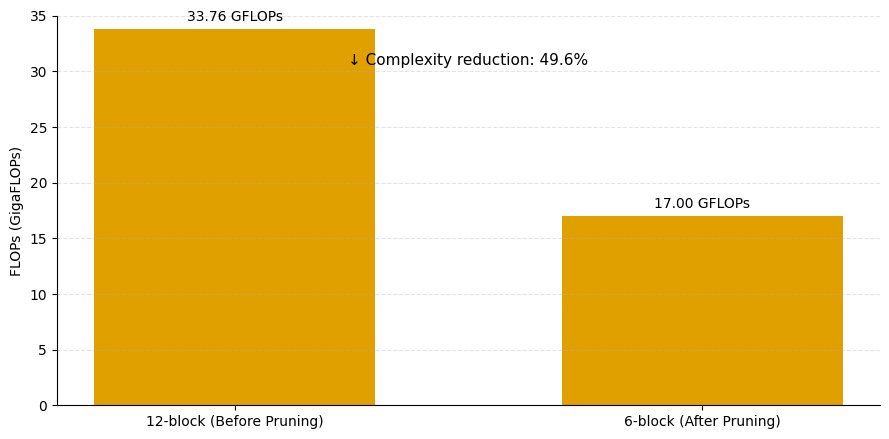

In [1]:
import matplotlib.pyplot as plt

# Data
labels = ["12-block (Before Pruning)", "6-block (After Pruning)"]
flops = [33.76, 17.00]

# Reduction (as shown in the figure)
reduction_pct = 49.6

# Plot
fig, ax = plt.subplots(figsize=(9, 4.5))
bars = ax.bar(range(len(flops)), flops, width=0.6, color="#E0A000")  # orange-gold

# Axes / labels
ax.set_ylabel("FLOPs (GigaFLOPs)")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylim(0, 35)

# Light gridlines like the image
ax.grid(axis="y", linestyle="--", alpha=0.35)

# Value labels on bars
for b, v in zip(bars, flops):
    ax.text(b.get_x() + b.get_width()/2, v + 0.5, f"{v:.2f} GFLOPs",
            ha="center", va="bottom", fontsize=10)

# Annotation text + arrow (centered above the bars)
ax.annotate(f"\u2193 Complexity reduction: {reduction_pct:.1f}%",
            xy=(0.5, 31.0), xytext=(0.5, 31.0),
            ha="center", va="center", fontsize=11, color="black")

# Clean up spines for a similar look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


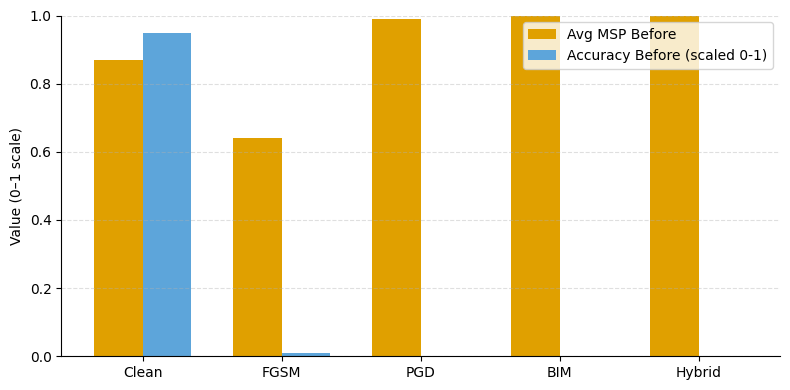

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Categories
attacks = ["Clean", "FGSM", "PGD", "BIM", "Hybrid"]

# Values (adjust if needed to match your exact numbers)
avg_msp_before = [0.87, 0.64, 0.99, 1.00, 1.00]
accuracy_before = [0.95, 0.01, 0.00, 0.00, 0.00]  # scaled 0–1

x = np.arange(len(attacks))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

# Bars
bars1 = ax.bar(x - width/2, avg_msp_before, width,
               label="Avg MSP Before",
               color="#E0A000")

bars2 = ax.bar(x + width/2, accuracy_before, width,
               label="Accuracy Before (scaled 0-1)",
               color="#5DA5DA")

# Labels & formatting
ax.set_ylabel("Value (0–1 scale)")
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.set_ylim(0, 1.0)

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Clean top/right borders (to match style)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


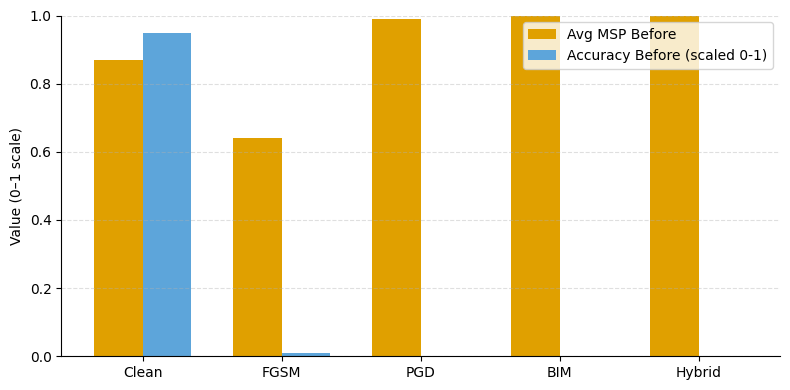

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Categories
attacks = ["Clean", "FGSM", "PGD", "BIM", "Hybrid"]

# Values (adjust if needed to match your exact numbers)
avg_msp_before = [0.87, 0.64, 0.99, 1.00, 1.00]
accuracy_before = [0.95, 0.01, 0.00, 0.00, 0.00]  # scaled 0–1

x = np.arange(len(attacks))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

# Bars
bars1 = ax.bar(x - width/2, avg_msp_before, width,
               label="Avg MSP Before",
               color="#E0A000")

bars2 = ax.bar(x + width/2, accuracy_before, width,
               label="Accuracy Before (scaled 0-1)",
               color="#5DA5DA")

# Labels & formatting
ax.set_ylabel("Value (0–1 scale)")
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.set_ylim(0, 1.0)

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Clean top/right borders (to match style)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


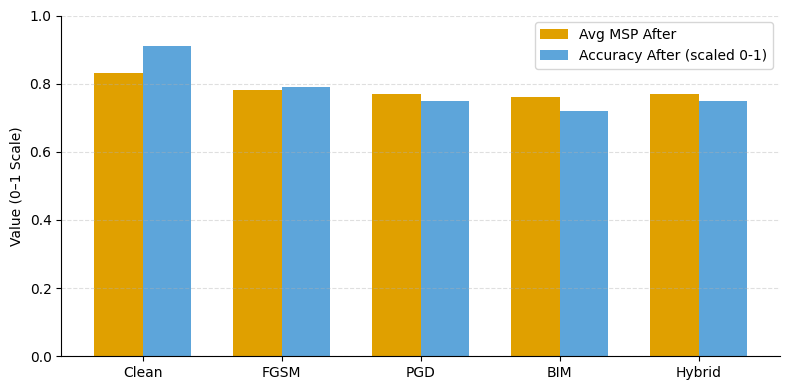

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Categories
attacks = ["Clean", "FGSM", "PGD", "BIM", "Hybrid"]

# Approximate values from the figure (adjust if needed)
avg_msp_after = [0.83, 0.78, 0.77, 0.76, 0.77]
accuracy_after = [0.91, 0.79, 0.75, 0.72, 0.75]  # scaled 0–1

x = np.arange(len(attacks))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

# Bars
bars1 = ax.bar(x - width/2, avg_msp_after, width,
               label="Avg MSP After",
               color="#E0A000")

bars2 = ax.bar(x + width/2, accuracy_after, width,
               label="Accuracy After (scaled 0-1)",
               color="#5DA5DA")

# Labels and formatting
ax.set_ylabel("Value (0–1 Scale)")
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.set_ylim(0, 1.0)

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Clean style like your figure
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


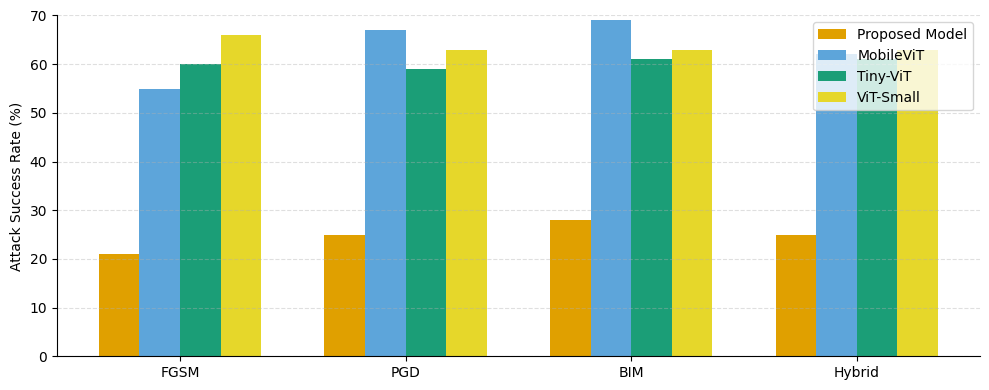

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Categories
attacks = ["FGSM", "PGD", "BIM", "Hybrid"]

# Approximate values from your figure (edit if needed)
proposed = [21, 25, 28, 25]
mobilevit = [55, 67, 69, 62]
tiny_vit = [60, 59, 61, 61]
vit_small = [66, 63, 63, 63]

x = np.arange(len(attacks))
width = 0.18  # narrower bars for 4 models

fig, ax = plt.subplots(figsize=(10, 4))

# Bars
ax.bar(x - 1.5*width, proposed, width, label="Proposed Model", color="#E0A000")
ax.bar(x - 0.5*width, mobilevit, width, label="MobileViT", color="#5DA5DA")
ax.bar(x + 0.5*width, tiny_vit, width, label="Tiny-ViT", color="#1B9E77")
ax.bar(x + 1.5*width, vit_small, width, label="ViT-Small", color="#E6D72A")

# Labels and formatting
ax.set_ylabel("Attack Success Rate (%)")
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.set_ylim(0, 70)

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Clean top/right borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


Device: cuda
Folder class order: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
Selected AMD image: /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train/AMD/amd_train_3258.jpg
⚠️ Full model load failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.ModelWithNorm was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.ModelWithNorm])` 

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Truncated to 6 blocks.
✅ Loaded weights.
✅ Saved: /kaggle/working/adv_one_image_per_attack/one_image_per_attack_pixel_marks.png


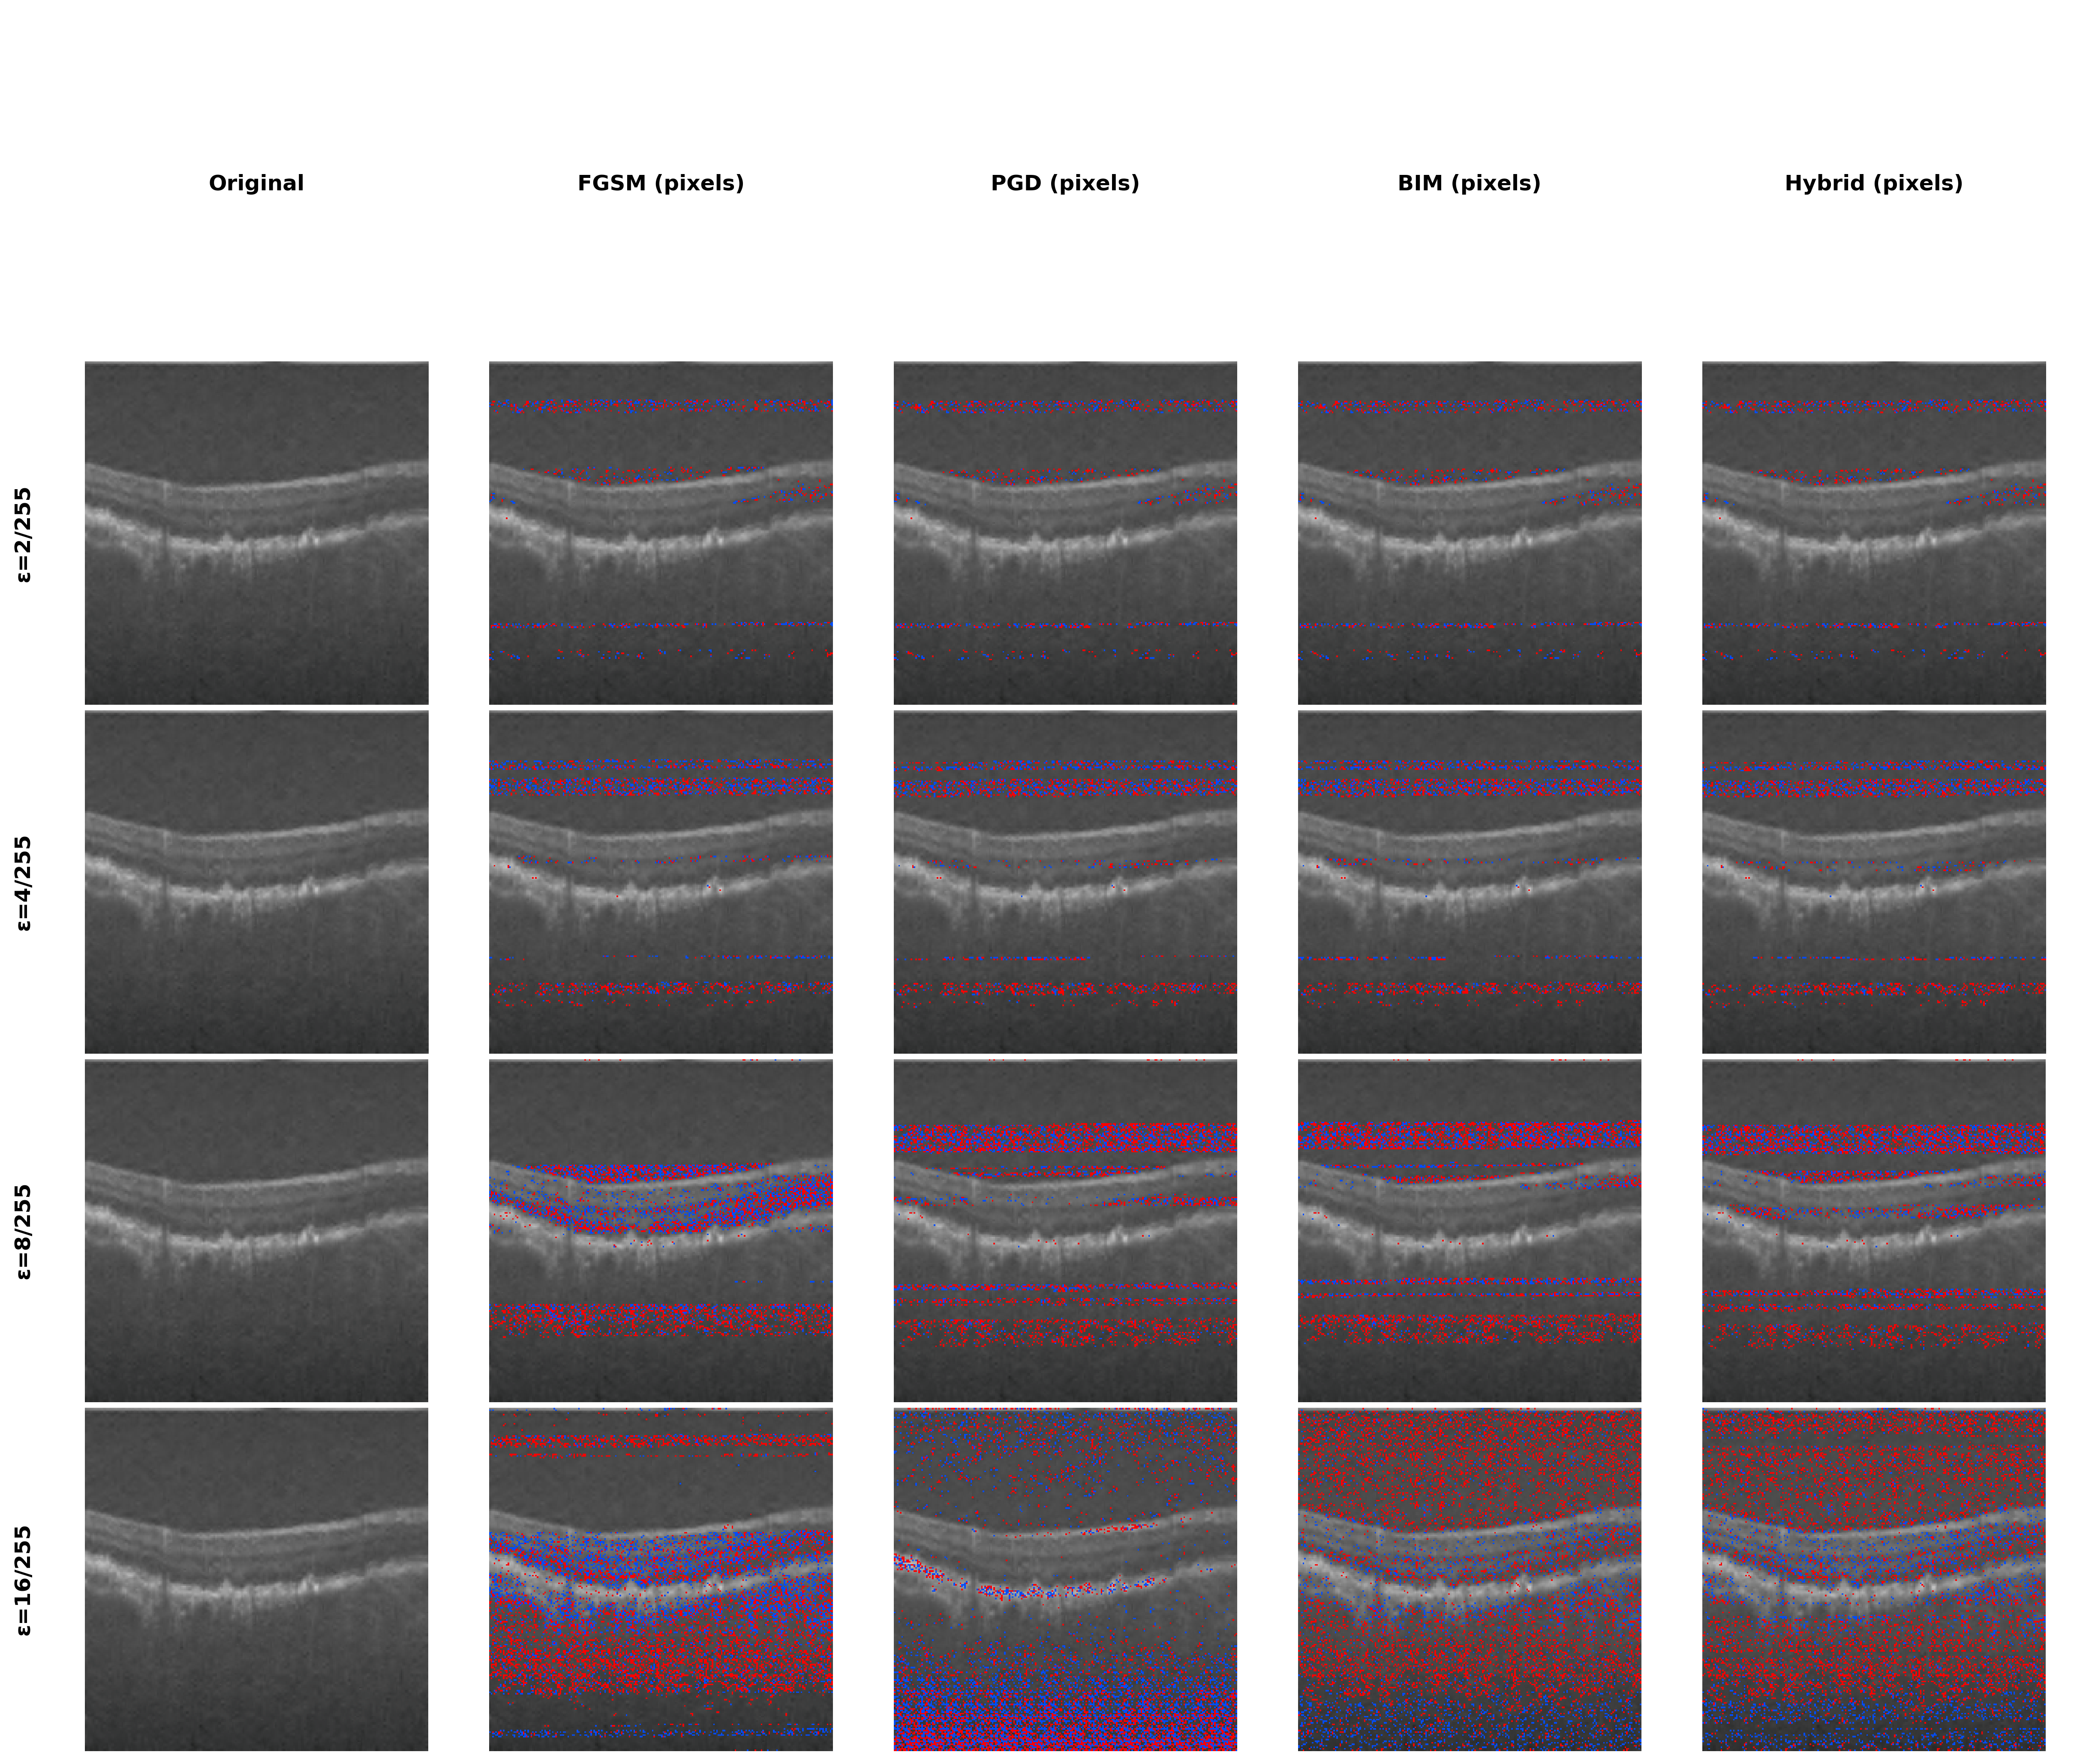

Done. Output folder: /kaggle/working/adv_one_image_per_attack


In [9]:
# ============================================================
# ONE-IMAGE-PER-ATTACK VISUALIZATION (PIXELS MARKED ON ORIGINAL)
# - Each attack shown as ONE overlay image (no extra noise images)
# - Changed pixels are marked directly (Red=+delta, Blue=-delta)
# ============================================================

import os, glob, random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# -----------------------------
# 0) Repro + device
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

plt.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.size": 12,
    "font.weight": "bold",
    "axes.titleweight": "bold",
    "axes.labelweight": "bold",
})

# -----------------------------
# 1) Dataset paths + choose ONE AMD image
# -----------------------------
DATA_ROOT = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train"
assert os.path.isdir(DATA_ROOT), f"Path not found: {DATA_ROOT}"

classes = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
class_to_idx = {c: i for i, c in enumerate(classes)}
print("Folder class order:", classes)

TARGET_CLASS = "AMD"
AMD_DIR = os.path.join(DATA_ROOT, TARGET_CLASS)
assert os.path.isdir(AMD_DIR), f"Class folder not found: {AMD_DIR}"

IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
amd_paths = [p for p in glob.glob(os.path.join(AMD_DIR, "*")) if p.lower().endswith(IMG_EXTS)]
assert len(amd_paths) > 0, "No images found in AMD folder."

img_path = random.choice(amd_paths)
print("Selected AMD image:", img_path)

y_true = torch.tensor([class_to_idx[TARGET_CLASS]], device=device, dtype=torch.long)

# -----------------------------
# 2) Load YOUR model (full model first, fallback to weights)
# -----------------------------
MODEL_FULL_PATH = "/kaggle/input/models/munthirqasaimeh/6blocksjounral/pytorch/default/1/ViT_6blocks_adv_withVAL.pth"
MODEL_WEIGHTS_PATH = "/kaggle/input/models/munthirqasaimeh/6blocksweightjournal/pytorch/default/1/ViT_6blocks_adv_withVAL_weights.pth"

assert os.path.isfile(MODEL_FULL_PATH), f"Full model file not found: {MODEL_FULL_PATH}"
assert os.path.isfile(MODEL_WEIGHTS_PATH), f"Weights file not found: {MODEL_WEIGHTS_PATH}"

def _extract_state_dict(obj):
    if isinstance(obj, dict):
        for key in ["state_dict", "model", "model_state_dict"]:
            if key in obj and isinstance(obj[key], dict):
                obj = obj[key]
                break
    if isinstance(obj, dict):
        return {k.replace("module.", ""): v for k, v in obj.items() if torch.is_tensor(v)}
    return None

model = None
try:
    tmp = torch.load(MODEL_FULL_PATH, map_location=device)
    if hasattr(tmp, "to") and hasattr(tmp, "eval"):
        model = tmp.to(device).eval()
        print("✅ Loaded FULL model object successfully.")
    else:
        raise RuntimeError("Full model is not a model object.")
except Exception as e_full:
    print("⚠️ Full model load failed:", str(e_full))
    print("➡️ Rebuilding model using timm + loading WEIGHTS...")

    import timm
    import torch.nn as nn

    BASE_NAME = "vit_base_patch16_224"   # change if your backbone differs
    NUM_CLASSES = len(classes)

    model = timm.create_model(BASE_NAME, pretrained=False, num_classes=NUM_CLASSES)
    if hasattr(model, "blocks"):
        blocks = list(model.blocks)
        if len(blocks) >= 6:
            model.blocks = nn.Sequential(*blocks[:6])
            print("✅ Truncated to 6 blocks.")

    w = torch.load(MODEL_WEIGHTS_PATH, map_location=device)
    w = _extract_state_dict(w)
    assert w is not None and len(w) > 0, "Could not extract state_dict."
    model.load_state_dict(w, strict=False)
    model = model.to(device).eval()
    print("✅ Loaded weights.")

assert model is not None, "Model failed to load."

# -----------------------------
# 3) Preprocessing (ImageNet norm)
# -----------------------------
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)
IMG_SIZE = 224

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

def denorm_imagenet(x):
    mean = torch.tensor(IMNET_MEAN, device=x.device).view(1,3,1,1)
    std  = torch.tensor(IMNET_STD,  device=x.device).view(1,3,1,1)
    return (x * std + mean).clamp(0, 1)

@torch.no_grad()
def clamp_imagenet(x):
    mean = torch.tensor(IMNET_MEAN, device=x.device).view(1,3,1,1)
    std  = torch.tensor(IMNET_STD,  device=x.device).view(1,3,1,1)
    x_min = (0.0 - mean) / std
    x_max = (1.0 - mean) / std
    return torch.max(torch.min(x, x_max), x_min)

def eps_pixel_to_norm(eps_pixel):
    std = torch.tensor(IMNET_STD, device=device).view(1,3,1,1)
    return eps_pixel / std

def img01_np(x_norm):
    return denorm_imagenet(x_norm)[0].permute(1,2,0).detach().cpu().numpy()  # HWC [0,1]

def delta_pixel_np(clean_norm, adv_norm):
    c = denorm_imagenet(clean_norm)[0].permute(1,2,0) * 255.0
    a = denorm_imagenet(adv_norm)[0].permute(1,2,0) * 255.0
    d = (a - c)  # signed pixel delta
    return d.detach().cpu().numpy()  # HWC in pixel units

# -----------------------------
# 4) Attacks (L_inf)
# -----------------------------
ALPHA_PIXEL = 2/255
PGD_STEPS   = 7
BIM_STEPS   = 10
HYB_FGSM_STEPS = 1
HYB_PGD_STEPS  = 5

def fgsm(model, x, y, eps_norm):
    x_adv = x.clone().detach().requires_grad_(True)
    loss = F.cross_entropy(model(x_adv), y)
    model.zero_grad(set_to_none=True)
    loss.backward()
    x_adv = x_adv.detach() + eps_norm * x_adv.grad.detach().sign()
    return clamp_imagenet(x_adv)

def pgd_linf(model, x, y, eps_norm, alpha_norm, steps):
    x0 = x.clone().detach()
    x_adv = x0.clone()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), y)
        model.zero_grad(set_to_none=True)
        loss.backward()
        x_adv = x_adv.detach() + alpha_norm * x_adv.grad.detach().sign()
        delta = torch.max(torch.min(x_adv - x0, eps_norm), -eps_norm)
        x_adv = clamp_imagenet(x0 + delta)
    return x_adv.detach()

def bim(model, x, y, eps_norm, alpha_norm, steps):
    return pgd_linf(model, x, y, eps_norm, alpha_norm, steps)

def hybrid_fgsm_pgd(model, x, y, eps_norm, alpha_norm, fgsm_steps=1, pgd_steps=5):
    x_adv = x.clone().detach()
    for _ in range(fgsm_steps):
        x_adv = fgsm(model, x_adv, y, eps_norm)

    x0 = x.clone().detach()
    for _ in range(pgd_steps):
        x_adv.requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), y)
        model.zero_grad(set_to_none=True)
        loss.backward()
        x_adv = x_adv.detach() + alpha_norm * x_adv.grad.detach().sign()
        delta = torch.max(torch.min(x_adv - x0, eps_norm), -eps_norm)
        x_adv = clamp_imagenet(x0 + delta)
    return x_adv.detach()

# -----------------------------
# 5) Build ONE overlay image (points/pixels) per attack
# -----------------------------
def overlay_changed_pixels(base_img01, delta_px, topk=2000, alpha=0.95):
    """
    base_img01: HWC [0,1]
    delta_px  : HWC signed in pixel units
    - choose topk strongest pixels by |delta|
    - paint them directly on the image:
        Red  = positive delta (mean across channels)
        Blue = negative delta
    """
    H, W, _ = base_img01.shape

    # magnitude + signed (use mean sign across channels)
    mag = np.abs(delta_px).max(axis=2)        # H,W
    sgn = np.sign(delta_px.mean(axis=2))      # H,W (+/-)

    # pick topk pixels
    flat = mag.reshape(-1)
    k = min(topk, flat.size)
    idx = np.argpartition(flat, -k)[-k:]  # top-k (unordered)
    ys, xs = np.unravel_index(idx, (H, W))

    out = base_img01.copy()

    # color pixels
    # red for +, blue for -
    for y, x in zip(ys, xs):
        if sgn[y, x] >= 0:
            color = np.array([1.0, 0.0, 0.0])  # red
        else:
            color = np.array([0.0, 0.3, 1.0])  # blue (a bit brighter)
        out[y, x, :] = (1 - alpha) * out[y, x, :] + alpha * color

    return out

# -----------------------------
# 6) Load image tensor
# -----------------------------
img = Image.open(img_path).convert("RGB")
x_clean = preprocess(img).unsqueeze(0).to(device)
alpha_norm = eps_pixel_to_norm(ALPHA_PIXEL)

# -----------------------------
# 7) Plot grid (ONE image per attack)
# -----------------------------
EPS_LIST = [2/255, 4/255, 8/255, 16/255]

# IMPORTANT knobs (for visibility)
TOPK_BASE = 1200  # number of pixels to mark at eps=2/255
# We increase topk slightly with epsilon so the pattern is visible across rows:
def topk_for_eps(eps_pix):
    e = int(round(eps_pix * 255))
    return int(TOPK_BASE * (e / 2))  # 2->1200, 4->2400, 8->4800, 16->9600

COLS = ["Original", "FGSM (pixels)", "PGD (pixels)", "BIM (pixels)", "Hybrid (pixels)"]
N_COLS = len(COLS)
N_ROWS = len(EPS_LIST)

OUT_DIR = "/kaggle/working/adv_one_image_per_attack"
os.makedirs(OUT_DIR, exist_ok=True)

fig = plt.figure(figsize=(16, 3.2*N_ROWS + 0.8), dpi=300)

# header
for j, t in enumerate(COLS):
    ax = plt.subplot(N_ROWS + 1, N_COLS, j + 1)
    ax.axis("off")
    ax.text(0.5, 0.5, t, ha="center", va="center", fontsize=12, fontweight="bold")

for i, eps_pix in enumerate(EPS_LIST):
    eps_norm = eps_pixel_to_norm(eps_pix)
    topk = topk_for_eps(eps_pix)

    with torch.enable_grad():
        x_fgsm = fgsm(model, x_clean, y_true, eps_norm)
        x_pgd  = pgd_linf(model, x_clean, y_true, eps_norm, alpha_norm, steps=PGD_STEPS)
        x_bim  = bim(model, x_clean, y_true, eps_norm, alpha_norm, steps=BIM_STEPS)
        x_hyb  = hybrid_fgsm_pgd(model, x_clean, y_true, eps_norm, alpha_norm,
                                 fgsm_steps=HYB_FGSM_STEPS, pgd_steps=HYB_PGD_STEPS)

    base = img01_np(x_clean)
    d_fgsm = delta_pixel_np(x_clean, x_fgsm)
    d_pgd  = delta_pixel_np(x_clean, x_pgd)
    d_bim  = delta_pixel_np(x_clean, x_bim)
    d_hyb  = delta_pixel_np(x_clean, x_hyb)

    ov_fgsm = overlay_changed_pixels(base, d_fgsm, topk=topk, alpha=0.98)
    ov_pgd  = overlay_changed_pixels(base, d_pgd,  topk=topk, alpha=0.98)
    ov_bim  = overlay_changed_pixels(base, d_bim,  topk=topk, alpha=0.98)
    ov_hyb  = overlay_changed_pixels(base, d_hyb,  topk=topk, alpha=0.98)

    row = i + 1
    def ax_at(c):
        ax = plt.subplot(N_ROWS + 1, N_COLS, row * N_COLS + c + 1)
        ax.axis("off")
        return ax

    # original
    ax0 = ax_at(0)
    ax0.imshow(base)
    ax0.text(-0.18, 0.5, f"ε={int(round(eps_pix*255))}/255",
             transform=ax0.transAxes, rotation=90,
             ha="center", va="center", fontsize=12, fontweight="bold")

    ax_at(1).imshow(ov_fgsm)
    ax_at(2).imshow(ov_pgd)
    ax_at(3).imshow(ov_bim)
    ax_at(4).imshow(ov_hyb)

plt.tight_layout(pad=0.25)

out_path = os.path.join(OUT_DIR, "one_image_per_attack_pixel_marks.png")
plt.savefig(out_path, dpi=600, bbox_inches="tight")
print("✅ Saved:", out_path)

plt.show()
plt.close(fig)

print("Done. Output folder:", OUT_DIR)
# ============================================================
# END
# ============================================================

Device: cuda
Selected AMD image: amd_train_3258.jpg
Folder class order: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
⚠️ Could not load full model directly. Reason: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.ModelWithNorm was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.ModelWithNorm])` or the `torch.serialization.safe_globals([__main__.ModelW

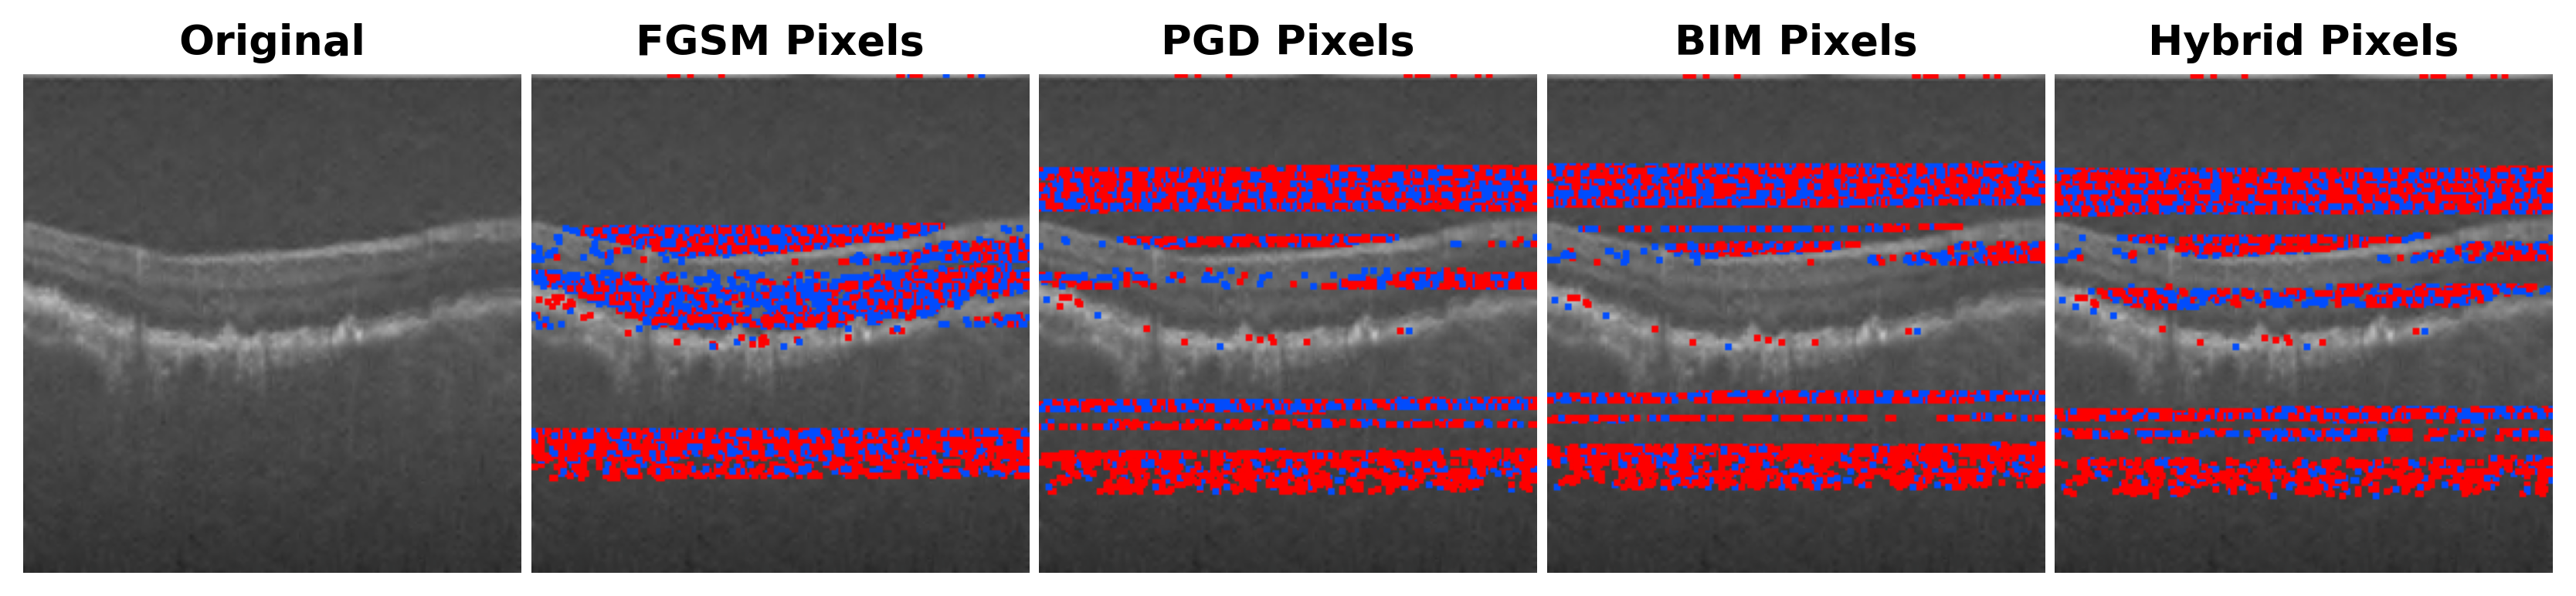


Done. Figure saved in: /kaggle/working/adv_figures_pixel_overlays_only


In [11]:
# ============================================================
# Kaggle — Single Image (AMD) — Pixel Overlay Only (6-block ViT)
# FROM SCRATCH: rebuild model + load weights + run attacks
#
# Output layout:
#   Original | FGSM Pixels | PGD Pixels | BIM Pixels | Hybrid Pixels
#
# Pixel overlay:
#   Red  = positive delta
#   Blue = negative delta
#
# Attacks (L_inf):
#   EPS   = 8/255
#   ALPHA = 2/255
#   FGSM  = 1 step
#   PGD   = 7 steps
#   BIM   = 10 steps
#   Hybrid = 1 FGSM + 5 PGD
# ============================================================

import os, glob, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# -----------------------------
# 0) Repro + device
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -----------------------------
# 0.1) Matplotlib style (bold, clear)
# -----------------------------
plt.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.size": 12,
    "font.weight": "bold",
    "axes.titleweight": "bold",
    "axes.labelweight": "bold",
})

# -----------------------------
# 1) DATASET PATH + pick ONE AMD image
# -----------------------------
DATA_ROOT = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train"
assert os.path.isdir(DATA_ROOT), f"Path not found: {DATA_ROOT}"

TARGET_CLASS = "AMD"
AMD_DIR = os.path.join(DATA_ROOT, TARGET_CLASS)
assert os.path.isdir(AMD_DIR), f"Class folder not found: {AMD_DIR}"

imgs = glob.glob(os.path.join(AMD_DIR, "*"))
imgs = [p for p in imgs if p.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"))]
assert len(imgs) > 0, "No images found in AMD folder."

IMG_PATH = random.choice(imgs)  # you can use sorted(imgs)[0] if you want deterministic
print("Selected AMD image:", os.path.basename(IMG_PATH))

# Folder class order (must match training)
classes = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
print("Folder class order:", classes)
assert TARGET_CLASS in class_to_idx, f"{TARGET_CLASS} not in folder list: {classes}"

NUM_CLASSES = len(classes)

# -----------------------------
# 2) LOAD YOUR MODEL (full model first, fallback to weights)
# -----------------------------
MODEL_FULL_PATH = "/kaggle/input/models/munthirqasaimeh/6blocksjounral/pytorch/default/1/ViT_6blocks_adv_withVAL.pth"
MODEL_WEIGHTS_PATH = "/kaggle/input/models/munthirqasaimeh/6blocksweightjournal/pytorch/default/1/ViT_6blocks_adv_withVAL_weights.pth"

assert os.path.isfile(MODEL_FULL_PATH), f"Full model file not found: {MODEL_FULL_PATH}"
assert os.path.isfile(MODEL_WEIGHTS_PATH), f"Weights file not found: {MODEL_WEIGHTS_PATH}"

def strip_state_dict(sd):
    # remove common wrappers and 'module.' prefix
    if isinstance(sd, dict) and "state_dict" in sd:
        sd = sd["state_dict"]
    if isinstance(sd, dict) and "model" in sd:
        sd = sd["model"]
    if isinstance(sd, dict):
        sd = {k.replace("module.", ""): v for k, v in sd.items() if torch.is_tensor(v)}
    return sd

model = None

# --- Try loading FULL MODEL (architecture included) ---
try:
    model = torch.load(MODEL_FULL_PATH, map_location=device)
    if isinstance(model, dict) and "model" in model:
        model = model["model"]
    if isinstance(model, dict) and "state_dict" in model:
        raise RuntimeError("Full model looks like state_dict container -> fallback to weights.")
    model = model.to(device)
    model.eval()
    print("✅ Loaded FULL model successfully.")
except Exception as e_full:
    print("⚠️ Could not load full model directly. Reason:", str(e_full))
    print("➡️ Rebuilding ViT-B/16 using timm, truncating to 6 blocks, then loading weights...")

    import timm

    BASE_NAME = "vit_base_patch16_224"
    model = timm.create_model(BASE_NAME, pretrained=False, num_classes=NUM_CLASSES)

    # Truncate to 6 blocks
    if hasattr(model, "blocks") and len(model.blocks) > 6:
        model.blocks = nn.Sequential(*list(model.blocks)[:6])
        print("✅ Truncated model.blocks to 6 blocks.")
    else:
        print("⚠️ Could not truncate model.blocks automatically. (Already 6 blocks or structure differs.)")

    w = torch.load(MODEL_WEIGHTS_PATH, map_location=device)
    w = strip_state_dict(w)

    missing, unexpected = model.load_state_dict(w, strict=False)
    model = model.to(device).eval()

    print("✅ Loaded WEIGHTS into rebuilt model.")
    if missing:
        print("Missing keys (first 20):", missing[:20], "..." if len(missing) > 20 else "")
    if unexpected:
        print("Unexpected keys (first 20):", unexpected[:20], "..." if len(unexpected) > 20 else "")

assert model is not None, "Model failed to load."

# -----------------------------
# 3) PREPROCESSING (ImageNet normalization)
# -----------------------------
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)
IMG_SIZE = 224

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

def denorm_imagenet(x):
    mean = torch.tensor(IMNET_MEAN, device=x.device).view(1,3,1,1)
    std  = torch.tensor(IMNET_STD,  device=x.device).view(1,3,1,1)
    return (x * std + mean).clamp(0, 1)

@torch.no_grad()
def clamp_imagenet(x):
    mean = torch.tensor(IMNET_MEAN, device=x.device).view(1,3,1,1)
    std  = torch.tensor(IMNET_STD,  device=x.device).view(1,3,1,1)
    x_min = (0.0 - mean) / std
    x_max = (1.0 - mean) / std
    return torch.max(torch.min(x, x_max), x_min)

def eps_pixel_to_norm(eps_pixel):
    std = torch.tensor(IMNET_STD, device=device).view(1,3,1,1)
    return eps_pixel / std

def to_numpy_img(x_norm):
    # image HWC in [0,1]
    return denorm_imagenet(x_norm)[0].permute(1,2,0).detach().cpu().numpy()

def delta_pixel_np(clean_norm, adv_norm):
    # signed delta in PIXEL units (HWC)
    c = denorm_imagenet(clean_norm)[0].permute(1,2,0) * 255.0
    a = denorm_imagenet(adv_norm)[0].permute(1,2,0) * 255.0
    d = (a - c)
    return d.detach().cpu().numpy()

def overlay_changed_pixels(base_img01, delta_px, topk=4500, alpha=0.98, dot_radius=1):
    """
    ONE overlay image:
    - base_img01: HWC [0,1]
    - delta_px  : HWC signed delta in pixel units
    - topk strongest pixels by |delta| are colored directly on the image
    - Red = positive delta, Blue = negative delta
    - dot_radius=1 makes 3x3 dot for visibility
    """
    H, W, _ = base_img01.shape
    mag = np.abs(delta_px).max(axis=2)       # H,W
    sgn = np.sign(delta_px.mean(axis=2))     # H,W

    flat = mag.reshape(-1)
    k = min(topk, flat.size)
    idx = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idx, (H, W))

    out = base_img01.copy()
    r = int(dot_radius)

    for y, x in zip(ys, xs):
        color = np.array([1.0, 0.0, 0.0]) if sgn[y, x] >= 0 else np.array([0.0, 0.3, 1.0])
        y0, y1 = max(0, y-r), min(H, y+r+1)
        x0, x1 = max(0, x-r), min(W, x+r+1)
        out[y0:y1, x0:x1, :] = (1 - alpha) * out[y0:y1, x0:x1, :] + alpha * color

    return out

# -----------------------------
# 4) ATTACKS (L_inf)
# -----------------------------
EPS   = 8/255
ALPHA = 2/255

PGD_STEPS  = 7
BIM_STEPS  = 10
HYB_PGD_STEPS = 5

def fgsm(model, x, y, eps_norm):
    x_adv = x.clone().detach().requires_grad_(True)
    loss = F.cross_entropy(model(x_adv), y)
    model.zero_grad(set_to_none=True)
    loss.backward()
    x_adv = x_adv.detach() + eps_norm * x_adv.grad.detach().sign()
    return clamp_imagenet(x_adv)

def pgd_linf(model, x, y, eps_norm, alpha_norm, steps):
    x0 = x.clone().detach()
    x_adv = x0.clone()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), y)
        model.zero_grad(set_to_none=True)
        loss.backward()
        x_adv = x_adv.detach() + alpha_norm * x_adv.grad.detach().sign()
        delta = torch.max(torch.min(x_adv - x0, eps_norm), -eps_norm)
        x_adv = clamp_imagenet(x0 + delta)
    return x_adv.detach()

def bim(model, x, y, eps_norm, alpha_norm, steps):
    return pgd_linf(model, x, y, eps_norm, alpha_norm, steps)

def hybrid_fgsm_pgd(model, x, y, eps_norm, alpha_norm, pgd_steps=5):
    x_adv = fgsm(model, x, y, eps_norm)
    x0 = x.clone().detach()
    for _ in range(pgd_steps):
        x_adv.requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), y)
        model.zero_grad(set_to_none=True)
        loss.backward()
        x_adv = x_adv.detach() + alpha_norm * x_adv.grad.detach().sign()
        delta = torch.max(torch.min(x_adv - x0, eps_norm), -eps_norm)
        x_adv = clamp_imagenet(x0 + delta)
    return x_adv.detach()

# -----------------------------
# 5) Load image + run attacks
# -----------------------------
y_true = torch.tensor([class_to_idx[TARGET_CLASS]], device=device, dtype=torch.long)

img = Image.open(IMG_PATH).convert("RGB")
x = preprocess(img).unsqueeze(0).to(device)

eps_norm   = eps_pixel_to_norm(EPS)
alpha_norm = eps_pixel_to_norm(ALPHA)

with torch.enable_grad():
    x_clean = x.detach()
    x_fgsm  = fgsm(model, x_clean, y_true, eps_norm)
    x_pgd   = pgd_linf(model, x_clean, y_true, eps_norm, alpha_norm, steps=PGD_STEPS)
    x_bim   = bim(model, x_clean, y_true, eps_norm, alpha_norm, steps=BIM_STEPS)
    x_hyb   = hybrid_fgsm_pgd(model, x_clean, y_true, eps_norm, alpha_norm, pgd_steps=HYB_PGD_STEPS)

# -----------------------------
# 6) Build ONE overlay image per attack (ONLY overlays)
# -----------------------------
base_img = to_numpy_img(x_clean)

TOPK_PIXELS = 4500
DOT_RADIUS  = 1
ALPHA_DOT   = 0.98

ov_fgsm = overlay_changed_pixels(base_img, delta_pixel_np(x_clean, x_fgsm),
                                 topk=TOPK_PIXELS, alpha=ALPHA_DOT, dot_radius=DOT_RADIUS)
ov_pgd  = overlay_changed_pixels(base_img, delta_pixel_np(x_clean, x_pgd),
                                 topk=TOPK_PIXELS, alpha=ALPHA_DOT, dot_radius=DOT_RADIUS)
ov_bim  = overlay_changed_pixels(base_img, delta_pixel_np(x_clean, x_bim),
                                 topk=TOPK_PIXELS, alpha=ALPHA_DOT, dot_radius=DOT_RADIUS)
ov_hyb  = overlay_changed_pixels(base_img, delta_pixel_np(x_clean, x_hyb),
                                 topk=TOPK_PIXELS, alpha=ALPHA_DOT, dot_radius=DOT_RADIUS)

# -----------------------------
# 7) Plot figure: Original + Pixel overlays only
# -----------------------------
OUT_DIR = "/kaggle/working/adv_figures_pixel_overlays_only"
os.makedirs(OUT_DIR, exist_ok=True)

panels = [
    ("Original", base_img),
    ("FGSM Pixels",   ov_fgsm),
    ("PGD Pixels",    ov_pgd),
    ("BIM Pixels",    ov_bim),
    ("Hybrid Pixels", ov_hyb),
]

fig_w, fig_h = 11.0, 2.8
title_fs = 13

fig = plt.figure(figsize=(fig_w, fig_h), dpi=300)
for i, (title, arr) in enumerate(panels):
    ax = plt.subplot(1, len(panels), i+1)
    ax.imshow(arr)
    ax.set_title(title, fontsize=title_fs, fontweight="bold")
    ax.axis("off")

plt.tight_layout(pad=0.25)

out_path = os.path.join(OUT_DIR, "AMD_PIXEL_OVERLAYS_ONLY_6blockmodel.png")
fig.savefig(out_path, dpi=600, bbox_inches="tight")
print("Saved:", out_path)

plt.show()
plt.close(fig)

print("\nDone. Figure saved in:", OUT_DIR)
# ============================================================
# END
# ============================================================
